In [1]:
import netCDF4 as nc
import numpy as np
import pickle
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import pandas as pd
from rasterio.transform import rowcol
from zoneinfo import ZoneInfo  


# Loading of the ICON 10m windspeed pickle file
windspeed_10m_icon_table = pd.read_pickle(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\wind-speed-10m_icon_table.pickle")

# Data cleaning(The remove of duplicated and unik value contains columns)
windspeed_10m_icon_table = windspeed_10m_icon_table.loc[:, ~windspeed_10m_icon_table.columns.duplicated()]
windspeed_10m_icon_table = windspeed_10m_icon_table.loc[:, windspeed_10m_icon_table.apply(lambda col: col.nunique() > 1, axis=0)]

# 🔹 Load of the corresponding excel files 
df_mapping_ICON_Station_ID = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Station_ID_vs_ICON_code.csv", sep=';')
# 🔹 Verification of columns availability
if not {"Station_ID", "ICON_code"}.issubset(df_mapping_ICON_Station_ID.columns):
    raise ValueError("Les colonnes 'Station_ID' et 'ICON_code' sont absentes du fichier.")
# 🔹 Create a dict of corresponding{ICON_code: Station_ID}
icon_to_station = dict(zip(df_mapping_ICON_Station_ID["ICON_code"].astype(str), df_mapping_ICON_Station_ID["Station_ID"]))
# 🔹 Subtitute the name of the columns instead of index
windspeed_10m_icon_table.rename(columns=icon_to_station, inplace=True)
windspeed_10m_icon_table.index = windspeed_10m_icon_table.index.tz_localize("UTC")

#Loading of the observed 10m windspeed pickle file
obs_10m_table = pd.read_pickle(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\wind-speed-10m_obs_table.pickle")
print("Before shift")
print(obs_10m_table["858148"])

#Set the time zone to UTC
station_SASSCAL_list = [
    "39711", "46943", "47066", "361100", "858246", "21", "22", "23", "24", "25",
    "67581", "67583", "67585", "67591", "67593", "68024", "68026", "68030", "68038",
    "68148", "68151", "68226", "68320", "68325", "68328", "101", "102", "103", "104",
    "105", "106", "108", "109", "110", "111", "112", "113", "114", "115", "116",
    "4230", "4756", "4806", "8893", "31195", "31196", "31197", "31198", "31199",
    "31200", "31202", "31203", "31204", "31205", "31206", "31207", "31209", "31210",
    "31212", "31213", "31214", "31215", "31216", "52121", "58557", "64243", "64258",
    "65934", "65941", "67134", "67135", "74229", "74714", "75823", "80493", "80498",
    "E7624", "E7625", "E7626", "E7627", "E7628", "E7629", "E7630", "E7631",
    "E9126", "E9127", "361096", "361097", "361098", "361099",
    "511942", "511943", "511944",
    "858576", "858577", "858580", "858581", "858583", "858585", "858590", "858596",
    "856134", "858148", "858594"
]
E_cols = ["E7624", "E7625", "E7626", "E7627", "E7628", "E7629", "E7630", "E7631", "E9126", "E9127"]
utc_plus_1_cols = ["46943", "47066", "361100", "858246"]
remains_sasscal_cols = [col for col in station_SASSCAL_list if col not in utc_plus_1_cols and col not in E_cols]
utc_plus_2_cols = [col for col in remains_sasscal_cols if col in obs_10m_table.columns]
remains_obs_all = [col for col in obs_10m_table.columns if col not in utc_plus_1_cols and col not in utc_plus_2_cols]

windspeed_10m_obs_table = pd.DataFrame()

# For station already in UTC
for col in remains_obs_all:
    if col in obs_10m_table.columns:
        s = obs_10m_table[col].copy()
        s.index = s.index.tz_localize("UTC")
        windspeed_10m_obs_table[col] = s

# For station in UTC+1 (like l'Angola)
for col in utc_plus_1_cols:
    if col in obs_10m_table.columns:
        s = obs_10m_table[col].copy()
        s.index = s.index.tz_localize("Africa/Luanda").tz_convert("UTC")
        windspeed_10m_obs_table[col] = s

# For station in UTC+2 (like l'Afrique du Sud)
for col in utc_plus_2_cols:
    if col in obs_10m_table.columns:
        s = obs_10m_table[col].copy()
        s.index = s.index.tz_localize("Africa/Johannesburg").tz_convert("UTC")
        windspeed_10m_obs_table[col] = s      
print("After shift")
print(windspeed_10m_obs_table["858148"])

#End of time zone setting

#The remove of the implausible data
windspeed_10m_obs_table = windspeed_10m_obs_table.where((windspeed_10m_obs_table >= 0) & (windspeed_10m_obs_table <= 40), other=pd.NA)
# 🔹Definition of NaN % limit to delete column
threshold = 0.70
# 🔹 Supprimer les colonnes où PLUS DE `threshold` % des valeurs sont NaN
windspeed_10m_obs_table = windspeed_10m_obs_table.dropna(axis=1, thresh=int((1 - threshold) * len(windspeed_10m_obs_table)))


# ERA5 Start here
stations = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Stationlat&lon_new.csv" , sep=';')

ERA5_Wind_2017_10m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-04-14\wind_speed\43df5441fac8134c5e81bd3aa0c48fb0\data_stream-oper_stepType-instant.nc")
ERA5_Wind_2018_10m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-04-14\wind_speed\f4cdecdedec5898827f229a7fb114bd5\data_stream-oper_stepType-instant.nc")
ERA5_Wind_2019_10m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-04-14\wind_speed\c832a1ecc417cc0e2e0a31ebed19cef6\data_stream-oper_stepType-instant.nc")
wind_2017_u10 = ERA5_Wind_2017_10m.variables['u10'][:]
wind_2017_v10 = ERA5_Wind_2017_10m.variables['v10'][:]
wind_2018_u10 = ERA5_Wind_2018_10m.variables['u10'][:]
wind_2018_v10 = ERA5_Wind_2018_10m.variables['v10'][:]
wind_2019_u10 = ERA5_Wind_2019_10m.variables['u10'][:]
wind_2019_v10 = ERA5_Wind_2019_10m.variables['v10'][:]

wind_ERA5_list = []
lats_2017 = ERA5_Wind_2017_10m['latitude'][:]
lons_2017 = ERA5_Wind_2017_10m['longitude'][:]
lats_2018 = ERA5_Wind_2018_10m['latitude'][:]
lons_2018 = ERA5_Wind_2018_10m['longitude'][:]
lats_2019 = ERA5_Wind_2019_10m['latitude'][:]
lons_2019 = ERA5_Wind_2019_10m['longitude'][:]
for _, row in stations.iterrows():
    lat_idx_2017 = np.abs(lats_2017 - row['latitude']).argmin()
    lon_idx_2017 = np.abs(lons_2017 - row['longitude']).argmin()
    lat_idx_2018 = np.abs(lats_2018 - row['latitude']).argmin()
    lon_idx_2018 = np.abs(lons_2018 - row['longitude']).argmin()
    lat_idx_2019 = np.abs(lats_2019 - row['latitude']).argmin()
    lon_idx_2019 = np.abs(lons_2019 - row['longitude']).argmin()
    wind_2017_10m = np.sqrt(((wind_2017_u10[:, lat_idx_2017, lon_idx_2017])**2) + ((wind_2017_v10[:, lat_idx_2017, lon_idx_2017])**2))
    wind_2018_10m = np.sqrt(((wind_2018_u10[:, lat_idx_2018, lon_idx_2018])**2) + ((wind_2018_v10[:, lat_idx_2018, lon_idx_2018])**2))
    wind_2019_10m = np.sqrt(((wind_2019_u10[:, lat_idx_2019, lon_idx_2019])**2) + ((wind_2019_v10[:, lat_idx_2019, lon_idx_2019])**2))
    wind_2017_to_2019_ERA5_10m = np.concatenate([wind_2017_10m, wind_2018_10m, wind_2019_10m], axis=0)
    wind_ERA5_list.append(pd.Series(wind_2017_to_2019_ERA5_10m, name=row['station']))
    
wind_ERA5 = pd.concat(wind_ERA5_list, axis=1)
start_time = "2017-01-01 00:00:00"
wind_ERA5.index = pd.date_range(start=start_time, periods=wind_ERA5.shape[0], freq="h").tz_localize("UTC")
print(wind_ERA5['858148'])

# Extraction of ERA5 WM
WM_Station = ['WM01', 'WM02', 'WM03', 'WM05', 'WM06', 'WM07', 'WM08', 'WM09', 'WM10', 'WM11', 'WM12', 'WM13', 'WM14', 'WM15', 'WM16', 'WM17', 'WM18', 'WM19']
windspeed_10m_ERA5_WM = wind_ERA5[WM_Station]

#ERA5_GWA start here
ERA5_wind_speed_10m_mean_2008to2017_southern_Africa = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-04-14\wind_speed\ERA5_wind_speed_10m_mean_2008to2017_southern_Africa.nc")
lats_ERA5 = ERA5_wind_speed_10m_mean_2008to2017_southern_Africa.variables['latitude'][:]
lons_ERA5 = ERA5_wind_speed_10m_mean_2008to2017_southern_Africa.variables['longitude'][:]
wind_mean_ERA5 = ERA5_wind_speed_10m_mean_2008to2017_southern_Africa.variables['si10'][0, :, :]  # (time, lat, lon)

# === Étape 1 : Load of CSV files of stations carateristics
stations = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Stationlat&lon_new.csv" , sep=';')
# === Étape 3 : Nearest grid finding
def get_wind_value(lon, lat):
    lat_idx = np.abs(lats_ERA5 - lat).argmin()
    lon_idx = np.abs(lons_ERA5 - lon).argmin()
    return float(wind_mean_ERA5[lat_idx, lon_idx])  # Convertir en float simple

# === Étape 4 : Application on every stations
stations['wind_mean_10m_ERA5'] = stations.apply(lambda row: get_wind_value(row['longitude'], row['latitude']), axis=1)

# === Load of raster GWA
rds = rxr.open_rasterio(r"C:\Users\LENOVO\Downloads\wind_speed_cog_10m.tif",masked=True).squeeze()

# Use of xarray for nesrest
rds = rds.sortby("y")

# Verification
print("📐 Dimensions raster :", rds.dims)  # ('y', 'x') — bon !
print("🧭 Coordonnées disponibles :", list(rds.coords))  # ['x', 'y']

# === Nearest methods
interpolated = rds.interp(
    x=("points", stations["longitude"].values),
    y=("points", stations["latitude"].values),
    method="nearest"
)

# === Ajouter la colonne au tableau
stations["wind_mean_10m_GWA_xarray_nearest"] = interpolated.values

stations.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Stations_ERA5_GWA_mean_xarray_nearest.xlsx", index=False)
stations['scaling_factor'] = stations['wind_mean_10m_GWA_xarray_nearest'] / stations['wind_mean_10m_ERA5']
stations.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Station_scaling_ERA5_GWA_array_nearest.xlsx", index=False)
print("✅ Nearest methode avec xarray terminée !")        

wind_ERA5_GWA_list = []

for _, row in stations.iterrows():
    station_code = row['station']
    if station_code in wind_ERA5.columns:
        wind_ts = wind_ERA5[station_code]
        wind_correction = wind_ts * row['scaling_factor']
        wind_ERA5_GWA_list.append(pd.Series(wind_correction, name=station_code))

# Fusionner les séries en un DataFrame
wind_ERA5_GWA = pd.concat(wind_ERA5_GWA_list, axis=1)

# Ajouter une index temporel
start_time = "2017-01-01 00:00:00"
wind_ERA5_GWA.index = pd.date_range(start=start_time, periods=wind_ERA5_GWA.shape[0], freq="h").tz_localize("UTC")
print(wind_ERA5_GWA['858148'])
#extraire les WM de ERA5
windspeed_10m_ERA5_GWA_WM = wind_ERA5_GWA[WM_Station]

# 🔹 Find identic column
common_stations = list(set(windspeed_10m_obs_table.columns) & set(windspeed_10m_icon_table.columns) & set(wind_ERA5.columns) & set(wind_ERA5_GWA.columns))
# 🔹 Filtrer les DataFrames pour ne garder que les stations communes
windspeed_10m_obs_table = windspeed_10m_obs_table[common_stations]
windspeed_10m_icon_table = windspeed_10m_icon_table[common_stations]
windspeed_10m_ERA5_table = wind_ERA5[common_stations]
windspeed_10m_ERA5_GWA_table = wind_ERA5_GWA[common_stations]



Before shift
2017-01-01 00:00:00    2.505556
2017-01-01 01:00:00    2.018750
2017-01-01 02:00:00    1.509722
2017-01-01 03:00:00    1.631944
2017-01-01 04:00:00    1.262500
                         ...   
2019-12-31 20:00:00         NaN
2019-12-31 21:00:00         NaN
2019-12-31 22:00:00         NaN
2019-12-31 23:00:00         NaN
2020-01-01 00:00:00         NaN
Freq: h, Name: 858148, Length: 26281, dtype: float64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  windspeed_10m_obs_table[col] = s
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1121246001.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

After shift
2017-01-01 00:00:00+00:00    1.509722
2017-01-01 01:00:00+00:00    1.631944
2017-01-01 02:00:00+00:00    1.262500
2017-01-01 03:00:00+00:00    1.859722
2017-01-01 04:00:00+00:00    1.425000
                               ...   
2019-12-31 20:00:00+00:00         NaN
2019-12-31 21:00:00+00:00         NaN
2019-12-31 22:00:00+00:00         NaN
2019-12-31 23:00:00+00:00         NaN
2020-01-01 00:00:00+00:00         NaN
Freq: h, Name: 858148, Length: 26281, dtype: float64
2017-01-01 00:00:00+00:00    1.284223
2017-01-01 01:00:00+00:00    1.171081
2017-01-01 02:00:00+00:00    1.104770
2017-01-01 03:00:00+00:00    1.119423
2017-01-01 04:00:00+00:00    1.225262
                               ...   
2019-12-31 19:00:00+00:00    1.330324
2019-12-31 20:00:00+00:00    2.500654
2019-12-31 21:00:00+00:00    1.653970
2019-12-31 22:00:00+00:00    0.554854
2019-12-31 23:00:00+00:00    1.939928
Freq: h, Name: 858148, Length: 26280, dtype: float64
📐 Dimensions raster : ('y', 'x')
🧭 Coordonnées

In [2]:
#  ICON-LAM and Observed data Dict creation
obs_dict = {}   # Contiendra les données d'observation (WS_10_obs)
icon_dict = {}  # Contiendra les données simulées ICON (WS_10_ICON)

#  Conversion of dataframe into dict
for station in windspeed_10m_obs_table.columns:
    obs_dict[station] = pd.DataFrame({"WS_10_obs": windspeed_10m_obs_table[station]})

for station in windspeed_10m_icon_table.columns:
    icon_dict[station] = pd.DataFrame({"WS_10_ICON": windspeed_10m_icon_table[station]})

#  Station information loading
station_info = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Station_ID_vs_ICON_code & lat_lon_Label.csv", sep=';')

required_columns = {"Station_ID", "longitude", "latitude", "label"}
if not required_columns.issubset(station_info.columns):
    raise ValueError("Les colonnes 'Station_ID', 'longitude', 'latitude', 'label' sont absentes du fichier CSV.")

station_meta = station_info.set_index("Station_ID")[["longitude", "latitude", "label"]].to_dict(orient="index")

# dict configuration
for station in obs_dict.keys():
    if station in station_meta:
        obs_dict[station]["Station_ID"] = station
        obs_dict[station]["longitude"] = station_meta[station]["longitude"]
        obs_dict[station]["latitude"] = station_meta[station]["latitude"]
        obs_dict[station]["label"] = station_meta[station]["label"]

for station in icon_dict.keys():
    if station in station_meta:
        icon_dict[station]["Station_ID"] = station
        icon_dict[station]["longitude"] = station_meta[station]["longitude"]
        icon_dict[station]["latitude"] = station_meta[station]["latitude"]
        icon_dict[station]["label"] = station_meta[station]["label"]


# ERA5 and ERA5_GWA dict creation
ERA5_dict = {}   # Contiendra les données d'observation (WS_10_ERA5)
ERA5_GWA_dict = {}   # Contiendra les données d'observation (WS_10_ERA5_GWA)
# 🔹 Convertir les DataFrames en dictionnaires basés sur les colonnes actuelles (stations)
for station in windspeed_10m_ERA5_table.columns:
    ERA5_dict[station] = pd.DataFrame({"WS_10_ERA5": windspeed_10m_ERA5_table[station]})

for station in windspeed_10m_ERA5_GWA_table.columns:
    ERA5_GWA_dict[station] = pd.DataFrame({"WS_10_ERA5_GWA": windspeed_10m_ERA5_GWA_table[station]})

# 🔹 Ajouter les métadonnées à chaque station dans les dictionnaires
for station in ERA5_dict.keys():
    if station in station_meta:
        ERA5_dict[station]["Station_ID"] = station
        ERA5_dict[station]["longitude"] = station_meta[station]["longitude"]
        ERA5_dict[station]["latitude"] = station_meta[station]["latitude"]
        ERA5_dict[station]["label"] = station_meta[station]["label"]
        
for station in ERA5_GWA_dict.keys():
    if station in station_meta:
        ERA5_GWA_dict[station]["Station_ID"] = station
        ERA5_GWA_dict[station]["longitude"] = station_meta[station]["longitude"]
        ERA5_GWA_dict[station]["latitude"] = station_meta[station]["latitude"]
        ERA5_GWA_dict[station]["label"] = station_meta[station]["label"]



In [3]:
# 🔹 Initialiser un dictionnaire pour stocker les résultats ICON
metrics_ICON_dict = {}

# 🔹 Calculer les métriques pour chaque station
for station in obs_dict.keys():
    if station in icon_dict:  # Vérifier que la station est présente dans les deux dictionnaires
        obs_data = obs_dict[station]["WS_10_obs"].dropna()  # Supprimer les NaN
        icon_data = icon_dict[station]["WS_10_ICON"].dropna()  # Supprimer les NaN

        # 🔹 Aligner les données en fonction de l'index (temps)
        obs_data.name = "WS_10_obs"
        icon_data.name = "WS_10_ICON"
        merged_df_ICON = pd.concat([obs_data, icon_data], axis=1, join="inner")

        if not merged_df_ICON.empty:
            mae = np.mean(np.abs(merged_df_ICON["WS_10_ICON"] - merged_df_ICON["WS_10_obs"]))  # Mean Absolute Error
            me = np.mean(merged_df_ICON["WS_10_ICON"] - merged_df_ICON["WS_10_obs"])  # Mean Error
                        
            # 🔹 Pearson r (calculé manuellement selon la formule souhaitée)
            O = merged_df_ICON["WS_10_obs"].values
            M = merged_df_ICON["WS_10_ICON"].values  # 2ᵉ colonne du modèle (ICON, ERA5 ou ERA5_GWA)

            O_bar = np.mean(O)
            M_bar = np.mean(M)
            numerateur = np.sum((M - M_bar) * (O - O_bar))
            denominateur = np.sqrt(np.sum((M - M_bar)**2)) * np.sqrt(np.sum((O - O_bar)**2))
            pearson_r = numerateur / denominateur if denominateur != 0 else np.nan
            
            
            hist_obs, bin_edges = np.histogram(merged_df_ICON["WS_10_obs"], bins=20, density=True)
            hist_icon, _ = np.histogram(merged_df_ICON["WS_10_ICON"], bins=bin_edges, density=True)
            pss = np.sum(np.minimum(hist_obs, hist_icon)) * np.diff(bin_edges).mean()

            # 🔹 Stocker les résultats
            metrics_ICON_dict[station] = {
                "Station_ID": station,
                "longitude": obs_dict[station]["longitude"].iloc[0],
                "latitude": obs_dict[station]["latitude"].iloc[0],
                "label": obs_dict[station]["label"].iloc[0],
                "MAE": mae,
                "ME": me,
                "Pearson r": pearson_r,
                "PSS": pss
            }

# 🔹 Convertir en DataFrame pour affichage et sauvegarde
metrics_ICON_df = pd.DataFrame.from_dict(metrics_ICON_dict, orient="index")
# 🔹 Sauvegarder le DataFrame en CSV pour utilisation future (optionnel)
metrics_ICON_df.to_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ICON_LAM_results.csv", index=False)


# 🔹 Initialiser un dictionnaire pour stocker les résultats ERA5
metrics_ERA5_dict = {}

# 🔹 Calculer les métriques pour chaque station
for station in obs_dict.keys():
    if station in ERA5_dict:  # Vérifier que la station est présente dans les deux dictionnaires
        obs_data = obs_dict[station]["WS_10_obs"].dropna()  # Supprimer les NaN
        ERA5_data = ERA5_dict[station]["WS_10_ERA5"].dropna()  # Supprimer les NaN

        # 🔹 Aligner les données en fonction de l'index (temps)
        obs_data.name = "WS_10_obs"
        ERA5_data.name = "WS_10_ERA5"
        merged_df_ERA5 = pd.concat([obs_data, ERA5_data], axis=1, join="inner")

        if not merged_df_ERA5.empty:
            mae = np.mean(np.abs(merged_df_ERA5["WS_10_ERA5"] - merged_df_ERA5["WS_10_obs"]))  # Mean Absolute Error
            me = np.mean(merged_df_ERA5["WS_10_ERA5"] - merged_df_ERA5["WS_10_obs"])  # Mean Error
            
            # 🔹 Pearson r (calculé manuellement selon la formule souhaitée)
            O = merged_df_ERA5["WS_10_obs"].values
            M = merged_df_ERA5["WS_10_ERA5"].values  # 2ᵉ colonne du modèle (ICON, ERA5 ou ERA5_GWA)

            O_bar = np.mean(O)
            M_bar = np.mean(M)
            numerateur = np.sum((M - M_bar) * (O - O_bar))
            denominateur = np.sqrt(np.sum((M - M_bar)**2)) * np.sqrt(np.sum((O - O_bar)**2))
            pearson_r = numerateur / denominateur if denominateur != 0 else np.nan

            
            hist_obs, bin_edges = np.histogram(merged_df_ERA5["WS_10_obs"], bins=20, density=True)
            hist_icon, _ = np.histogram(merged_df_ERA5["WS_10_ERA5"], bins=bin_edges, density=True)
            pss = np.sum(np.minimum(hist_obs, hist_icon)) * np.diff(bin_edges).mean()

            # 🔹 Stocker les résultats
            metrics_ERA5_dict[station] = {
                "Station_ID": station,
                "longitude": obs_dict[station]["longitude"].iloc[0],
                "latitude": obs_dict[station]["latitude"].iloc[0],
                "label": obs_dict[station]["label"].iloc[0],
                "MAE": mae,
                "ME": me,
                "Pearson r": pearson_r,
                "PSS": pss
            }

# 🔹 Convertir en DataFrame pour affichage et sauvegarde
metrics_ERA5_df = pd.DataFrame.from_dict(metrics_ERA5_dict, orient="index")
# 🔹 Sauvegarder le DataFrame en CSV pour utilisation future (optionnel)
metrics_ERA5_df.to_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_results.csv", index=False)


# 🔹 Initialiser un dictionnaire pour stocker les résultats ERA5_GWA
metrics_ERA5_GWA_dict = {}

# 🔹 Calculer les métriques pour chaque station
for station in obs_dict.keys():
    if station in ERA5_GWA_dict:  # Vérifier que la station est présente dans les deux dictionnaires
        obs_data = obs_dict[station]["WS_10_obs"].dropna()  # Supprimer les NaN
        ERA5_GWA_data = ERA5_GWA_dict[station]["WS_10_ERA5_GWA"].dropna()  # Supprimer les NaN

        # 🔹 Aligner les données en fonction de l'index (temps)
        obs_data.name = "WS_10_obs"
        ERA5_GWA_data.name = "WS_10_ERA5_GWA"
        merged_df_ERA5_GWA = pd.concat([obs_data, ERA5_GWA_data], axis=1, join="inner")

        if not merged_df_ERA5.empty:
            mae = np.mean(np.abs(merged_df_ERA5_GWA["WS_10_ERA5_GWA"] - merged_df_ERA5_GWA["WS_10_obs"]))  # Mean Absolute Error
            me = np.mean(merged_df_ERA5_GWA["WS_10_ERA5_GWA"] - merged_df_ERA5_GWA["WS_10_obs"])  # Mean Error
            
            # 🔹 Pearson r (calculé manuellement selon la formule souhaitée)
            O = merged_df_ERA5_GWA["WS_10_obs"].values
            M = merged_df_ERA5_GWA["WS_10_ERA5_GWA"].values  # 2ᵉ colonne du modèle (ICON, ERA5 ou ERA5_GWA)

            O_bar = np.mean(O)
            M_bar = np.mean(M)
            numerateur = np.sum((M - M_bar) * (O - O_bar))
            denominateur = np.sqrt(np.sum((M - M_bar)**2)) * np.sqrt(np.sum((O - O_bar)**2))
            pearson_r = numerateur / denominateur if denominateur != 0 else np.nan

                        
            hist_obs, bin_edges = np.histogram(merged_df_ERA5_GWA["WS_10_obs"], bins=20, density=True)
            hist_ERA5_GWA, _ = np.histogram(merged_df_ERA5_GWA["WS_10_ERA5_GWA"], bins=bin_edges, density=True)
            pss = np.sum(np.minimum(hist_obs, hist_ERA5_GWA)) * np.diff(bin_edges).mean()

            # 🔹 Stocker les résultats
            metrics_ERA5_GWA_dict[station] = {
                "Station_ID": station,
                "longitude": obs_dict[station]["longitude"].iloc[0],
                "latitude": obs_dict[station]["latitude"].iloc[0],
                "label": obs_dict[station]["label"].iloc[0],
                "MAE": mae,
                "ME": me,
                "Pearson r": pearson_r,
                "PSS": pss
            }

# 🔹 Convertir en DataFrame pour affichage et sauvegarde
metrics_ERA5_GWA_df = pd.DataFrame.from_dict(metrics_ERA5_GWA_dict, orient="index")
# 🔹 Sauvegarder le DataFrame en CSV pour utilisation future (optionnel)
metrics_ERA5_GWA_df.to_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_GWA_results.csv", index=False)
metrics_ERA5_GWA_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_GWA_results.xlsx", index=False)
metrics_ERA5_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_results.xlsx", index=False)
metrics_ICON_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ICON_LAM_results.xlsx", index=False)

print("Metrics ICON_LAM")
print(metrics_ICON_df.head())
print("Metrics ERA5")
print(metrics_ERA5_df.head())
print("Metrics ERA5_GWA")
print(metrics_ERA5_GWA_df.head())

Metrics ICON_LAM
              Station_ID  longitude   latitude      label       MAE        ME  \
64243              64243  17.339083 -18.472500  SASSCALWN  1.570146  1.250671   
25                    25  25.450000 -24.900000  SASSCALWN  2.439673  2.385902   
68588099999  68588099999  30.950519 -29.970089       NCEI  1.204174  0.208604   
68491099999  68491099999  32.416667 -28.200000       NCEI  1.777694  1.641250   
108                  108  14.770083 -17.842861  SASSCALWN  1.817883  1.582079   

             Pearson r       PSS  
64243         0.551267  0.686007  
25            0.605724  0.250440  
68588099999   0.681430  0.804370  
68491099999   0.742569  0.651267  
108           0.408147  0.611772  
Metrics ERA5
              Station_ID  longitude   latitude      label       MAE        ME  \
64243              64243  17.339083 -18.472500  SASSCALWN  1.086880  0.655107   
25                    25  25.450000 -24.900000  SASSCALWN  1.698018  1.599851   
68588099999  68588099999  30.9

In [4]:
import pandas as pd

# 📂 Dictionnaire des datasets
datasets = {
    "ICON-LAM": metrics_ICON_df.copy(),
    "ERA5": metrics_ERA5_df.copy(),
    "ERA5_GWA": metrics_ERA5_GWA_df.copy()
}

# 📊 Résumé des pourcentages
summary = []

for name, df in datasets.items():
    if "ME" not in df.columns:
        continue

    total = len(df)
    over = len(df[df["ME"] > 0])       # sur-estimation
    under = len(df[df["ME"] < 0])      # sous-estimation
    neutral = len(df[df["ME"] == 0])   # estimation exacte

    summary.append({
        "Dataset": name,
        "Total stations": total,
        "Overestimation count": over,
        "Underestimation count": under,
        "Neutral count": neutral,
        "Overestimation %": round(over / total * 100, 2),
        "Underestimation %": round(under / total * 100, 2),
        "Neutral %": round(neutral / total * 100, 2)
    })

# 📄 Affichage des résultats
summary_df = pd.DataFrame(summary)
print(summary_df)

    Dataset  Total stations  Overestimation count  Underestimation count  \
0  ICON-LAM             204                   194                     10   
1      ERA5             204                   158                     46   
2  ERA5_GWA             204                   137                     67   

   Neutral count  Overestimation %  Underestimation %  Neutral %  
0              0             95.10               4.90        0.0  
1              0             77.45              22.55        0.0  
2              0             67.16              32.84        0.0  


In [5]:
def print_extremes(df, dataset_name):
    print(f"\n📊 Dataset: {dataset_name}")
    metrics = ["MAE", "ME", "Pearson r", "PSS"]

    for metric in metrics:
        print(f"\n🔹 Metric: {metric}")

        # Max value
        max_row = df.loc[df[metric].idxmax()]
        print(f"⬆️ Highest {metric}:")
        print(max_row.to_string())

        # Min value
        min_row = df.loc[df[metric].idxmin()]
        print(f"\n⬇️ Lowest {metric}:")
        print(min_row.to_string())

# 📥 Apply to each dataset
print_extremes(metrics_ICON_df, "ICON-LAM")
print_extremes(metrics_ERA5_df, "ERA5")
print_extremes(metrics_ERA5_GWA_df, "ERA5_GWA")



📊 Dataset: ICON-LAM

🔹 Metric: MAE
⬆️ Highest MAE:
Station_ID          103
longitude     16.114667
latitude     -23.294528
label         SASSCALWN
MAE            4.279585
ME             4.276699
Pearson r       0.41838
PSS            0.154424

⬇️ Lowest MAE:
Station_ID        65934
longitude     24.526694
latitude     -17.544722
label         SASSCALWN
MAE            0.870831
ME             0.008478
Pearson r      0.652776
PSS            0.891777

🔹 Metric: ME
⬆️ Highest ME:
Station_ID          103
longitude     16.114667
latitude     -23.294528
label         SASSCALWN
MAE            4.279585
ME             4.276699
Pearson r       0.41838
PSS            0.154424

⬇️ Lowest ME:
Station_ID    68821099999
longitude       19.466667
latitude       -33.616667
label                NCEI
MAE              1.834152
ME              -1.053904
Pearson r        0.667658
PSS              0.849945

🔹 Metric: Pearson r
⬆️ Highest Pearson r:
Station_ID       858577
longitude      16.50674
latitude     

In [6]:
import pandas as pd

def count_mae_intervals(df, dataset_name):
    print(f"\n📊 MAE Intervals for {dataset_name}")

    # Définir les intervalles
    bins = [0, 1, 2, 4, float('inf')]
    labels = ["[0–1]", "(1–2]", "(2–4]", ">4"]

    # Créer une nouvelle colonne avec les intervalles
    df["MAE_interval"] = pd.cut(df["MAE"], bins=bins, labels=labels, right=True)

    # Compter les occurrences par intervalle
    counts = df["MAE_interval"].value_counts().sort_index()

    # Afficher les résultats
    for label in labels:
        print(f"{label}: {counts.get(label, 0)} stations")

# 📥 Appliquer à chaque dataset
count_mae_intervals(metrics_ICON_df, "ICON-LAM")
count_mae_intervals(metrics_ERA5_df, "ERA5")
count_mae_intervals(metrics_ERA5_GWA_df, "ERA5_GWA")



📊 MAE Intervals for ICON-LAM
[0–1]: 4 stations
(1–2]: 150 stations
(2–4]: 49 stations
>4: 1 stations

📊 MAE Intervals for ERA5
[0–1]: 16 stations
(1–2]: 158 stations
(2–4]: 29 stations
>4: 1 stations

📊 MAE Intervals for ERA5_GWA
[0–1]: 57 stations
(1–2]: 129 stations
(2–4]: 15 stations
>4: 3 stations


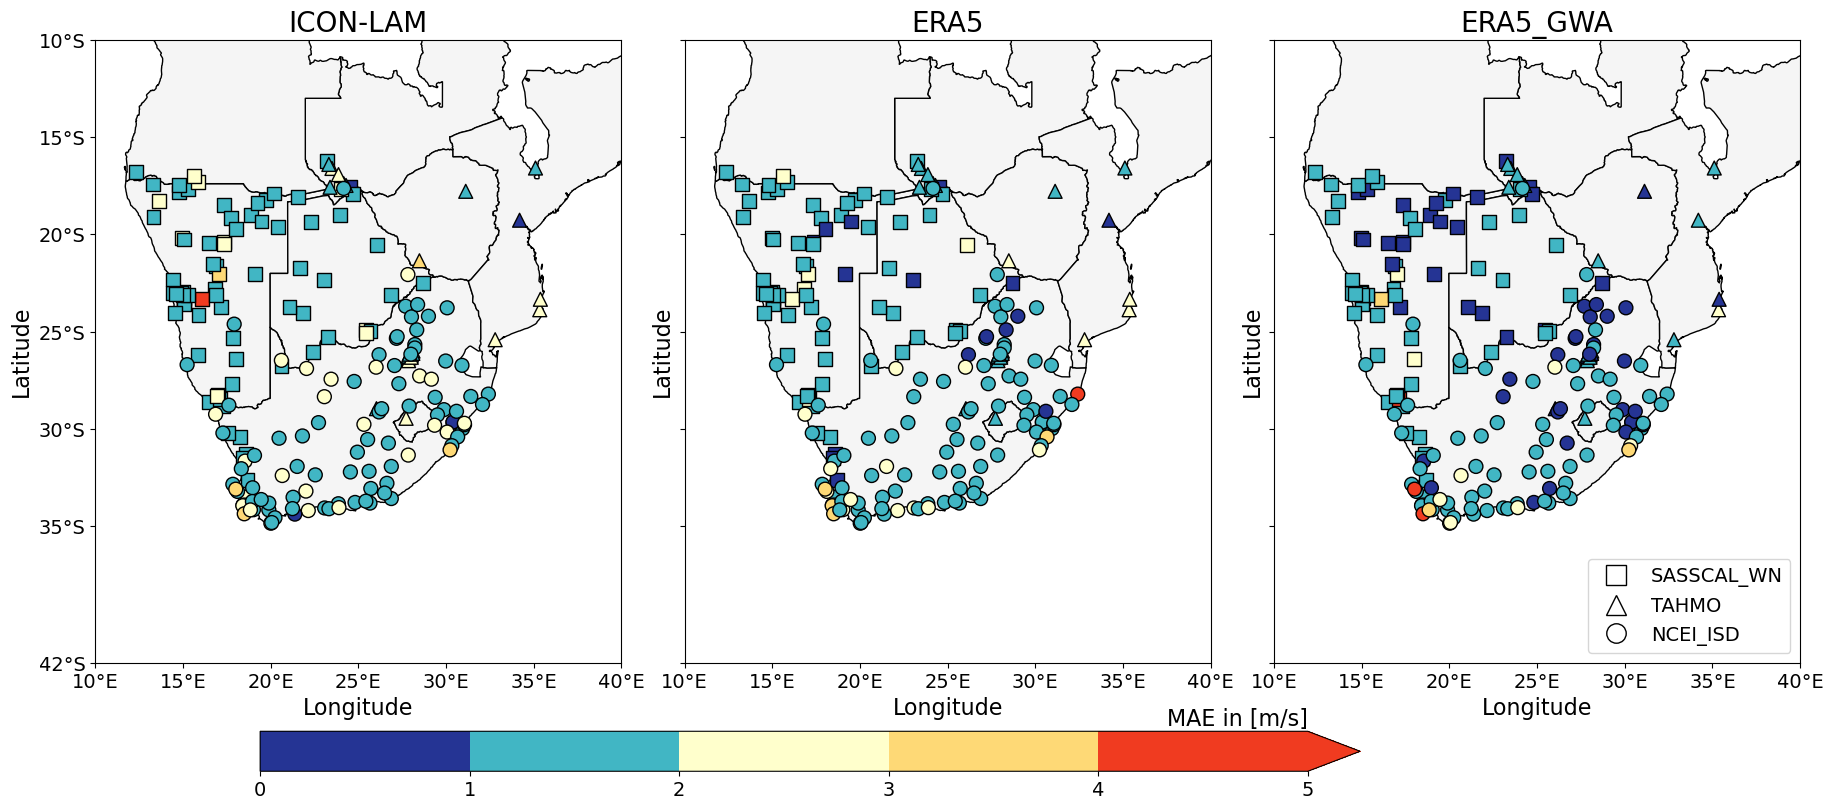

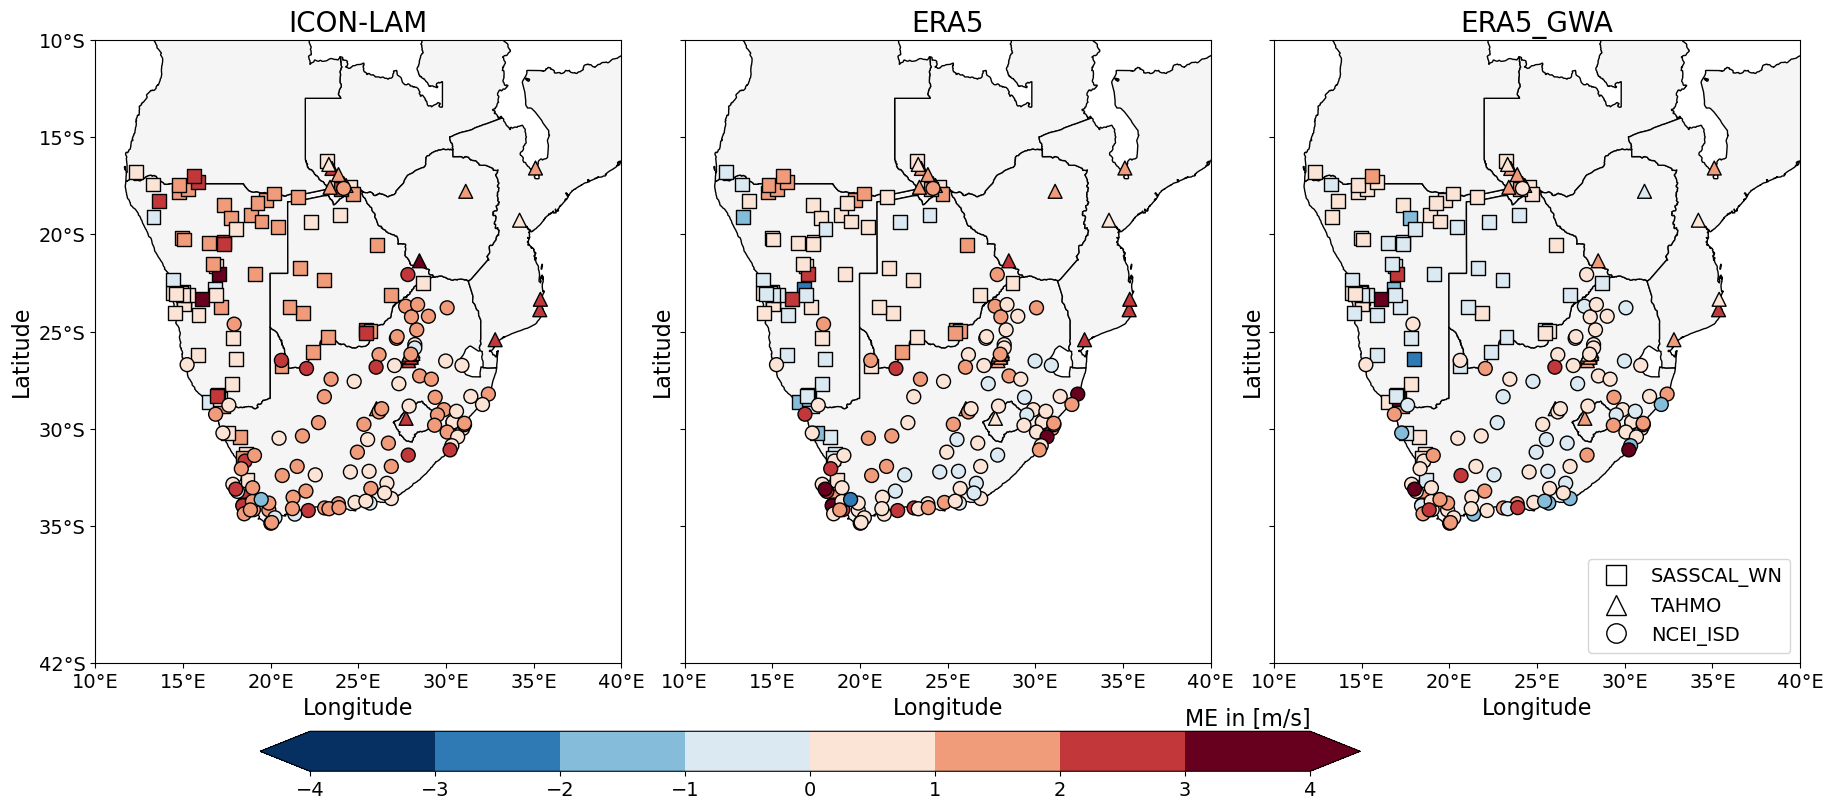

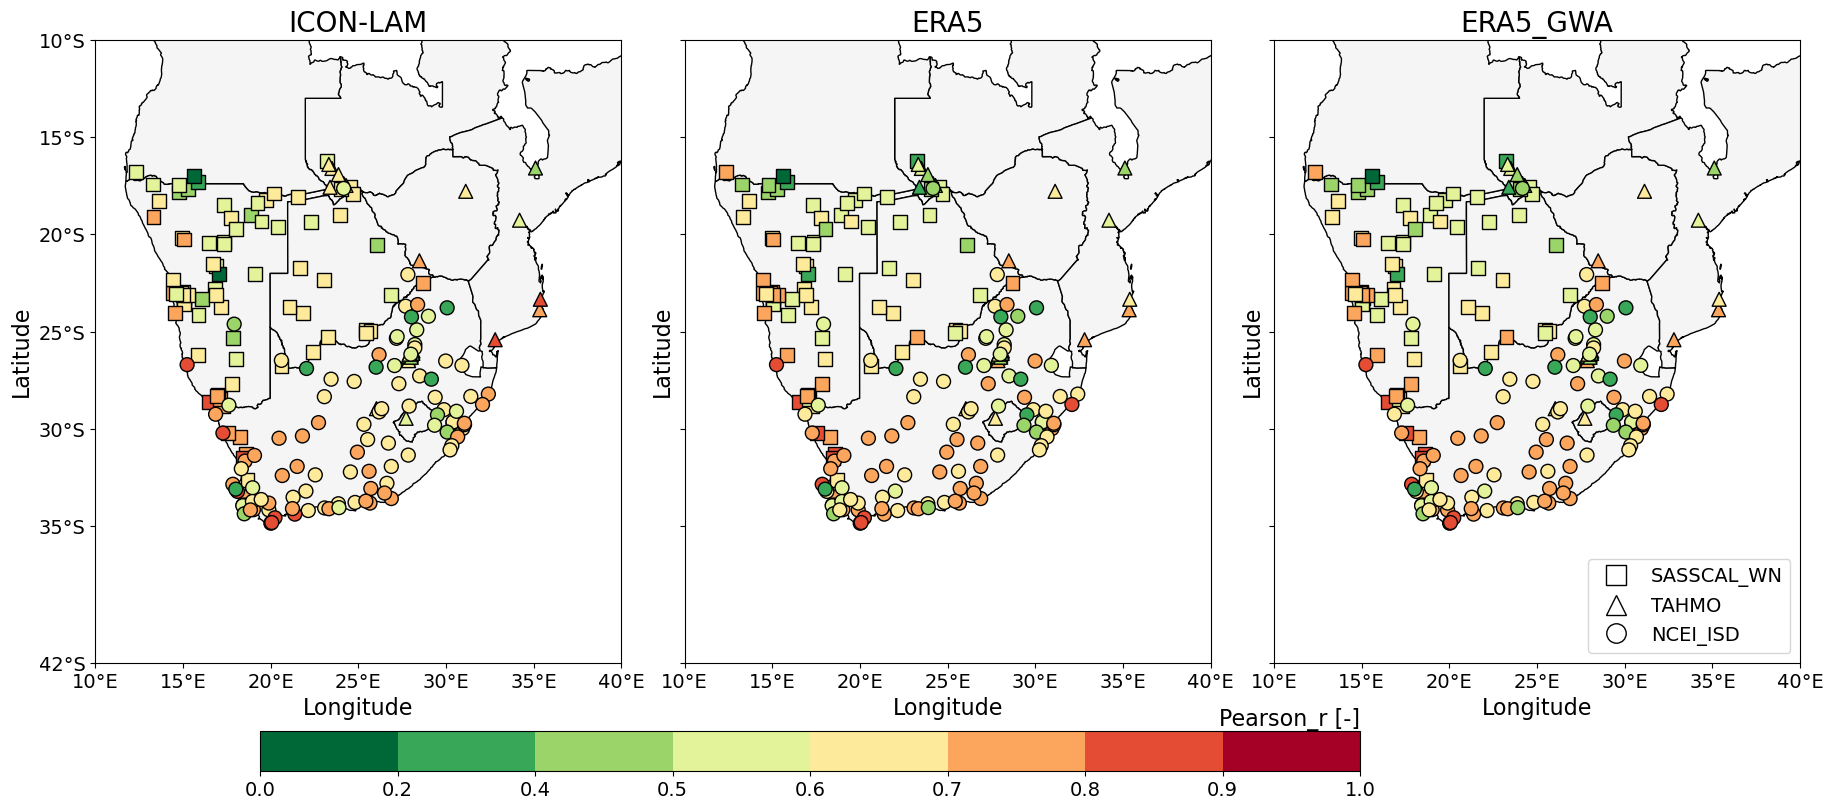

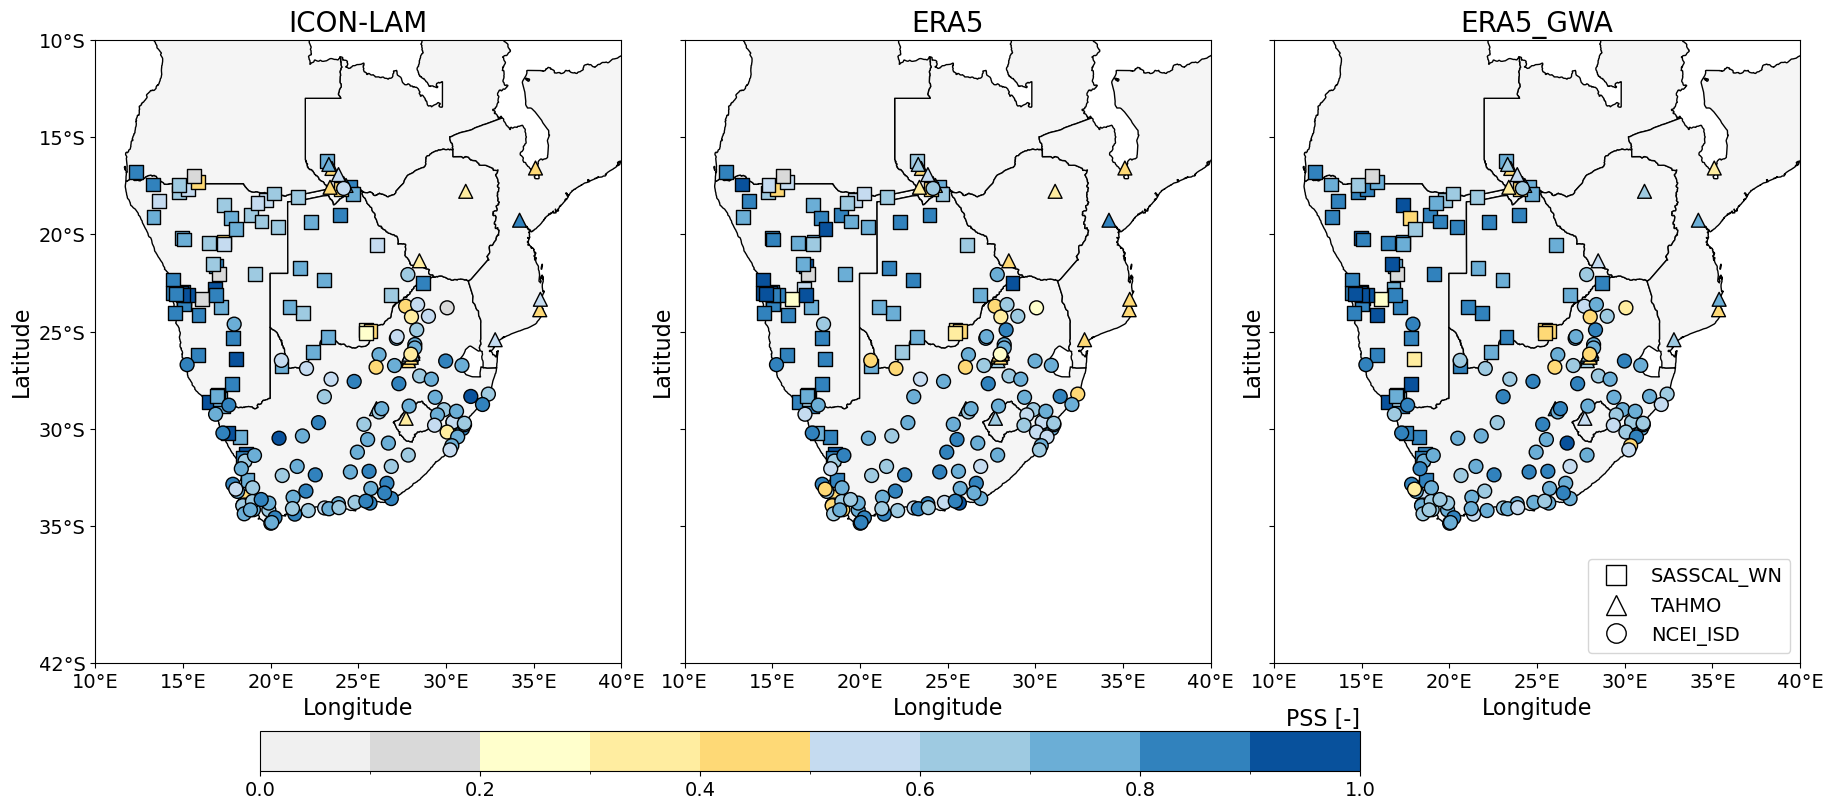

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.colors as mcolors

# === Chargement des données ===
metrics_files = {
    "ICON-LAM": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ICON_LAM_results.csv",
    "ERA5": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_results.csv",
    "ERA5_GWA": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_GWA_results.csv"
}
metrics_data = {name: pd.read_csv(path) for name, path in metrics_files.items()}

# Dictionnaire de renommage des labels
label_rename = {
    "SASSCALWN": "SASSCAL_WN",
    "TAHMO": "TAHMO",
    "NCEI": "NCEI_ISD"
}

# Appliquer le renommage à chaque DataFrame
for name in metrics_data:
    metrics_data[name]["label"] = metrics_data[name]["label"].replace(label_rename)

    
station_shapes = {"SASSCAL_WN": "s", "TAHMO": "^", "NCEI_ISD": "o"}

world = gpd.read_file("https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip")
africa_south = world[world["NAME"].isin([
    "South Africa", "Namibia", "Botswana", "Zimbabwe", "Mozambique",
    "Angola", "Lesotho", "Eswatini", "Zambia"
])]

# === Métrique ciblée
metric = "MAE"
title = "Mean Absolute Error (MAE)"
# Plages de valeurs
bounds = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
n_colors = len(bounds) - 1

# Couleurs correspondantes (autant que d'intervalles)
custom_colors = ['#253494', '#41b6c4', '#ffffcc',
                 '#fed976', '#f03b20', '#bd0026'][:n_colors]

# Colormap personnalisée
cmap = mcolors.ListedColormap(custom_colors)

# === Récupérer toutes les valeurs (pour une échelle cohérente)
all_values = []


for df in metrics_data.values():
    all_values.extend(df[metric].dropna().values)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === Création des sous-cartes
fig, axes = plt.subplots(1, 3, figsize=(22, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.12, bottom=0.4, top=0.98)

for ax, (name, df) in zip(axes, metrics_data.items()):
    africa_south.plot(ax=ax, color="whitesmoke", edgecolor="black")
    for label, shape in station_shapes.items():
        subset = df[df["label"] == label]
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset[metric], cmap=cmap, norm=norm,
            s=100, marker=shape, edgecolor="black"
        )
        # 🔁 Graduation personnalisée pour latitude
    lat_ticks = [-42, -35, -30, -25, -20, -15, -10]  # Valeurs en °S
    lat_labels = [f"{abs(val)}°S" for val in lat_ticks]
        # 🔁 Graduation personnalisée pour longitude
    lon_ticks = [10, 15, 20, 25, 30, 35, 40]  # Valeurs en °E
    lon_labels = [f"{val}°E" for val in lon_ticks]

    
    ax.set_title(f"{name}", fontsize=20)
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels(lon_labels, fontsize=14)
    ax.set_yticklabels(lat_labels, fontsize=14)
    # Limiter l'affichage à la zone géographique ciblée
    ax.set_xlim(min(lon_ticks), max(lon_ticks))
    ax.set_ylim(min(lat_ticks), max(lat_ticks))
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

# ✅ Barre de couleurs
cbar_ax = fig.add_axes([0.2, 0.48, 0.5, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label("MAE in [m/s]", loc='right', fontsize=16)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.tick_params(labelsize=14)  # ou 16, 18 selon ton besoin

    # 🔹 Légende des réseaux
    
legend_elements = [plt.Line2D([0], [0], marker=station_shapes[lab], color='black',
                                  linestyle='None', label=lab, markersize=14,
                                  markerfacecolor='white', markeredgecolor='black')
                       for lab in station_shapes]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=14)


# Sauvegarde
save_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\Compared_Dataset_MAE_10m.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()





# === Métrique ciblée
metric = "ME"
title = "Mean  Error (ME)"
# Plages de valeurs
bounds = [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0,]
n_colors = len(bounds) - 1

# Couleurs correspondantes (autant que d'intervalles)
custom_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#ffffcc',
                 '#fed976', '#feb24c', '#f03b20', '#bd0026'][:n_colors]
# Colormap personnalisée
cmap = plt.get_cmap('RdBu_r')

# === Récupérer toutes les valeurs (pour une échelle cohérente)
all_values = []


for df in metrics_data.values():
    all_values.extend(df[metric].dropna().values)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === Création des sous-cartes
fig, axes = plt.subplots(1, 3, figsize=(22, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.12, bottom=0.4, top=0.98)

for ax, (name, df) in zip(axes, metrics_data.items()):
    africa_south.plot(ax=ax, color="whitesmoke", edgecolor="black")
    for label, shape in station_shapes.items():
        subset = df[df["label"] == label]
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset[metric], cmap=cmap, norm=norm,
            s=100, marker=shape, edgecolor="black"
        )
        # 🔁 Graduation personnalisée pour latitude
    lat_ticks = [-42, -35, -30, -25, -20, -15, -10]  # Valeurs en °S
    lat_labels = [f"{abs(val)}°S" for val in lat_ticks]
        # 🔁 Graduation personnalisée pour longitude
    lon_ticks = [10, 15, 20, 25, 30, 35, 40]  # Valeurs en °E
    lon_labels = [f"{val}°E" for val in lon_ticks]

    
    ax.set_title(f"{name}", fontsize=20)
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels(lon_labels, fontsize=14)
    ax.set_yticklabels(lat_labels, fontsize=14)
    # Limiter l'affichage à la zone géographique ciblée
    ax.set_xlim(min(lon_ticks), max(lon_ticks))
    ax.set_ylim(min(lat_ticks), max(lat_ticks))
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

# ✅ Barre de couleurs
cbar_ax = fig.add_axes([0.2, 0.48, 0.5, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal', extend = 'both')
cbar.set_label("ME in [m/s]", loc='right', fontsize=16)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.tick_params(labelsize=14)  # ou 16, 18 selon ton besoin




    # 🔹 Légende des réseaux
legend_elements = [plt.Line2D([0], [0], marker=station_shapes[lab], color='black',
                                  linestyle='None', label=lab, markersize=14,
                                  markerfacecolor='white', markeredgecolor='black')
                       for lab in station_shapes]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=14)


# Sauvegarde
save_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\Compared_Dataset_ME_10m.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()




# === Métrique ciblée
metric = "Pearson r"
title = "Pearson Correlation (r)"
# Plages de valeurs
bounds = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_colors = len(bounds) - 1

# Couleurs correspondantes (autant que d'intervalles)
custom_colors = ['#bd0026', '#f03b20', '#feb24c', '#fed976', '#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494'][:n_colors]

cmap = plt.get_cmap('RdYlGn_r')

# === Récupérer toutes les valeurs (pour une échelle cohérente)
all_values = []


for df in metrics_data.values():
    all_values.extend(df[metric].dropna().values)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === Création des sous-cartes
fig, axes = plt.subplots(1, 3, figsize=(22, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.12, bottom=0.4, top=0.98)

for ax, (name, df) in zip(axes, metrics_data.items()):
    africa_south.plot(ax=ax, color="whitesmoke", edgecolor="black")
    for label, shape in station_shapes.items():
        subset = df[df["label"] == label]
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset[metric], cmap=cmap, norm=norm,
            s=100, marker=shape, edgecolor="black"
        )
        # 🔁 Graduation personnalisée pour latitude
    lat_ticks = [-42, -35, -30, -25, -20, -15, -10]  # Valeurs en °S
    lat_labels = [f"{abs(val)}°S" for val in lat_ticks]
        # 🔁 Graduation personnalisée pour longitude
    lon_ticks = [10, 15, 20, 25, 30, 35, 40]  # Valeurs en °E
    lon_labels = [f"{val}°E" for val in lon_ticks]

    
    ax.set_title(f"{name}", fontsize=20)
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels(lon_labels, fontsize=14)
    ax.set_yticklabels(lat_labels, fontsize=14)
    # Limiter l'affichage à la zone géographique ciblée
    ax.set_xlim(min(lon_ticks), max(lon_ticks))
    ax.set_ylim(min(lat_ticks), max(lat_ticks))
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

# ✅ Barre de couleurs
cbar_ax = fig.add_axes([0.2, 0.48, 0.5, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal')
cbar.set_label("Pearson_r [-]", loc='right', fontsize=16)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.tick_params(labelsize=14)  # ou 16, 18 selon ton besoin




    # 🔹 Légende des réseaux
legend_elements = [plt.Line2D([0], [0], marker=station_shapes[lab], color='black',
                                  linestyle='None', label=lab, markersize=14,
                                  markerfacecolor='white', markeredgecolor='black')
                       for lab in station_shapes]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=14)


# Sauvegarde
save_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\Compared_Dataset_Pearson_r_10m.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()




# === Métrique ciblée
metric = "PSS"
title = "Perkins Skill Score (PSS)"
# Plages de valeurs
bounds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_colors = len(bounds) - 1

custom_colors = [
    '#f0f0f0',  # 0.0 : gris très clair
    '#d9d9d9',  # 0.1 : gris clair
    '#ffffcc',  # 0.2 : jaune pâle
    '#ffeda0',  # 0.3 : jaune doux
    '#fed976',  # 0.4 : jaune plus chaud
    '#c5dbf0',  # 0.5 : transition vers bleu clair
    '#9ecae1',  # 0.6 : bleu doux
    '#6baed6',  # 0.7 : bleu modéré
    '#3182bd',  # 0.8 : bleu foncé
    '#08519c'   # 0.9–1.0 : bleu profond
]

# Colormap personnalisée
cmap = mcolors.ListedColormap(custom_colors)

# === Récupérer toutes les valeurs (pour une échelle cohérente)
all_values = []


for df in metrics_data.values():
    all_values.extend(df[metric].dropna().values)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === Création des sous-cartes
fig, axes = plt.subplots(1, 3, figsize=(22, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.12, bottom=0.4, top=0.98)

for ax, (name, df) in zip(axes, metrics_data.items()):
    africa_south.plot(ax=ax, color="whitesmoke", edgecolor="black")
    for label, shape in station_shapes.items():
        subset = df[df["label"] == label]
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset[metric], cmap=cmap, norm=norm,
            s=100, marker=shape, edgecolor="black"
        )
        # 🔁 Graduation personnalisée pour latitude
    lat_ticks = [-42, -35, -30, -25, -20, -15, -10]  # Valeurs en °S
    lat_labels = [f"{abs(val)}°S" for val in lat_ticks]
        # 🔁 Graduation personnalisée pour longitude
    lon_ticks = [10, 15, 20, 25, 30, 35, 40]  # Valeurs en °E
    lon_labels = [f"{val}°E" for val in lon_ticks]

    
    ax.set_title(f"{name}", fontsize=20)
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels(lon_labels, fontsize=14)
    ax.set_yticklabels(lat_labels, fontsize=14)
    # Limiter l'affichage à la zone géographique ciblée
    ax.set_xlim(min(lon_ticks), max(lon_ticks))
    ax.set_ylim(min(lat_ticks), max(lat_ticks))
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

# ✅ Barre de couleurs
cbar_ax = fig.add_axes([0.2, 0.48, 0.5, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal')
cbar.set_label("PSS [-]", loc='right', fontsize=16)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.tick_params(labelsize=14)  # ou 16, 18 selon ton besoin




    # 🔹 Légende des réseaux
legend_elements = [plt.Line2D([0], [0], marker=station_shapes[lab], color='black',
                                  linestyle='None', label=lab, markersize=14,
                                  markerfacecolor='white', markeredgecolor='black')
                       for lab in station_shapes]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=14)


# Sauvegarde
save_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\Compared_Dataset_PSS_10m.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


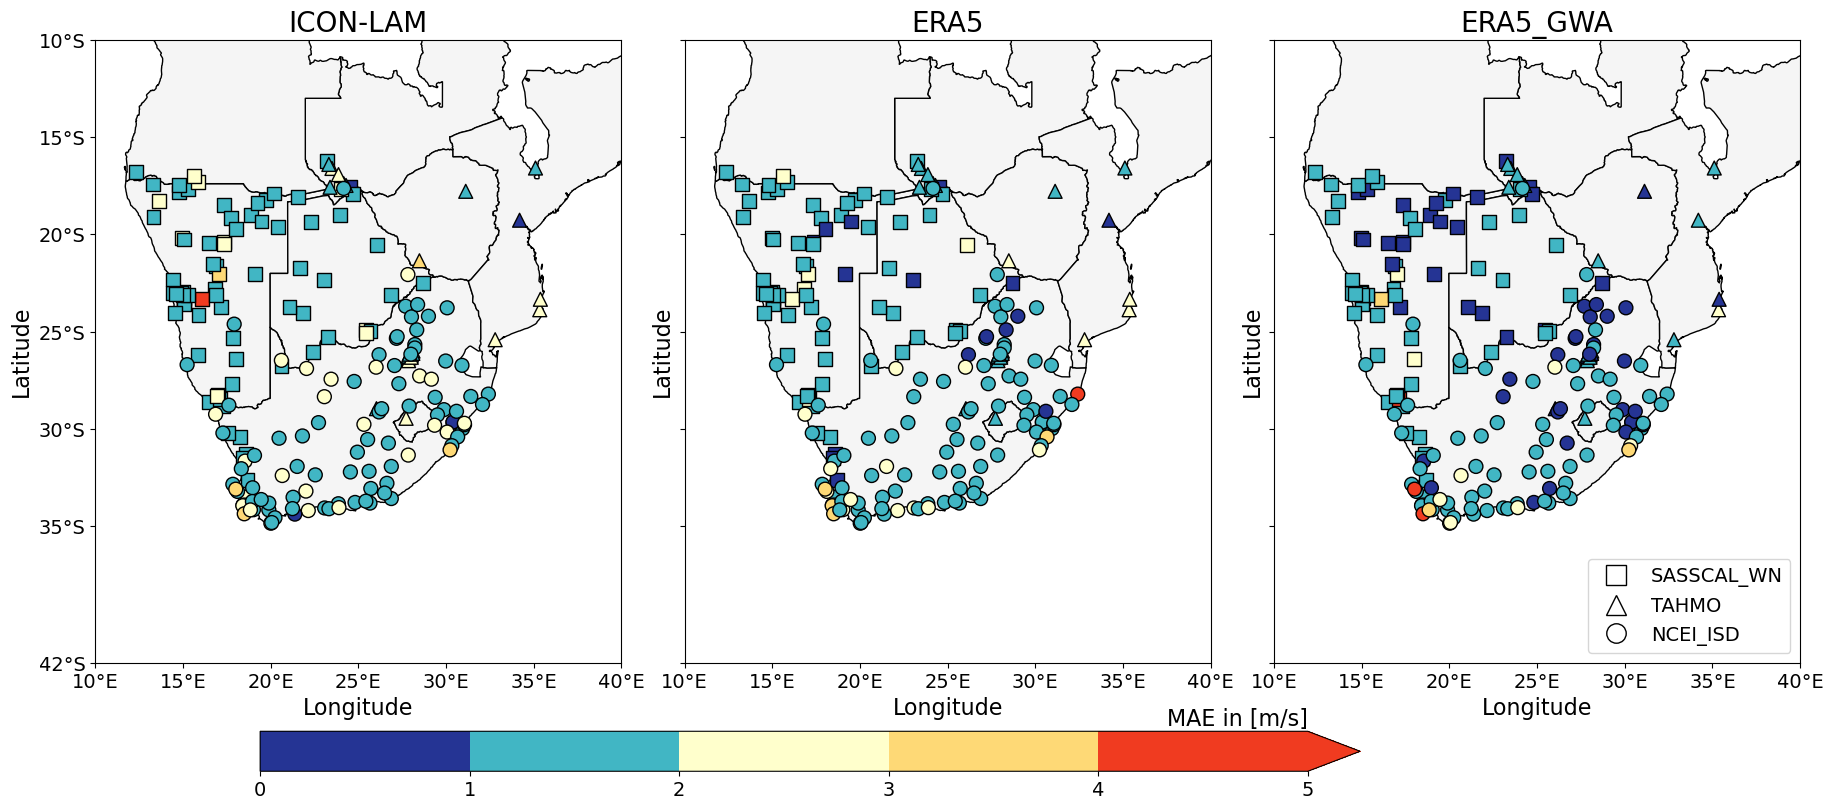

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.colors as mcolors

# === Chargement des données ===
metrics_files = {
    "ICON-LAM": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ICON_LAM_results.csv",
    "ERA5": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_results.csv",
    "ERA5_GWA": r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\metrics_10m_ERA5_GWA_results.csv"
}
metrics_data = {name: pd.read_csv(path) for name, path in metrics_files.items()}

# Dictionnaire de renommage des labels
label_rename = {
    "SASSCALWN": "SASSCAL_WN",
    "TAHMO": "TAHMO",
    "NCEI": "NCEI_ISD"
}

# Appliquer le renommage à chaque DataFrame
for name in metrics_data:
    metrics_data[name]["label"] = metrics_data[name]["label"].replace(label_rename)

    
station_shapes = {"SASSCAL_WN": "s", "TAHMO": "^", "NCEI_ISD": "o"}
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip")
africa_south = world[world["NAME"].isin([
    "South Africa", "Namibia", "Botswana", "Zimbabwe", "Mozambique",
    "Angola", "Lesotho", "Eswatini", "Zambia"
])]

# === Métrique ciblée
metric = "MAE"
title = "Mean Absolute Error (MAE)"
# Plages de valeurs
bounds = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
n_colors = len(bounds) - 1

# Couleurs correspondantes (autant que d'intervalles)
custom_colors = ['#253494', '#41b6c4', '#ffffcc',
                 '#fed976', '#f03b20', '#bd0026'][:n_colors]

# Colormap personnalisée
cmap = mcolors.ListedColormap(custom_colors)

# === Récupérer toutes les valeurs (pour une échelle cohérente)
all_values = []


for df in metrics_data.values():
    all_values.extend(df[metric].dropna().values)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# === Création des sous-cartes
fig, axes = plt.subplots(1, 3, figsize=(22, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.12, bottom=0.4, top=0.98)

for ax, (name, df) in zip(axes, metrics_data.items()):
    africa_south.plot(ax=ax, color="whitesmoke", edgecolor="black")
    for label, shape in station_shapes.items():
        subset = df[df["label"] == label]
        ax.scatter(
            subset["longitude"], subset["latitude"],
            c=subset[metric], cmap=cmap, norm=norm,
            s=100, marker=shape, edgecolor="black"
        )
        # 🔁 Graduation personnalisée pour latitude
    lat_ticks = [-42, -35, -30, -25, -20, -15, -10]  # Valeurs en °S
    lat_labels = [f"{abs(val)}°S" for val in lat_ticks]
        # 🔁 Graduation personnalisée pour longitude
    lon_ticks = [10, 15, 20, 25, 30, 35, 40]  # Valeurs en °E
    lon_labels = [f"{val}°E" for val in lon_ticks]

    
    ax.set_title(f"{name}", fontsize=20)
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels(lon_labels, fontsize=14)
    ax.set_yticklabels(lat_labels, fontsize=14)
    # Limiter l'affichage à la zone géographique ciblée
    ax.set_xlim(min(lon_ticks), max(lon_ticks))
    ax.set_ylim(min(lat_ticks), max(lat_ticks))
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

# ✅ Barre de couleurs
cbar_ax = fig.add_axes([0.2, 0.48, 0.5, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label("MAE in [m/s]", loc='right', fontsize=16)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.tick_params(labelsize=14)  # ou 16, 18 selon ton besoin

    # 🔹 Légende des réseaux
    
legend_elements = [plt.Line2D([0], [0], marker=station_shapes[lab], color='black',
                                  linestyle='None', label=lab, markersize=14,
                                  markerfacecolor='white', markeredgecolor='black')
                       for lab in station_shapes]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=14)

plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_order, rotation=20, fontsize=16)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

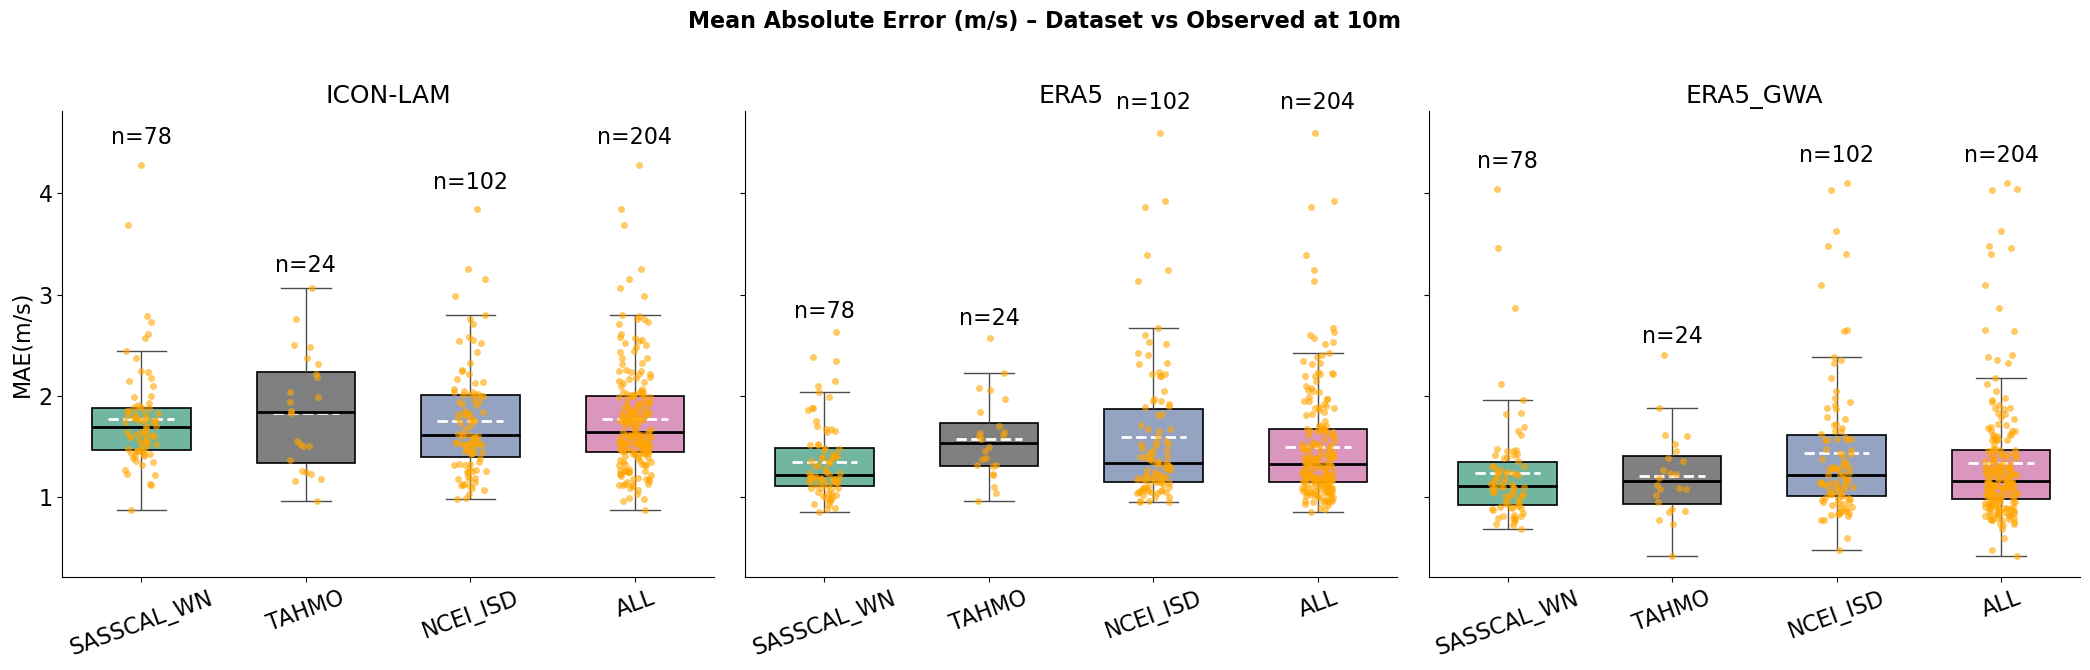

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_order, rotation=20, fontsize=16)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:143: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

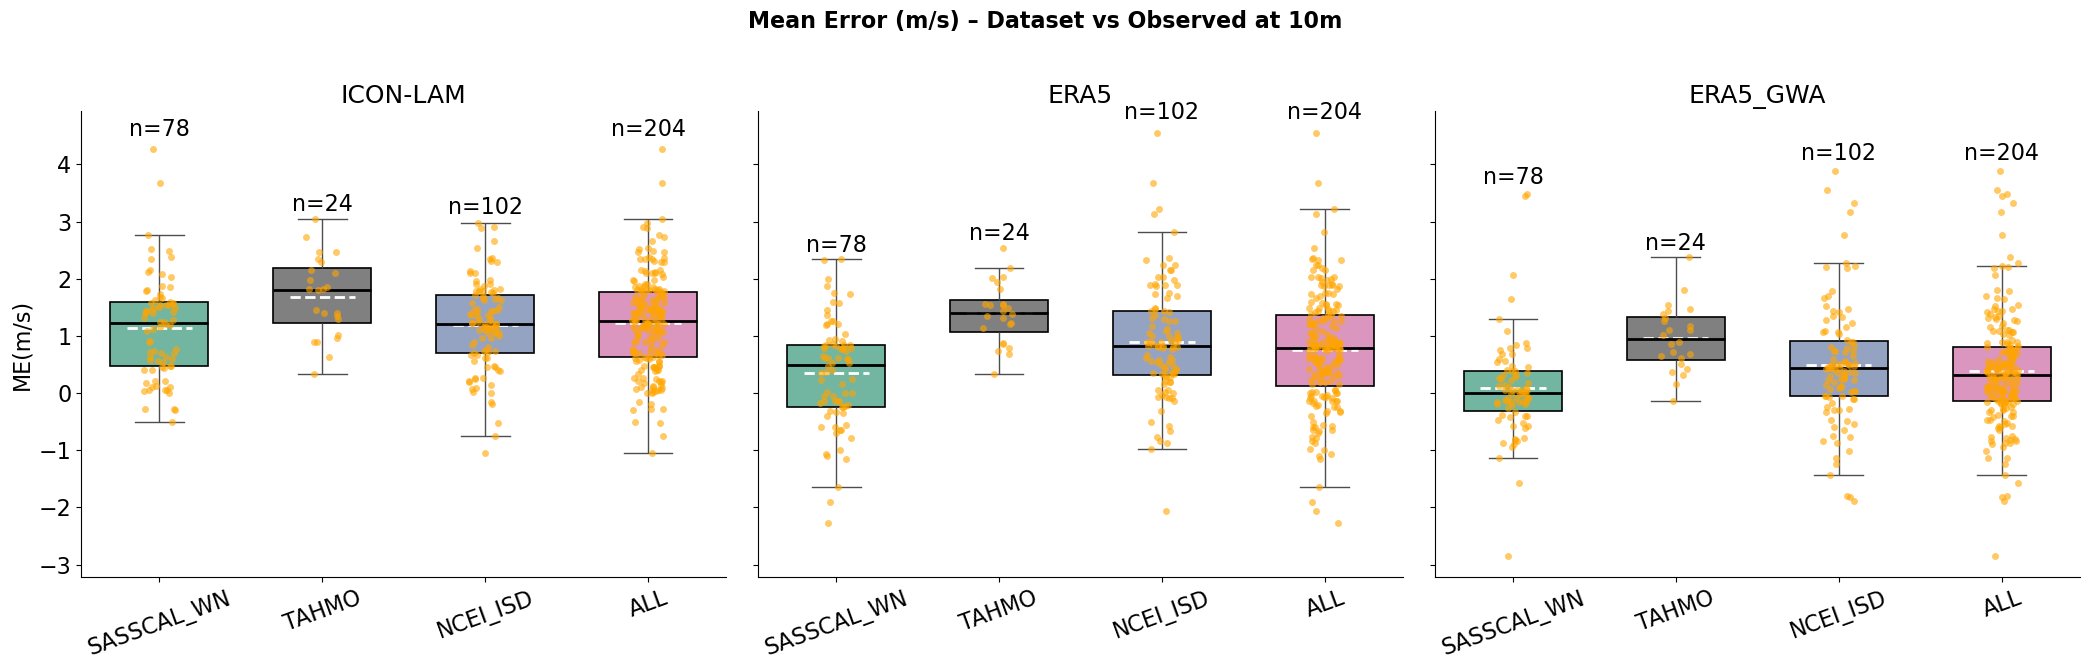

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:205: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_order, rotation=20, fontsize=16)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:205: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

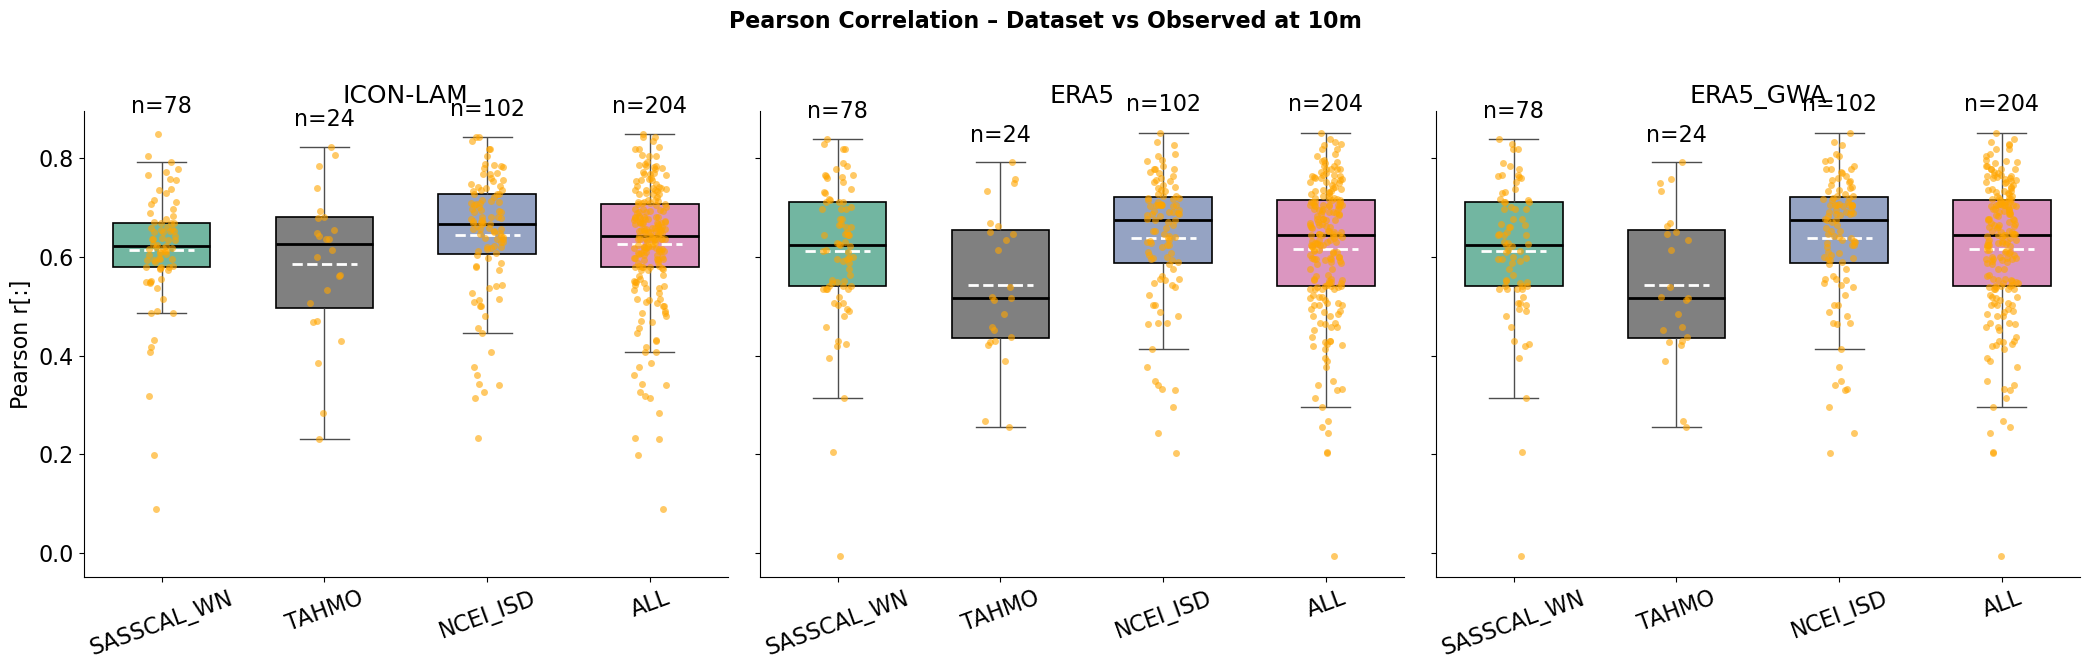

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_order, rotation=20, fontsize=16)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\1559481635.py:267: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

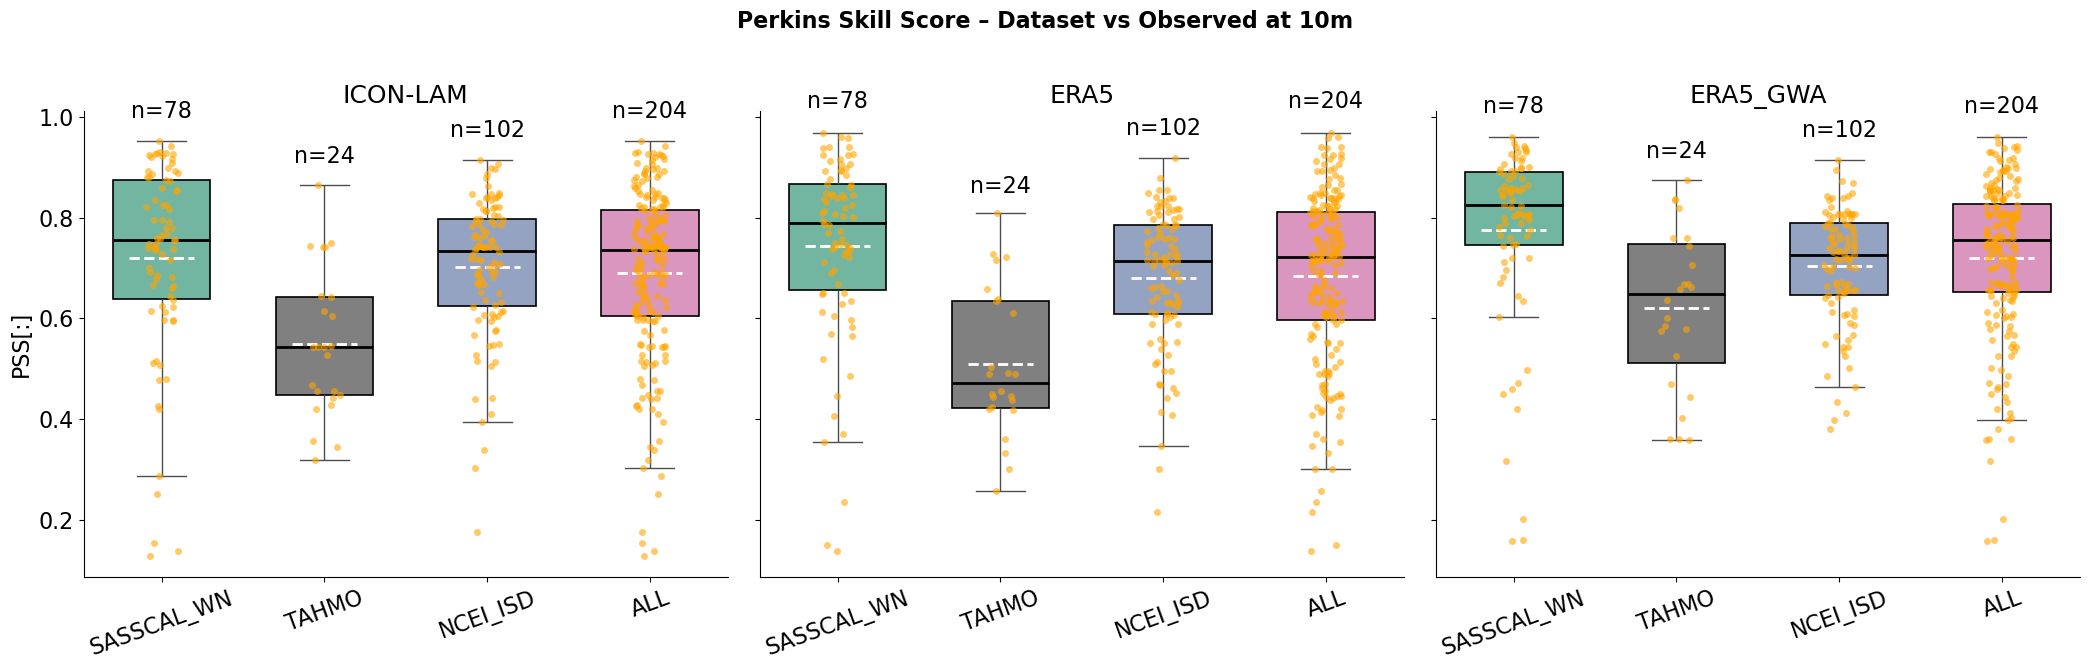

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🔧 Dictionnaire des datasets
datasets = {
    "ICON-LAM": metrics_ICON_df.copy(),
    "ERA5": metrics_ERA5_df.copy(),
    "ERA5_GWA": metrics_ERA5_GWA_df.copy()
}
# 🔧 Dictionnaire de renommage des labels
label_rename = {
    "SASSCALWN": "SASSCAL_WN",
    "TAHMO": "TAHMO",
    "NCEI": "NCEI_ISD"
}
for name in datasets:
    datasets[name]["label"] = datasets[name]["label"].replace(label_rename)


# 🔧 Palette et ordre
label_order = ["SASSCAL_WN", "TAHMO", "NCEI_ISD", "ALL"]
palette = {
    "SASSCAL_WN": "#66c2a5",
    "TAHMO": "gray",
    "NCEI_ISD": "#8da0cb",
    "ALL": "#e78ac3"
}

# 🔧 Métriques à tracer
metrics = {
    "MAE": "Mean Absolute Error (m/s)"
}

# 🔁 Boucle sur chaque métrique
for metric, metric_label in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    plt.suptitle(f"{metric_label} – Dataset vs Observed at 10m", fontsize=16, fontweight="bold")

    for ax, (ds_name, df) in zip(axes, datasets.items()):
        # 🔧 Ajouter catégorie ALL
        df_all = df.copy()
        df_all["label"] = "ALL"
        df_combined = pd.concat([df, df_all], ignore_index=True)

        # 📊 Boxplot
        sns.boxplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            palette=palette,
            showfliers=False,
            width=0.6,
            boxprops=dict(linewidth=1.2, edgecolor='black'),
            medianprops=dict(color="black", linewidth=2),
            ax=ax
        )

        # 📍 Points individuels
        sns.stripplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            color="orange", size=5, alpha=0.6,
            jitter=True,
            ax=ax
        )

        # 📍 Moyenne en ligne blanche pointillée + n
        for i, label in enumerate(label_order):
            vals = df_combined[df_combined["label"] == label][metric].dropna()
            if not vals.empty:
                mean_val = vals.mean()
                ax.hlines(mean_val, i - 0.2, i + 0.2, colors="white", linestyles="--", linewidth=2)
                ax.text(i, vals.max() + 0.05 * abs(vals.max()), f"n={len(vals)}", ha="center", fontsize=16)

        ax.set_title(ds_name, fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("MAE(m/s)", fontsize=16)
        ax.set_xticklabels(label_order, rotation=20, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"BoxPlot_GROUPED_10m_{metric.replace(' ', '_')}.png"
    save_path = rf"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\{filename}"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



# 🔧 Métriques à tracer
metrics = {
    "ME": "Mean Error (m/s)"
}

# 🔁 Boucle sur chaque métrique
for metric, metric_label in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    plt.suptitle(f"{metric_label} – Dataset vs Observed at 10m", fontsize=16, fontweight="bold")

    for ax, (ds_name, df) in zip(axes, datasets.items()):
        # 🔧 Ajouter catégorie ALL
        df_all = df.copy()
        df_all["label"] = "ALL"
        df_combined = pd.concat([df, df_all], ignore_index=True)

        # 📊 Boxplot
        sns.boxplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            palette=palette,
            showfliers=False,
            width=0.6,
            boxprops=dict(linewidth=1.2, edgecolor='black'),
            medianprops=dict(color="black", linewidth=2),
            ax=ax
        )

        # 📍 Points individuels
        sns.stripplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            color="orange", size=5, alpha=0.6,
            jitter=True,
            ax=ax
        )

        # 📍 Moyenne en ligne blanche pointillée + n
        for i, label in enumerate(label_order):
            vals = df_combined[df_combined["label"] == label][metric].dropna()
            if not vals.empty:
                mean_val = vals.mean()
                ax.hlines(mean_val, i - 0.2, i + 0.2, colors="white", linestyles="--", linewidth=2)
                ax.text(i, vals.max() + 0.05 * abs(vals.max()), f"n={len(vals)}", ha="center", fontsize=16)

        ax.set_title(ds_name, fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("ME(m/s)", fontsize=16)
        ax.set_xticklabels(label_order, rotation=20, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"BoxPlot_GROUPED_10m_{metric.replace(' ', '_')}.png"
    save_path = rf"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\{filename}"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



# 🔧 Métriques à tracer
metrics = {
    "Pearson r": "Pearson Correlation"
}

# 🔁 Boucle sur chaque métrique
for metric, metric_label in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    plt.suptitle(f"{metric_label} – Dataset vs Observed at 10m", fontsize=16, fontweight="bold")

    for ax, (ds_name, df) in zip(axes, datasets.items()):
        # 🔧 Ajouter catégorie ALL
        df_all = df.copy()
        df_all["label"] = "ALL"
        df_combined = pd.concat([df, df_all], ignore_index=True)

        # 📊 Boxplot
        sns.boxplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            palette=palette,
            showfliers=False,
            width=0.6,
            boxprops=dict(linewidth=1.2, edgecolor='black'),
            medianprops=dict(color="black", linewidth=2),
            ax=ax
        )

        # 📍 Points individuels
        sns.stripplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            color="orange", size=5, alpha=0.6,
            jitter=True,
            ax=ax
        )

        # 📍 Moyenne en ligne blanche pointillée + n
        for i, label in enumerate(label_order):
            vals = df_combined[df_combined["label"] == label][metric].dropna()
            if not vals.empty:
                mean_val = vals.mean()
                ax.hlines(mean_val, i - 0.2, i + 0.2, colors="white", linestyles="--", linewidth=2)
                ax.text(i, vals.max() + 0.05 * abs(vals.max()), f"n={len(vals)}", ha="center", fontsize=16)

        ax.set_title(ds_name, fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("Pearson r[:]", fontsize=16)
        ax.set_xticklabels(label_order, rotation=20, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"BoxPlot_GROUPED_10m_{metric.replace(' ', '_')}.png"
    save_path = rf"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\{filename}"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()



# 🔧 Métriques à tracer
metrics = {
    "PSS": "Perkins Skill Score"
}

# 🔁 Boucle sur chaque métrique
for metric, metric_label in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    plt.suptitle(f"{metric_label} – Dataset vs Observed at 10m", fontsize=16, fontweight="bold")

    for ax, (ds_name, df) in zip(axes, datasets.items()):
        # 🔧 Ajouter catégorie ALL
        df_all = df.copy()
        df_all["label"] = "ALL"
        df_combined = pd.concat([df, df_all], ignore_index=True)

        # 📊 Boxplot
        sns.boxplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            palette=palette,
            showfliers=False,
            width=0.6,
            boxprops=dict(linewidth=1.2, edgecolor='black'),
            medianprops=dict(color="black", linewidth=2),
            ax=ax
        )

        # 📍 Points individuels
        sns.stripplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            color="orange", size=5, alpha=0.6,
            jitter=True,
            ax=ax
        )

        # 📍 Moyenne en ligne blanche pointillée + n
        for i, label in enumerate(label_order):
            vals = df_combined[df_combined["label"] == label][metric].dropna()
            if not vals.empty:
                mean_val = vals.mean()
                ax.hlines(mean_val, i - 0.2, i + 0.2, colors="white", linestyles="--", linewidth=2)
                ax.text(i, vals.max() + 0.05 * abs(vals.max()), f"n={len(vals)}", ha="center", fontsize=16)

        ax.set_title(ds_name, fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("PSS[:]", fontsize=16)
        ax.set_xticklabels(label_order, rotation=20, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"BoxPlot_GROUPED_10m_{metric.replace(' ', '_')}.png"
    save_path = rf"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\10m\{filename}"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\2555164332.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\2555164332.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(label_order, rotation=20, fontsize=16)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\2555164332.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26800\2555164332.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

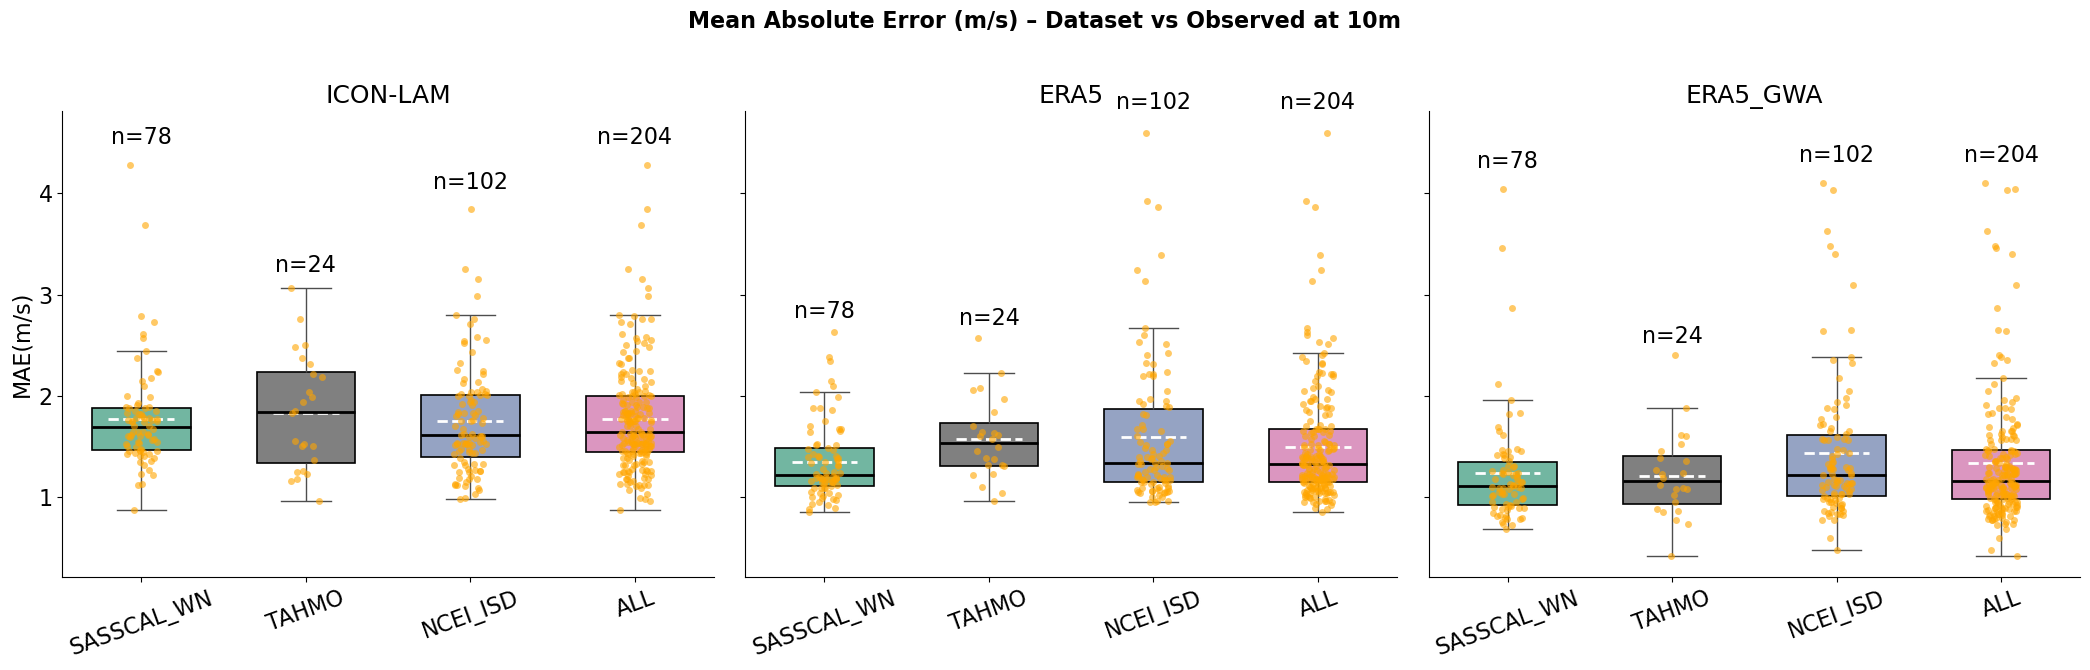

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🔧 Dictionnaire des datasets
datasets = {
    "ICON-LAM": metrics_ICON_df.copy(),
    "ERA5": metrics_ERA5_df.copy(),
    "ERA5_GWA": metrics_ERA5_GWA_df.copy()
}

# 🔧 Dictionnaire de renommage des labels
label_rename = {
    "SASSCALWN": "SASSCAL_WN",
    "TAHMO": "TAHMO",
    "NCEI": "NCEI_ISD"
}
for name in datasets:
    datasets[name]["label"] = datasets[name]["label"].replace(label_rename)


# 🔧 Palette et ordre
label_order = ["SASSCAL_WN", "TAHMO", "NCEI_ISD", "ALL"]
palette = {
    "SASSCAL_WN": "#66c2a5",
    "TAHMO": "gray",
    "NCEI_ISD": "#8da0cb",
    "ALL": "#e78ac3"
}

# 🔧 Métriques à tracer
metrics = {
    "MAE": "Mean Absolute Error (m/s)"
}

# 🔁 Boucle sur chaque métrique
for metric, metric_label in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    plt.suptitle(f"{metric_label} – Dataset vs Observed at 10m", fontsize=16, fontweight="bold")

    for ax, (ds_name, df) in zip(axes, datasets.items()):
        # 🔧 Ajouter catégorie ALL
        df_all = df.copy()
        df_all["label"] = "ALL"
        df_combined = pd.concat([df, df_all], ignore_index=True)

        # 📊 Boxplot
        sns.boxplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            palette=palette,
            showfliers=False,
            width=0.6,
            boxprops=dict(linewidth=1.2, edgecolor='black'),
            medianprops=dict(color="black", linewidth=2),
            ax=ax
        )

        # 📍 Points individuels
        sns.stripplot(
            data=df_combined,
            x="label", y=metric,
            order=label_order,
            color="orange", size=5, alpha=0.6,
            jitter=True,
            ax=ax
        )

        # 📍 Moyenne en ligne blanche pointillée + n
        for i, label in enumerate(label_order):
            vals = df_combined[df_combined["label"] == label][metric].dropna()
            if not vals.empty:
                mean_val = vals.mean()
                ax.hlines(mean_val, i - 0.2, i + 0.2, colors="white", linestyles="--", linewidth=2)
                ax.text(i, vals.max() + 0.05 * abs(vals.max()), f"n={len(vals)}", ha="center", fontsize=16)

        ax.set_title(ds_name, fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("MAE(m/s)", fontsize=16)
        ax.set_xticklabels(label_order, rotation=20, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [60]:
import pandas as pd

# 🔧 Dictionnaire des datasets
datasets = {
    "ICON-LAM": metrics_ICON_df.copy(),
    "ERA5": metrics_ERA5_df.copy(),
    "ERA5_GWA": metrics_ERA5_GWA_df.copy()
}

# 🔧 Labels et métriques d'intérêt
labels_of_interest = ["SASSCALWN", "NCEI", "TAHMO"]
metrics = ["MAE", "ME", "Pearson r", "PSS"]

# 📊 Liste pour stocker les résultats
quartile_records = []

for ds_name, df in datasets.items():
    for metric in metrics:
        # on s'assure que la colonne 'label' existe et qu'on ne travaille pas sur 'ALL'
        if "label" not in df.columns:
            raise KeyError(f"Le DataFrame {ds_name} n'a pas de colonne 'label'")
        for lbl in labels_of_interest:
            vals = df[df["label"] == lbl][metric].dropna()
            if vals.empty:
                continue

            # calcul des quartiles
            q25, q50, q75 = vals.quantile([0.25, 0.50, 0.75]).values
            count = len(vals)

            # stockage
            quartile_records.append({
                "Dataset": ds_name,
                "Label": lbl,
                "Metric": metric,
                "Q25": q25,
                "Q50": q50,
                "Q75": q75,
                "N": count
            })

# 🔁 Transformation en DataFrame
quartiles_df = pd.DataFrame(quartile_records)

# 🖨️ Affichage rapide
print("\nRésumé des quartiles (25%, 50%, 75%)\n")
print(quartiles_df)


Résumé des quartiles (25%, 50%, 75%)

     Dataset      Label     Metric       Q25       Q50       Q75    N
0   ICON-LAM  SASSCALWN        MAE  1.464165  1.685512  1.876814   78
1   ICON-LAM       NCEI        MAE  1.393326  1.607013  2.007524  102
2   ICON-LAM      TAHMO        MAE  1.334081  1.838696  2.236446   24
3   ICON-LAM  SASSCALWN         ME  0.466768  1.221807  1.592905   78
4   ICON-LAM       NCEI         ME  0.702150  1.209616  1.707154  102
5   ICON-LAM      TAHMO         ME  1.229508  1.810743  2.184593   24
6   ICON-LAM  SASSCALWN  Pearson r  0.579668  0.621727  0.669907   78
7   ICON-LAM       NCEI  Pearson r  0.605829  0.668040  0.727775  102
8   ICON-LAM      TAHMO  Pearson r  0.497157  0.625794  0.680531   24
9   ICON-LAM  SASSCALWN        PSS  0.637762  0.755601  0.874266   78
10  ICON-LAM       NCEI        PSS  0.623903  0.733874  0.798159  102
11  ICON-LAM      TAHMO        PSS  0.447011  0.542891  0.643117   24
12      ERA5  SASSCALWN        MAE  1.108242  1.213

In [6]:
# 🔹 Liste des DataFrames à traiter
metrics_dataset_dfs = {
    "ICON-LAM": metrics_ICON_df,
    "ERA5": metrics_ERA5_df,
    "ERA5_GWA": metrics_ERA5_GWA_df
}

# 🔹 Colonnes à moyenner
metric_columns = ["MAE", "ME", "Pearson r", "PSS"]

# 🔹 Initialiser un tableau de résultats
summary_means_dataset = pd.DataFrame(columns=metric_columns)

# 🔹 Calculer la moyenne pour chaque jeu de données
for name, df in metrics_dataset_dfs.items():
    summary_means_dataset.loc[name] = df[metric_columns].mean()

# 🔹 Afficher le résumé des moyennes
print("📊 Metric Average from each dataset  :")
print(summary_means_dataset)

# 🔹 Définir les quantiles que tu veux
quantiles = [0.10, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.70, 0.75, 0.80, 0.90, 0.95]

# 🔹 Colonnes des métriques
metrics = ["MAE", "ME", "Pearson r", "PSS"]

# 🔹 Calculer les quantiles globalement (sur toutes les stations)
quantile_ICON_df = metrics_ICON_df[metrics].quantile(quantiles)

# 🔹 Nettoyer l'affichage
quantile_ICON_df.index = [f"{int(q*100)}%" for q in quantiles]
quantile_ICON_df.index.name = "Quantile"

# 🔹 Afficher le tableau
print("📊 Quantiles globaux pour les métriques ICON-LAM :")
print(quantile_ICON_df)


# 🔹 Colonnes des métriques
metrics = ["MAE", "ME", "Pearson r", "PSS"]

# 🔹 Calculer les quantiles globalement (sur toutes les stations)
quantile_ERA5_df = metrics_ERA5_df[metrics].quantile(quantiles)

# 🔹 Nettoyer l'affichage
quantile_ERA5_df.index = [f"{int(q*100)}%" for q in quantiles]
quantile_ERA5_df.index.name = "Quantile"

# 🔹 Afficher le tableau
print("📊 Quantiles globaux pour les métriques ERA5 :")
print(quantile_ERA5_df)


# 🔹 Colonnes des métriques
metrics = ["MAE", "ME", "Pearson r", "PSS"]

# 🔹 Calculer les quantiles globalement (sur toutes les stations)
quantile_ERA5_GWA_df = metrics_ERA5_GWA_df[metrics].quantile(quantiles)

# 🔹 Nettoyer l'affichage
quantile_ERA5_GWA_df.index = [f"{int(q*100)}%" for q in quantiles]
quantile_ERA5_GWA_df.index.name = "Quantile"

# 🔹 Afficher le tableau
print("📊 Quantiles globaux pour les métriques ERA5_GWA :")
print(quantile_ERA5_GWA_df)


📊 Metric Average from each dataset  :
               MAE        ME  Pearson r       PSS
ICON-LAM  1.765903  1.229421   0.625941  0.690954
ERA5      1.495393  0.746089   0.617248  0.683888
ERA5_GWA  1.331601  0.391979   0.617248  0.720866
📊 Quantiles globaux pour les métriques ICON-LAM :
               MAE        ME  Pearson r       PSS
Quantile                                         
10%       1.216443  0.126485   0.469134  0.450724
20%       1.375456  0.470519   0.549893  0.559185
25%       1.437935  0.631393   0.579532  0.604977
30%       1.476013  0.733264   0.596934  0.624843
40%       1.544699  1.097122   0.620887  0.683381
50%       1.641027  1.263240   0.643172  0.735180
60%       1.782248  1.438764   0.665404  0.754590
70%       1.903764  1.636181   0.688926  0.792610
75%       1.996918  1.774901   0.707196  0.814538
80%       2.051775  1.825546   0.727498  0.834838
90%       2.469086  2.293218   0.769040  0.887061
95%       2.752791  2.519889   0.791989  0.916511
📊 Quantiles 

In [26]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading of the weather mast data of 18 station

Weather_mast_all = pd.read_pickle(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 4_5_6_7\mast_df.pkl")
target_columns_all = ['WS_10_mean', 'WS_20_mean', 'WS_40_mean', 'WS_60_mean']

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_18 = set(range(2487600, 2614608))
# Définir les plages à exclure
exclude_1_rows_18 = set(range(2491920, 2496240))     
exclude_2_rows_18 = set(range(2500704, 2505168)) 
exclude_3_rows_18 = set(range(2509632, 2514096))
exclude_4_rows_18 = set(range(2518128, 2522160))     
exclude_5_rows_18 = set(range(2526624, 2531088)) 
exclude_6_rows_18 = set(range(2535408, 2544048)) 
exclude_7_rows_18 = set(range(2548512, 2552976))     
exclude_8_rows_18 = set(range(2557296, 2561616)) 
exclude_9_rows_18 = set(range(2566080, 2570544))
exclude_10_rows_18 = set(range(2575008, 2579472))     
exclude_11_rows_18 = set(range(2583792, 2588112)) 
exclude_12_rows_18 = set(range(2592576, 2597040)) 
exclude_13_rows_18 = set(range(2601360, 2605680)) 
exclude_14_rows_18 = set(range(2610144, 2614608)) 
# Combiner toutes les exclusions
excluded_rows_18 = exclude_1_rows_18.union(exclude_2_rows_18).union(exclude_3_rows_18).union(exclude_4_rows_18).union(exclude_5_rows_18).union(exclude_6_rows_18).union(exclude_7_rows_18).union(exclude_8_rows_18).union(exclude_9_rows_18).union(exclude_10_rows_18).union(exclude_11_rows_18).union(exclude_12_rows_18).union(exclude_13_rows_18).union(exclude_14_rows_18)
# Soustraire les lignes exclues
final_rows_18 = sorted(all_rows_18 - excluded_rows_18)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_18_local = Weather_mast_all.iloc[final_rows_18][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_19 = set(range(2614608, 2759471))
# Définir les plages à exclure
exclude_1_rows_19 = set(range(2619072, 2623536))     
exclude_2_rows_19 = set(range(2627856, 2632176)) 
exclude_3_rows_19 = set(range(2636640, 2641104))
exclude_4_rows_19 = set(range(2645568, 2650032))     
exclude_5_rows_19 = set(range(2654064, 2658096)) 
exclude_6_rows_19 = set(range(2662560, 2667024)) 
exclude_7_rows_19 = set(range(2671344, 2679984))     
exclude_8_rows_19 = set(range(2684448, 2688912)) 
exclude_9_rows_19 = set(range(2693232, 2697552))
exclude_10_rows_19 = set(range(2702016, 2710944))     
exclude_11_rows_19 = set(range(2715408, 2719872)) 
exclude_12_rows_19 = set(range(2724192, 2728512)) 
exclude_13_rows_19 = set(range(2732976, 2741904)) 
exclude_14_rows_19 = set(range(2746224, 2750544)) 
exclude_15_rows_19 = set(range(2755008, 2759472))
# Combiner toutes les exclusions
excluded_rows_19 = exclude_1_rows_19.union(exclude_2_rows_19).union(exclude_3_rows_19).union(exclude_4_rows_19).union(exclude_5_rows_19).union(exclude_6_rows_19).union(exclude_7_rows_19).union(exclude_8_rows_19).union(exclude_9_rows_19).union(exclude_10_rows_19).union(exclude_11_rows_19).union(exclude_12_rows_19).union(exclude_13_rows_19).union(exclude_14_rows_19).union(exclude_15_rows_19)
# Soustraire les lignes exclues
final_rows_19 = sorted(all_rows_19 - excluded_rows_19)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_19_local = Weather_mast_all.iloc[final_rows_19][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_17 = set(range(2343024, 2487600))
# Définir les plages à exclure
exclude_1_rows_17 = set(range(2347344, 2351664))     
exclude_2_rows_17 = set(range(2356128, 2360592)) 
exclude_3_rows_17 = set(range(2365056, 2369520))
exclude_4_rows_17 = set(range(2373552, 2377584))     
exclude_5_rows_17 = set(range(2382048, 2386512)) 
exclude_6_rows_17 = set(range(2390832, 2399472)) 
exclude_7_rows_17 = set(range(2403936, 2408400))     
exclude_8_rows_17 = set(range(2412720, 2421360)) 
exclude_9_rows_17 = set(range(2425824, 2434752))
exclude_10_rows_17 = set(range(2439216, 2448144))     
exclude_11_rows_17 = set(range(2452464, 2461104)) 
exclude_12_rows_17 = set(range(2465568, 2470032)) 
exclude_13_rows_17 = set(range(2474352, 2478672)) 
exclude_14_rows_17 = set(range(2483136, 2487600)) 
# Combiner toutes les exclusions
excluded_rows_17 = exclude_1_rows_17.union(exclude_2_rows_17).union(exclude_3_rows_17).union(exclude_4_rows_17).union(exclude_5_rows_17).union(exclude_6_rows_17).union(exclude_7_rows_17).union(exclude_8_rows_17).union(exclude_9_rows_17).union(exclude_10_rows_17).union(exclude_11_rows_17).union(exclude_12_rows_17).union(exclude_13_rows_17).union(exclude_14_rows_17)
# Soustraire les lignes exclues
final_rows_17 = sorted(all_rows_17 - excluded_rows_17)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_17_local = Weather_mast_all.iloc[final_rows_17][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_16 = set(range(2154528, 2343024))
# Définir les plages à exclure
exclude_1_rows_16 = set(range(2158992, 2167920))     
exclude_2_rows_16 = set(range(2172240, 2180880)) 
exclude_3_rows_16 = set(range(2185344, 2194272))
exclude_4_rows_16 = set(range(2198736, 2207664))     
exclude_5_rows_16 = set(range(2211696, 2219760)) 
exclude_6_rows_16 = set(range(2224224, 2233152)) 
exclude_7_rows_16 = set(range(2237472, 2250432))     
exclude_8_rows_16 = set(range(2254896, 2263824)) 
exclude_9_rows_16 = set(range(2268144, 2276784))
exclude_10_rows_16 = set(range(2281248, 2290176))     
exclude_11_rows_16 = set(range(2294640, 2303568)) 
exclude_12_rows_16 = set(range(2307888, 2316528)) 
exclude_13_rows_16 = set(range(2320992, 2325456)) 
exclude_14_rows_16 = set(range(2329776, 2334096)) 
exclude_15_rows_16 = set(range(2338560, 2343024))
# Combiner toutes les exclusions
excluded_rows_16 = exclude_1_rows_16.union(exclude_2_rows_16).union(exclude_3_rows_16).union(exclude_4_rows_16).union(exclude_5_rows_16).union(exclude_6_rows_16).union(exclude_7_rows_16).union(exclude_8_rows_16).union(exclude_9_rows_16).union(exclude_10_rows_16).union(exclude_11_rows_16).union(exclude_12_rows_16).union(exclude_13_rows_16).union(exclude_14_rows_16).union(exclude_15_rows_16)
# Soustraire les lignes exclues
final_rows_16 = sorted(all_rows_16 - excluded_rows_16)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_16_local = Weather_mast_all.iloc[final_rows_16][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_15 = set(range(1992528, 2154528))
# Définir les plages à exclure
exclude_1_rows_15 = set(range(2031840, 2036160))  
excluded_rows_15 = exclude_1_rows_15
# Soustraire les lignes exclues
final_rows_15 = sorted(all_rows_15 - excluded_rows_15)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_15_local = Weather_mast_all.iloc[final_rows_15][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_14 = set(range(1839312, 1992528))
# Définir les plages à exclure
exclude_1_rows_14 = set(range(1878624, 1882944))  
excluded_rows_14 = exclude_1_rows_14
# Soustraire les lignes exclues
final_rows_14 = sorted(all_rows_14 - excluded_rows_14)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_14_local = Weather_mast_all.iloc[final_rows_14][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_13 = set(range(1677312, 1839312))
# Définir les plages à exclure
exclude_1_rows_13 = set(range(1716624, 1720944))  
excluded_rows_13 = exclude_1_rows_13
# Soustraire les lignes exclues
final_rows_13 = sorted(all_rows_13 - excluded_rows_13)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_13_local = Weather_mast_all.iloc[final_rows_13][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_12 = set(range(1510848, 1677312))
# Définir les plages à exclure
exclude_1_rows_12 = set(range(1550160, 1554480))  
exclude_2_rows_12 = set(range(1598256, 1602720))
excluded_rows_12 = exclude_1_rows_12.union(exclude_2_rows_12)
# Soustraire les lignes exclues
final_rows_12 = sorted(all_rows_12 - excluded_rows_12)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_12_local = Weather_mast_all.iloc[final_rows_12][target_columns_all]

# Création de la plage initiale (lignes 1 à 1000 → indices 0 à 999)
all_rows_11 = set(range(1353168, 1510848))
# Définir les plages à exclure
exclude_1_rows_11 = set(range(1436256, 1440720))  
excluded_rows_11 = exclude_1_rows_11
# Soustraire les lignes exclues
final_rows_11 = sorted(all_rows_11 - excluded_rows_11)
# Extraire les lignes depuis le DataFrame (remplace `df` par ton nom réel)
Weather_mast_11_local = Weather_mast_all.iloc[final_rows_11][target_columns_all]

Weather_mast_01 = Weather_mast_all.iloc[0:109440][target_columns_all]
Weather_mast_01 = Weather_mast_01.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_02 = Weather_mast_all.iloc[109440:267120][target_columns_all]
Weather_mast_02 = Weather_mast_02.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_03 = Weather_mast_all.iloc[267120:424800][target_columns_all]
Weather_mast_03 = Weather_mast_03.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_05 = Weather_mast_all.iloc[424800:582480][target_columns_all]
Weather_mast_05 = Weather_mast_05.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_06 = Weather_mast_all.iloc[582480:740160][target_columns_all]
Weather_mast_06 = Weather_mast_06.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_07 = Weather_mast_all.iloc[740160:897840][target_columns_all]
Weather_mast_07 = Weather_mast_07.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_08 = Weather_mast_all.iloc[897840:1037808][target_columns_all]
Weather_mast_08 = Weather_mast_08.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_09 = Weather_mast_all.iloc[1037808:1195488][target_columns_all]
Weather_mast_09 = Weather_mast_09.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_10 = Weather_mast_all.iloc[1195488:1353168][target_columns_all]
Weather_mast_10 = Weather_mast_10.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_11 = Weather_mast_11_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_12 = Weather_mast_12_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_13 = Weather_mast_13_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_14 = Weather_mast_14_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_15 = Weather_mast_15_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_16 = Weather_mast_16_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_17 = Weather_mast_17_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_18 = Weather_mast_18_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)
Weather_mast_19 = Weather_mast_19_local.tz_convert(tz="UTC", axis=0, level=None, copy=True)


#send to hourly bases
Weather_mast_H_01 = Weather_mast_01.resample('1h').mean()
Weather_mast_H_02 = Weather_mast_02.resample('1h').mean()
Weather_mast_H_03 = Weather_mast_03.resample('1h').mean()
Weather_mast_H_05 = Weather_mast_05.resample('1h').mean()
Weather_mast_H_06 = Weather_mast_06.resample('1h').mean()
Weather_mast_H_07 = Weather_mast_07.resample('1h').mean()
Weather_mast_H_08 = Weather_mast_08.resample('1h').mean()
Weather_mast_H_09 = Weather_mast_09.resample('1h').mean()
Weather_mast_H_10 = Weather_mast_10.resample('1h').mean()
Weather_mast_H_11 = Weather_mast_11.resample('1h').mean()
Weather_mast_H_12 = Weather_mast_12.resample('1h').mean()
Weather_mast_H_13 = Weather_mast_13.resample('1h').mean()
Weather_mast_H_14 = Weather_mast_14.resample('1h').mean()
Weather_mast_H_15 = Weather_mast_15.resample('1h').mean()
Weather_mast_H_16 = Weather_mast_16.resample('1h').mean()
Weather_mast_H_17 = Weather_mast_17.resample('1h').mean()
Weather_mast_H_18 = Weather_mast_18.resample('1h').mean()
Weather_mast_H_19 = Weather_mast_19.resample('1h').mean()

#fusion
Station_ID = ['WM01', 'WM02', 'WM03', 'WM05', 'WM06', 'WM07', 'WM08', 'WM09',
                 'WM10', 'WM11', 'WM12', 'WM13', 'WM14', 'WM15', 'WM16', 'WM17', 'WM18', 'WM19']

station_data = [Weather_mast_H_01, Weather_mast_H_02, Weather_mast_H_03,
               Weather_mast_H_05, Weather_mast_H_06, Weather_mast_H_07,
               Weather_mast_H_08, Weather_mast_H_09, Weather_mast_H_10,
               Weather_mast_H_11, Weather_mast_H_12, Weather_mast_H_13,
               Weather_mast_H_14, Weather_mast_H_15, Weather_mast_H_16,
               Weather_mast_H_17, Weather_mast_H_18, Weather_mast_H_19]

# Création du dictionnaire

dfs_with_station_column = []

for Station_ID, df in zip(Station_ID, station_data):
    df_copy = df.copy()
    df_copy["Station_ID"] = Station_ID  # Ajoute une colonne identifiant la station
    dfs_with_station_column.append(df_copy)

# Concaténation globale
station_data_all_df = pd.concat(dfs_with_station_column)


In [27]:
import numpy as np

# 🔹 z0 par station (pas de valeur par défaut autorisée)
z0_values = {
    "WM01": 0.03, "WM02": 0.03, "WM03": 0.03, "WM05": 0.03, "WM06": 0.03,
    "WM07": 0.005, "WM08": 0.100, "WM09": 0.03, "WM10": 0.03, "WM11": 0.03,
    "WM12": 0.03, "WM13": 0.03, "WM14": 0.03, "WM15": 0.03, "WM16": 0.03,
    "WM17": 0.03, "WM18": 0.03, "WM19": 0.03
}

za_values = {
    "WM01": 0.31, "WM02": 0.31, "WM03": 0.31, "WM05": 0.31, "WM06": 0.31,
    "WM07": 0.25, "WM08": 0.27, "WM09": 0.31, "WM10": 0.31, "WM11": 0.31,
    "WM12": 0.31, "WM13": 0.31, "WM14": 0.31, "WM15": 0.31, "WM16": 0.31,
    "WM17": 0.31, "WM18": 0.31, "WM19": 0.31
}

# 🔹 Paramètres
h1 = 10        # hauteur de référence
v_n = 6        # vitesse de référence constante
height_pairs = [(10, 20), (10, 40), (10, 60)]  # paires de hauteurs pour Khalfa

# 🔹 Dictionnaire résultats par méthode
alpha_results_all = {}

# 🔁 Boucle sur chaque station
for station in station_data_all_df["Station_ID"].unique():
    df = station_data_all_df[station_data_all_df["Station_ID"] == station].copy()
    
    # ✅ Sécurité : z0 obligatoire
    if station not in z0_values:
        raise ValueError(f"z₀ manquant pour la station {station}")
        
    z0 = z0_values[station]
    za = za_values[station]
    
    if "WS_10_mean" in df.columns:
        v1 = df["WS_10_mean"].replace(0, np.nan)  # éviter log(0)

        ### 1. Counihan
        alpha_counihan = 0.096 * np.log10(z0) + 0.016 * np.log10(z0)**2 + 0.24
        df["alpha_Counihan"] = alpha_counihan

        ### 2. Khalfa (pour chaque couple de hauteurs)
        for h_ref, h_target in height_pairs:
            z_g = np.sqrt(h_ref * h_target)
            try:
                df[f"alpha_Khalfa_{h_ref}_{h_target}"] = (1 / np.log(z_g / z0)) - (
                    0.0881 / (1 - 0.0881 * np.log(v1 / z0))
                ) * np.log(v1 / v_n)
            except:
                df[f"alpha_Khalfa_{h_ref}_{h_target}"] = np.nan

        ### 3. Justus
        denominator = 1 - 0.088 * np.log(h1 / 10)
        if denominator != 0:
            df["alpha_Justus"] = (0.37 - 0.088 * np.log(v1)) / denominator
        else:
            df["alpha_Justus"] = np.nan

        ### 4. Spera
        df["alpha_Spera"] = (z0 / h1)**0.2 * (1 - 0.55 * np.log10(v1))

        ### 5. Nfaoui
        denominator_nfaoui = 1 - 0.0881 * np.log(h1 / 10)
        numerator_nfaoui = za - 0.0881 * np.log(v1)
        df["alpha_Nfaoui"] = numerator_nfaoui / denominator_nfaoui

    # 🔸 Sauvegarde
    alpha_results_all[station] = df
# 🔁 Boucle sur chaque station
for station, df_alpha in alpha_results_all.items():
    # Colonnes alpha disponibles pour cette station
    alpha_columns = [col for col in df_alpha.columns if col.startswith("alpha_")]

    # 🔸 Filtre les lignes à mettre à jour
    mask = station_data_all_df["Station_ID"] == station

    # 🔁 Copie chaque colonne alpha dans le DataFrame global
    for col in alpha_columns:
        station_data_all_df.loc[mask, col] = df_alpha[col].values

# Définition des hauteurs
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results = {}

# Boucle sur chaque station
for station in station_data_all_df["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = station_data_all_df[station_data_all_df["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_mean" in station_df.columns:
        v1 = station_df["WS_10_mean"]  # Vitesse du vent à 10m

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la formule du power law pour chaque hauteur et chaque alpha
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_Justus"] = v1 * (h2 / h1) ** station_df["alpha_Justus"]
            extrapolated_speeds[f"WS_{h2}_Spera"] = v1 * (h2 / h1) ** station_df["alpha_Spera"]
            extrapolated_speeds[f"WS_{h2}_Nfaoui"] = v1 * (h2 / h1) ** station_df["alpha_Nfaoui"]
            extrapolated_speeds[f"WS_{h2}_Khalfa"] = v1 * (h2 / h1) ** station_df[f"alpha_Khalfa_{h1}_{h2}"]
            extrapolated_speeds[f"WS_{h2}_Counihan"] = v1 * (h2 / h1) ** station_df["alpha_Counihan"]
            extrapolated_speeds[f"WS_{h2}_1_7"] = v1 * (h2 / h1) ** (1/7)  # Loi 1/7

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results[station] = station_df


# Définition des hauteurs de référence et d'extrapolation
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_loglaw = {}

# Boucle sur chaque station
for station in station_data_all_df["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = station_data_all_df[station_data_all_df["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_mean" in station_df.columns:
        v1 = station_df["WS_10_mean"]  # Vitesse du vent à 10m
        z0 = z0_values[station]

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la méthode du Log Law pour chaque hauteur
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_LogLaw"] = v1 * (np.log(h2 / z0) / np.log(h1 / z0))

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_loglaw[station] = station_df



# Création du dictionnaire fusionné
Wind_speed_results_all_WM = {}

# Boucle sur chaque station pour fusionner les données
for station in wind_speed_results.keys():
    if station in wind_speed_results_loglaw:
        # Supprimer les colonnes déjà existantes dans le premier DataFrame avant la fusion
        cols_to_remove = set(wind_speed_results[station].columns) & set(wind_speed_results_loglaw[station].columns)
        wind_speed_results_loglaw[station] = wind_speed_results_loglaw[station].drop(columns=cols_to_remove, errors="ignore")

        # Fusionner les deux DataFrames par station sans duplication de colonnes
        combined_df = pd.concat([wind_speed_results[station], wind_speed_results_loglaw[station]], axis=1)

        # Stocker le DataFrame fusionné
        Wind_speed_results_all_WM[station] = combined_df


# ✅ Créer un nouveau dictionnaire avec uniquement les colonnes d'intérêt
all_WM_windspeed = {}

# 🔁 Parcours de chaque station dans le dictionnaire existant
for station, df in Wind_speed_results_all_WM.items():
    # Filtrage des colonnes et réorganisation
    filtered_df = df[["Station_ID", "WS_10_mean", "WS_20_mean", "WS_40_mean", "WS_60_mean"]].copy()
    all_WM_windspeed[station] = filtered_df

# 🎉 Vérification
print("✅ Nouveau dictionnaire créé avec les colonnes filtrées.")
print("Colonnes d'une station exemple :", all_WM_windspeed["WM01"].columns.tolist())

ICON_WM = pd.read_csv(r"D:\Wascal_2023-2025\Thesis\2025-04-14\wind_speed\ws10m_at_mast.csv")
ICON_WM.rename(columns=icon_to_station, inplace=True)


# 1️⃣ Crée l’index temporel (15 minutes)
start_time = pd.to_datetime("2017-01-01 00:00:00")
date_range = pd.date_range(start=start_time, periods=len(ICON_WM), freq="15min")
ICON_WM.index = date_range.tz_localize("UTC")

# 2️⃣ Filtrer uniquement les colonnes numériques
ICON_WM_numeric = ICON_WM.select_dtypes(include='number')

# 3️⃣ Appliquer le resample sur les données numériques uniquement
ICON_WM = ICON_WM_numeric.resample("1h").mean()

windspeed_10m_icon_WM = ICON_WM


# 🔹 Initialiser les dictionnaires
obs_WM_dict = all_WM_windspeed    # Contiendra les données d'observation (WS_10_obs)
icon_WM_dict = {}  # Contiendra les données simulées ICON (WS_10_ICON)

# 🔹 Convertir les DataFrames en dictionnaires basés sur les colonnes actuelles (stations)
for station in windspeed_10m_icon_WM.columns:
    icon_WM_dict[station] = pd.DataFrame({"WS_10_ICON-LAM": windspeed_10m_icon_WM[station]})

# 🔹 Charger le fichier CSV contenant les informations des stations
station_info = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Station_ID_vs_ICON_code & lat_lon_Label.csv", sep=';')

# 🔹 Vérifier que les colonnes sont bien présentes
required_columns = {"Station_ID", "longitude", "latitude", "label"}
if not required_columns.issubset(station_info.columns):
    raise ValueError("Les colonnes 'Station_ID', 'longitude', 'latitude', 'label' sont absentes du fichier CSV.")

# 🔹 Créer un dictionnaire {Station_ID: [longitude, latitude, label]}
station_meta = station_info.set_index("Station_ID")[["longitude", "latitude", "label"]].to_dict(orient="index")

# 🔹 Ajouter les métadonnées à chaque station dans les dictionnaires
for station in obs_WM_dict.keys():
    if station in station_meta:
        obs_WM_dict[station]["Station_ID"] = station
        obs_WM_dict[station]["longitude"] = station_meta[station]["longitude"]
        obs_WM_dict[station]["latitude"] = station_meta[station]["latitude"]
        obs_WM_dict[station]["label"] = station_meta[station]["label"]

for station in icon_WM_dict.keys():
    if station in station_meta:
        icon_WM_dict[station]["Station_ID"] = station
        icon_WM_dict[station]["longitude"] = station_meta[station]["longitude"]
        icon_WM_dict[station]["latitude"] = station_meta[station]["latitude"]
        icon_WM_dict[station]["label"] = station_meta[station]["label"]


# 🔹 Initialiser les dictionnaires de ERA5
ERA5_WM_dict = {}   # Contiendra les données d'observation (WS_10_obs)
# 🔹 Convertir les DataFrames en dictionnaires basés sur les colonnes actuelles (stations)
for station in windspeed_10m_ERA5_WM.columns:
    ERA5_WM_dict[station] = pd.DataFrame({"WS_10_ERA5": windspeed_10m_ERA5_WM[station]})
# 🔹 Ajouter les métadonnées à chaque station dans les dictionnaires
for station in ERA5_WM_dict.keys():
    if station in station_meta:
        ERA5_WM_dict[station]["Station_ID"] = station
        ERA5_WM_dict[station]["longitude"] = station_meta[station]["longitude"]
        ERA5_WM_dict[station]["latitude"] = station_meta[station]["latitude"]
        ERA5_WM_dict[station]["label"] = station_meta[station]["label"]
        
# 🔹 Initialiser les dictionnaires de ERA5_GWA
ERA5_GWA_WM_dict = {}   # Contiendra les données d'observation (WS_10_obs)
# 🔹 Convertir les DataFrames en dictionnaires basés sur les colonnes actuelles (stations)
for station in windspeed_10m_ERA5_GWA_WM.columns:
    ERA5_GWA_WM_dict[station] = pd.DataFrame({"WS_10_ERA5_GWA": windspeed_10m_ERA5_GWA_WM[station]})
# 🔹 Ajouter les métadonnées à chaque station dans les dictionnaires
for station in ERA5_GWA_WM_dict.keys():
    if station in station_meta:
        ERA5_GWA_WM_dict[station]["Station_ID"] = station
        ERA5_GWA_WM_dict[station]["longitude"] = station_meta[station]["longitude"]
        ERA5_GWA_WM_dict[station]["latitude"] = station_meta[station]["latitude"]
        ERA5_GWA_WM_dict[station]["label"] = station_meta[station]["label"]

print(obs_WM_dict)
print(icon_WM_dict)
print(ERA5_WM_dict)
print(ERA5_GWA_WM_dict)

✅ Nouveau dictionnaire créé avec les colonnes filtrées.
Colonnes d'une station exemple : ['Station_ID', 'WS_10_mean', 'WS_20_mean', 'WS_40_mean', 'WS_60_mean']
{'WM01':                           Station_ID  WS_10_mean  WS_20_mean  WS_40_mean  \
date_time                                                                  
2016-12-31 22:00:00+00:00       WM01    5.521400    6.069240    6.677200   
2016-12-31 23:00:00+00:00       WM01    6.086267    6.624800    7.055567   
2017-01-01 00:00:00+00:00       WM01    5.709333    6.144733    6.459050   
2017-01-01 01:00:00+00:00       WM01    4.885633    5.210683    5.507633   
2017-01-01 02:00:00+00:00       WM01    2.643950    2.784533    2.840900   
...                              ...         ...         ...         ...   
2019-12-31 18:00:00+00:00       WM01   10.015883   10.987483   11.825333   
2019-12-31 19:00:00+00:00       WM01    6.861817    7.597433    8.341317   
2019-12-31 20:00:00+00:00       WM01    6.022333    6.616417    7.37345

{'WM01':                            WS_10_ERA5_GWA Station_ID  longitude   latitude  \
2017-01-01 00:00:00+00:00        1.626533       WM01  16.664417 -28.601861   
2017-01-01 01:00:00+00:00        1.945910       WM01  16.664417 -28.601861   
2017-01-01 02:00:00+00:00        1.745959       WM01  16.664417 -28.601861   
2017-01-01 03:00:00+00:00        1.085490       WM01  16.664417 -28.601861   
2017-01-01 04:00:00+00:00        1.380697       WM01  16.664417 -28.601861   
...                                   ...        ...        ...        ...   
2019-12-31 19:00:00+00:00        4.761750       WM01  16.664417 -28.601861   
2019-12-31 20:00:00+00:00        3.851244       WM01  16.664417 -28.601861   
2019-12-31 21:00:00+00:00        3.303698       WM01  16.664417 -28.601861   
2019-12-31 22:00:00+00:00        2.880840       WM01  16.664417 -28.601861   
2019-12-31 23:00:00+00:00        2.802059       WM01  16.664417 -28.601861   

                          label  
2017-01-01 00:00:00+

In [28]:
import netCDF4 as nc
import numpy as np
import pickle
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import pandas as pd
from rasterio.transform import rowcol
from zoneinfo import ZoneInfo  # ou utilise pytz si tu préfères

Advanced_method_ICON_20m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ICON-LAM\icon-lam_wind_speed_20.0m_2017-2019_per_15min_masts.nc")
Advanced_method_ICON_40m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ICON-LAM\icon-lam_wind_speed_40.0m_2017-2019_per_15min_masts.nc")
Advanced_method_ICON_60m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ICON-LAM\icon-lam_wind_speed_60.0m_2017-2019_per_15min_masts.nc")

ICON_20m_ln = Advanced_method_ICON_20m.variables['ws_ln'][:]
ICON_20m_pl = Advanced_method_ICON_20m.variables['ws_pl'][:]
ICON_20m_lg = Advanced_method_ICON_20m.variables['ws_lg'][:]
ICON_40m_ln = Advanced_method_ICON_40m.variables['ws_ln'][:]
ICON_40m_pl = Advanced_method_ICON_40m.variables['ws_pl'][:]
ICON_40m_lg = Advanced_method_ICON_40m.variables['ws_lg'][:]
ICON_60m_ln = Advanced_method_ICON_60m.variables['ws_ln'][:]
ICON_60m_pl = Advanced_method_ICON_60m.variables['ws_pl'][:]
ICON_60m_lg = Advanced_method_ICON_60m.variables['ws_lg'][:]

# 🔹 Générer les IDs des mâts
station_ids = [f"WM{str(i).zfill(2)}" for i in range(1, 20)]  # ['WM01', ..., 'WM19']

# 🔹 Créer les dictionnaires pour les 9 combinaisons
ICON_20m_ln_dict = {station_ids[i]: ICON_20m_ln[:, i] for i in range(19)}
ICON_20m_pl_dict = {station_ids[i]: ICON_20m_pl[:, i] for i in range(19)}
ICON_20m_lg_dict = {station_ids[i]: ICON_20m_lg[:, i] for i in range(19)}

ICON_40m_ln_dict = {station_ids[i]: ICON_40m_ln[:, i] for i in range(19)}
ICON_40m_pl_dict = {station_ids[i]: ICON_40m_pl[:, i] for i in range(19)}
ICON_40m_lg_dict = {station_ids[i]: ICON_40m_lg[:, i] for i in range(19)}

ICON_60m_ln_dict = {station_ids[i]: ICON_60m_ln[:, i] for i in range(19)}
ICON_60m_pl_dict = {station_ids[i]: ICON_60m_pl[:, i] for i in range(19)}
ICON_60m_lg_dict = {station_ids[i]: ICON_60m_lg[:, i] for i in range(19)}


# 🕓 Générer la DatetimeIndex de base (105120 pas de 15 min → 3 ans horaires)
# 🔹 Dimensions temporelles
start_time = "2017-01-01 00:00:00"
time_index = pd.date_range(start=start_time, periods=ICON_20m_ln.shape[0], freq="15min", tz="UTC")

# 🔹 Nouveau dictionnaire pour stocker les DataFrames resamplés
ICON_20m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_20m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Lin"]]
    # Stocker le résultat
    ICON_20m_ln_df_dict[station_id] = df_hourly
ICON_20m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_20m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Pl"]]
    # Stocker le résultat
    ICON_20m_pl_df_dict[station_id] = df_hourly
ICON_20m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_20m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Log"]]
    # Stocker le résultat
    ICON_20m_lg_df_dict[station_id] = df_hourly

ICON_40m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_40m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Lin"]]
    # Stocker le résultat
    ICON_40m_ln_df_dict[station_id] = df_hourly
ICON_40m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_40m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Pl"]]
    # Stocker le résultat
    ICON_40m_pl_df_dict[station_id] = df_hourly
ICON_40m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_40m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Log"]]
    # Stocker le résultat
    ICON_40m_lg_df_dict[station_id] = df_hourly

ICON_60m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_60m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Lin"]]
    # Stocker le résultat
    ICON_60m_ln_df_dict[station_id] = df_hourly
ICON_60m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_60m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Pl"]]
    # Stocker le résultat
    ICON_60m_pl_df_dict[station_id] = df_hourly
ICON_60m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ICON_60m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df.resample("1h").mean()
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Log"]]
    # Stocker le résultat
    ICON_60m_lg_df_dict[station_id] = df_hourly
    
    
print(ICON_20m_ln_df_dict["WM01"].head())




Advanced_method_ERA5_20m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ERA5\era5_wind_speed_20.0m_2017to2019_per1hour_masts.nc")
Advanced_method_ERA5_40m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ERA5\era5_wind_speed_40.0m_2017to2019_per1hour_masts.nc")
Advanced_method_ERA5_60m = nc.Dataset(r"D:\Wascal_2023-2025\Thesis\2025-06-23\ERA5\era5_wind_speed_60.0m_2017to2019_per1hour_masts.nc")

ERA5_20m_ln = Advanced_method_ERA5_20m.variables['ws_ln'][:]
ERA5_20m_pl = Advanced_method_ERA5_20m.variables['ws_pl'][:]
ERA5_20m_lg = Advanced_method_ERA5_20m.variables['ws_lg'][:]
ERA5_40m_ln = Advanced_method_ERA5_40m.variables['ws_ln'][:]
ERA5_40m_pl = Advanced_method_ERA5_40m.variables['ws_pl'][:]
ERA5_40m_lg = Advanced_method_ERA5_40m.variables['ws_lg'][:]
ERA5_60m_ln = Advanced_method_ERA5_60m.variables['ws_ln'][:]
ERA5_60m_pl = Advanced_method_ERA5_60m.variables['ws_pl'][:]
ERA5_60m_lg = Advanced_method_ERA5_60m.variables['ws_lg'][:]

print(Advanced_method_ERA5_20m.variables)

# 🔹 Générer les IDs des mâts
station_ids = [f"WM{str(i).zfill(2)}" for i in range(1, 20)]  # ['WM01', ..., 'WM19']

# 🔹 Créer les dictionnaires pour les 9 combinaisons
ERA5_20m_ln_dict = {station_ids[i]: ERA5_20m_ln[:, i] for i in range(19)}
ERA5_20m_pl_dict = {station_ids[i]: ERA5_20m_pl[:, i] for i in range(19)}
ERA5_20m_lg_dict = {station_ids[i]: ERA5_20m_lg[:, i] for i in range(19)}

ERA5_40m_ln_dict = {station_ids[i]: ERA5_40m_ln[:, i] for i in range(19)}
ERA5_40m_pl_dict = {station_ids[i]: ERA5_40m_pl[:, i] for i in range(19)}
ERA5_40m_lg_dict = {station_ids[i]: ERA5_40m_lg[:, i] for i in range(19)}

ERA5_60m_ln_dict = {station_ids[i]: ERA5_60m_ln[:, i] for i in range(19)}
ERA5_60m_pl_dict = {station_ids[i]: ERA5_60m_pl[:, i] for i in range(19)}
ERA5_60m_lg_dict = {station_ids[i]: ERA5_60m_lg[:, i] for i in range(19)}


# 🕓 Générer la DatetimeIndex de base (105120 pas de 15 min → 3 ans horaires)
# 🔹 Dimensions temporelles
start_time = "2017-01-01 00:00:00"
time_index = pd.date_range(start=start_time, periods=ERA5_20m_ln.shape[0], freq="h", tz="UTC")

# 🔹 Nouveau dictionnaire pour stocker les DataFrames resamplés
ERA5_20m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_20m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Lin"]]
    # Stocker le résultat
    ERA5_20m_ln_df_dict[station_id] = df_hourly
ERA5_20m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_20m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Pl"]]
    # Stocker le résultat
    ERA5_20m_pl_df_dict[station_id] = df_hourly
ERA5_20m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_20m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_20_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_20_Adv_Log"]]
    # Stocker le résultat
    ERA5_20m_lg_df_dict[station_id] = df_hourly

ERA5_40m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_40m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Lin"]]
    # Stocker le résultat
    ERA5_40m_ln_df_dict[station_id] = df_hourly
ERA5_40m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_40m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Pl"]]
    # Stocker le résultat
    ERA5_40m_pl_df_dict[station_id] = df_hourly
ERA5_40m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_40m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_40_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_40_Adv_Log"]]
    # Stocker le résultat
    ERA5_40m_lg_df_dict[station_id] = df_hourly

ERA5_60m_ln_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_60m_ln[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Lin": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Lin"]]
    # Stocker le résultat
    ERA5_60m_ln_df_dict[station_id] = df_hourly
ERA5_60m_pl_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_60m_pl[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Pl": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Pl"]]
    # Stocker le résultat
    ERA5_60m_pl_df_dict[station_id] = df_hourly
ERA5_60m_lg_df_dict = {}
# 🔹 Boucle sur les stations
for i, station_id in enumerate(station_ids):
    series = ERA5_60m_lg[:, i]
    # Créer le DataFrame de base
    df = pd.DataFrame({"WS_60_Adv_Log": series}, index=time_index)
    # Resample (1H) puis ajouter la Station_ID
    df_hourly = df
    df_hourly["Station_ID"] = station_id
    # Réorganiser les colonnes pour l'ordre souhaité
    df_hourly = df_hourly[["Station_ID", "WS_60_Adv_Log"]]
    # Stocker le résultat
    ERA5_60m_lg_df_dict[station_id] = df_hourly
    
    
print(ERA5_20m_ln_df_dict["WM01"].head())


                          Station_ID  WS_20_Adv_Lin
2017-01-01 00:00:00+00:00       WM01       4.939474
2017-01-01 01:00:00+00:00       WM01       4.764902
2017-01-01 02:00:00+00:00       WM01       4.292780
2017-01-01 03:00:00+00:00       WM01       2.971663
2017-01-01 04:00:00+00:00       WM01       2.738050
{'time': <class 'netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: hours since 2017-01-01 00:00:00
    calendar: proleptic_gregorian
    axis: T
unlimited dimensions: time
current shape = (26280,)
filling off, 'masts': <class 'netCDF4.Variable'>
float64 masts(masts)
    axis: X
unlimited dimensions: 
current shape = (19,)
filling off, 'ws_ln': <class 'netCDF4.Variable'>
float32 ws_ln(time, masts)
    units: m/s
    _FillValue: nan
    missing_value: nan
    description: wind speed at 20.0m
    interpolation_method: linear_interpolation
unlimited dimensions: time
current shape = (26280, 19)
filling off, 'ws_pl': <class 'netCDF4.Variable'>
float32 ws_pl(time,

In [29]:
import numpy as np
import pandas as pd

# 🔹 z₀ par station
z0_values = {
    "WM01": 0.03, "WM02": 0.03, "WM03": 0.03, "WM05": 0.03, "WM06": 0.03,
    "WM07": 0.005, "WM08": 0.100, "WM09": 0.03, "WM10": 0.03, "WM11": 0.03,
    "WM12": 0.03, "WM13": 0.03, "WM14": 0.03, "WM15": 0.03, "WM16": 0.03,
    "WM17": 0.03, "WM18": 0.03, "WM19": 0.03
}

za_values = {
    "WM01": 0.31, "WM02": 0.31, "WM03": 0.31, "WM05": 0.31, "WM06": 0.31,
    "WM07": 0.25, "WM08": 0.27, "WM09": 0.31, "WM10": 0.31, "WM11": 0.31,
    "WM12": 0.31, "WM13": 0.31, "WM14": 0.31, "WM15": 0.31, "WM16": 0.31,
    "WM17": 0.31, "WM18": 0.31, "WM19": 0.31
}

h1 = 10
v_n = 6
height_pairs = [(10, 20), (10, 40), (10, 60)]

alpha_results_icon_WM = {}

for station, df in icon_WM_dict.items():
    if station not in z0_values:
        print(f"⚠️ Station ignorée (z₀ non défini) : {station}")
        continue

    z0 = z0_values[station]
    za = za_values[station]

    if "WS_10_ICON-LAM" not in df.columns:
        print(f"⚠️ Colonne WS_10_ICON-LAM absente pour {station}")
        continue

    df = df.copy()
    df["Station_ID"] = station
    v1 = df["WS_10_ICON-LAM"].replace(0, np.nan)

    df["alpha_Counihan"] = 0.096 * np.log10(z0) + 0.016 * np.log10(z0)**2 + 0.24

    for h_ref, h_target in height_pairs:
        z_g = np.sqrt(h_ref * h_target)
        try:
            numerator = 0.0881
            denominator = 1 - numerator * np.log(v1 / z0)
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = (1 / np.log(z_g / z0)) - (numerator / denominator) * np.log(v1 / v_n)
        except:
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = np.nan

    denom_justus = 1 - 0.088 * np.log(h1 / 10)
    if denom_justus != 0:
        df["alpha_Justus"] = (0.37 - 0.088 * np.log(v1)) / denom_justus
    else:
        df["alpha_Justus"] = np.nan

    df["alpha_Spera"] = (z0 / h1)**0.2 * (1 - 0.55 * np.log10(v1))

    denom_nfaoui = 1 - 0.0881 * np.log(h1 / 10)
    num_nfaoui = za - 0.0881 * np.log(v1)
    df["alpha_Nfaoui"] = num_nfaoui / denom_nfaoui

    alpha_results_icon_WM[station] = df

# 🔸 Concaténer tous les résultats dans un seul DataFrame
icon_WM_df_global = pd.concat(alpha_results_icon_WM.values(), ignore_index=True)

# Définition des hauteurs
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_icon = {}

# Boucle sur chaque station
for station in icon_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = icon_WM_df_global[icon_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ICON-LAM" in station_df.columns:
        v1 = station_df["WS_10_ICON-LAM"]  # Vitesse du vent à 10m

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la formule du power law pour chaque hauteur et chaque alpha
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_Justus"] = v1 * (h2 / h1) ** station_df["alpha_Justus"]
            extrapolated_speeds[f"WS_{h2}_Spera"] = v1 * (h2 / h1) ** station_df["alpha_Spera"]
            extrapolated_speeds[f"WS_{h2}_Nfaoui"] = v1 * (h2 / h1) ** station_df["alpha_Nfaoui"]
            extrapolated_speeds[f"WS_{h2}_Khalfa"] = v1 * (h2 / h1) ** station_df[f"alpha_Khalfa_{h1}_{h2}"]
            extrapolated_speeds[f"WS_{h2}_Counihan"] = v1 * (h2 / h1) ** station_df["alpha_Counihan"]
            extrapolated_speeds[f"WS_{h2}_1_7"] = v1 * (h2 / h1) ** (1/7)  # Loi 1/7

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_icon[station] = station_df


# Définition des hauteurs de référence et d'extrapolation
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_icon_loglaw = {}

# Boucle sur chaque station
for station in icon_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = icon_WM_df_global[icon_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ICON-LAM" in station_df.columns:
        v1 = station_df["WS_10_ICON-LAM"]  # Vitesse du vent à 10m
        z0 = z0_values[station]

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la méthode du Log Law pour chaque hauteur
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_LogLaw"] = v1 * (np.log(h2 / z0) / np.log(h1 / z0))

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_icon_loglaw[station] = station_df

# Création du dictionnaire fusionné
Wind_speed_results_icon_all_WM = {}

# Boucle sur chaque station pour fusionner les données
for station in wind_speed_results_icon.keys():
    if station in wind_speed_results_icon_loglaw:
        # Supprimer les colonnes déjà existantes dans le premier DataFrame avant la fusion
        cols_to_remove = set(wind_speed_results_icon[station].columns) & set(wind_speed_results_icon_loglaw[station].columns)
        wind_speed_results_icon_loglaw[station] = wind_speed_results_icon_loglaw[station].drop(columns=cols_to_remove, errors="ignore")

        # Fusionner les deux DataFrames par station sans duplication de colonnes
        combined_df = pd.concat([wind_speed_results_icon[station], wind_speed_results_icon_loglaw[station]], axis=1)

        # Stocker le DataFrame fusionné
        Wind_speed_results_icon_all_WM[station] = combined_df

# the Advanced method addition
# 🔹 Liste des dictionnaires à intégrer
icon_height_dicts = [
    ICON_20m_ln_df_dict, ICON_20m_pl_df_dict, ICON_20m_lg_df_dict,
    ICON_40m_ln_df_dict, ICON_40m_pl_df_dict, ICON_40m_lg_df_dict,
    ICON_60m_ln_df_dict, ICON_60m_pl_df_dict, ICON_60m_lg_df_dict
]

# 🔹 Création d’un nouveau dictionnaire pour stocker les fusions finales
ICON_all_data_fused = {}

# 🔁 Parcourir chaque station
for station in Wind_speed_results_icon_all_WM.keys():
    # 🔄 Remettre le bon DatetimeIndex (1H, UTC) avant la fusion
    nb_rows = len(Wind_speed_results_icon_all_WM[station])
    datetime_index = pd.date_range(start="2017-01-01 00:00:00", periods=nb_rows, freq="1h", tz="UTC")
    Wind_speed_results_icon_all_WM[station].index = datetime_index
    # Démarrer avec ton DataFrame principal de résultats extrapolés
    base_df = Wind_speed_results_icon_all_WM[station].copy()

    # 🔁 Intégrer successivement les 9 sources de données interpolées
    for icon_dict in icon_height_dicts:
        if station in icon_dict:
            df_interp = icon_dict[station].copy()

            # ⚠️ Supprimer les colonnes déjà présentes pour éviter duplication
            cols_to_remove = set(df_interp.columns) & set(base_df.columns)
            df_interp = df_interp.drop(columns=cols_to_remove, errors="ignore")

            # 🔁 Fusion temporelle avec l'index
            base_df = pd.concat([base_df, df_interp], axis=1)

    # 🔐 Stocker la version fusionnée pour cette station
    ICON_all_data_fused[station] = base_df

print('end')

⚠️ Station ignorée (z₀ non défini) : WM04
end


In [30]:
import numpy as np
import pandas as pd

# 🔹 z₀ par station
z0_values = {
    "WM01": 0.03, "WM02": 0.03, "WM03": 0.03, "WM05": 0.03, "WM06": 0.03,
    "WM07": 0.005, "WM08": 0.100, "WM09": 0.03, "WM10": 0.03, "WM11": 0.03,
    "WM12": 0.03, "WM13": 0.03, "WM14": 0.03, "WM15": 0.03, "WM16": 0.03,
    "WM17": 0.03, "WM18": 0.03, "WM19": 0.03
}

za_values = {
    "WM01": 0.31, "WM02": 0.31, "WM03": 0.31, "WM05": 0.31, "WM06": 0.31,
    "WM07": 0.25, "WM08": 0.27, "WM09": 0.31, "WM10": 0.31, "WM11": 0.31,
    "WM12": 0.31, "WM13": 0.31, "WM14": 0.31, "WM15": 0.31, "WM16": 0.31,
    "WM17": 0.31, "WM18": 0.31, "WM19": 0.31
}

h1 = 10
v_n = 6
height_pairs = [(10, 20), (10, 40), (10, 60)]

alpha_results_ERA5_WM = {}

for station, df in ERA5_WM_dict.items():
    if station not in z0_values:
        print(f"⚠️ Station ignorée (z₀ non défini) : {station}")
        continue

    z0 = z0_values[station]
    za = za_values[station]

    if "WS_10_ERA5" not in df.columns:
        print(f"⚠️ Colonne WS_10_ERA5 absente pour {station}")
        continue

    df = df.copy()
    df["Station_ID"] = station
    v1 = df["WS_10_ERA5"].replace(0, np.nan)

    df["alpha_Counihan"] = 0.096 * np.log10(z0) + 0.016 * np.log10(z0)**2 + 0.24

    for h_ref, h_target in height_pairs:
        z_g = np.sqrt(h_ref * h_target)
        try:
            numerator = 0.0881
            denominator = 1 - numerator * np.log(v1 / z0)
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = (1 / np.log(z_g / z0)) - (numerator / denominator) * np.log(v1 / v_n)
        except:
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = np.nan

    denom_justus = 1 - 0.088 * np.log(h1 / 10)
    if denom_justus != 0:
        df["alpha_Justus"] = (0.37 - 0.088 * np.log(v1)) / denom_justus
    else:
        df["alpha_Justus"] = np.nan

    df["alpha_Spera"] = (z0 / h1)**0.2 * (1 - 0.55 * np.log10(v1))

    denom_nfaoui = 1 - 0.0881 * np.log(h1 / 10)
    num_nfaoui = za - 0.0881 * np.log(v1)
    df["alpha_Nfaoui"] = num_nfaoui / denom_nfaoui

    alpha_results_ERA5_WM[station] = df

# 🔸 Concaténer tous les résultats dans un seul DataFrame
ERA5_WM_df_global = pd.concat(alpha_results_ERA5_WM.values(), ignore_index=True)

# Définition des hauteurs
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_ERA5 = {}

# Boucle sur chaque station
for station in ERA5_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = ERA5_WM_df_global[ERA5_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ERA5" in station_df.columns:
        v1 = station_df["WS_10_ERA5"]  # Vitesse du vent à 10m

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la formule du power law pour chaque hauteur et chaque alpha
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_Justus"] = v1 * (h2 / h1) ** station_df["alpha_Justus"]
            extrapolated_speeds[f"WS_{h2}_Spera"] = v1 * (h2 / h1) ** station_df["alpha_Spera"]
            extrapolated_speeds[f"WS_{h2}_Nfaoui"] = v1 * (h2 / h1) ** station_df["alpha_Nfaoui"]
            extrapolated_speeds[f"WS_{h2}_Khalfa"] = v1 * (h2 / h1) ** station_df[f"alpha_Khalfa_{h1}_{h2}"]
            extrapolated_speeds[f"WS_{h2}_Counihan"] = v1 * (h2 / h1) ** station_df["alpha_Counihan"]
            extrapolated_speeds[f"WS_{h2}_1_7"] = v1 * (h2 / h1) ** (1/7)  # Loi 1/7

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_ERA5[station] = station_df


# Définition des hauteurs de référence et d'extrapolation
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_ERA5_loglaw = {}

# Boucle sur chaque station
for station in ERA5_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = ERA5_WM_df_global[ERA5_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ERA5" in station_df.columns:
        v1 = station_df["WS_10_ERA5"]  # Vitesse du vent à 10m
        z0 = z0_values[station]

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la méthode du Log Law pour chaque hauteur
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_LogLaw"] = v1 * (np.log(h2 / z0) / np.log(h1 / z0))

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_ERA5_loglaw[station] = station_df

# Création du dictionnaire fusionné
Wind_speed_results_ERA5_all_WM = {}

# Boucle sur chaque station pour fusionner les données
for station in wind_speed_results_ERA5.keys():
    if station in wind_speed_results_ERA5_loglaw:
        # Supprimer les colonnes déjà existantes dans le premier DataFrame avant la fusion
        cols_to_remove = set(wind_speed_results_ERA5[station].columns) & set(wind_speed_results_ERA5_loglaw[station].columns)
        wind_speed_results_ERA5_loglaw[station] = wind_speed_results_ERA5_loglaw[station].drop(columns=cols_to_remove, errors="ignore")

        # Fusionner les deux DataFrames par station sans duplication de colonnes
        combined_df = pd.concat([wind_speed_results_ERA5[station], wind_speed_results_ERA5_loglaw[station]], axis=1)

        # Stocker le DataFrame fusionné
        Wind_speed_results_ERA5_all_WM[station] = combined_df

# the Advanced method addition
# 🔹 Liste des dictionnaires à intégrer
ERA5_height_dicts = [
    ERA5_20m_ln_df_dict, ERA5_20m_pl_df_dict, ERA5_20m_lg_df_dict,
    ERA5_40m_ln_df_dict, ERA5_40m_pl_df_dict, ERA5_40m_lg_df_dict,
    ERA5_60m_ln_df_dict, ERA5_60m_pl_df_dict, ERA5_60m_lg_df_dict
]

# 🔹 Création d’un nouveau dictionnaire pour stocker les fusions finales
ERA5_all_data_fused = {}

# 🔁 Parcourir chaque station
for station in Wind_speed_results_ERA5_all_WM.keys():
    # 🔄 Remettre le bon DatetimeIndex (1H, UTC) avant la fusion
    nb_rows = len(Wind_speed_results_ERA5_all_WM[station])
    datetime_index = pd.date_range(start="2017-01-01 00:00:00", periods=nb_rows, freq="1h", tz="UTC")
    Wind_speed_results_ERA5_all_WM[station].index = datetime_index
    # Démarrer avec ton DataFrame principal de résultats extrapolés
    base_df = Wind_speed_results_ERA5_all_WM[station].copy()

    # 🔁 Intégrer successivement les 9 sources de données interpolées
    for ERA5_dict in ERA5_height_dicts:
        if station in ERA5_dict:
            df_interp = ERA5_dict[station].copy()

            # ⚠️ Supprimer les colonnes déjà présentes pour éviter duplication
            cols_to_remove = set(df_interp.columns) & set(base_df.columns)
            df_interp = df_interp.drop(columns=cols_to_remove, errors="ignore")

            # 🔁 Fusion temporelle avec l'index
            base_df = pd.concat([base_df, df_interp], axis=1)

    # 🔐 Stocker la version fusionnée pour cette station
    ERA5_all_data_fused[station] = base_df


print('end')


end


In [31]:
import numpy as np
import pandas as pd

# 🔹 z₀ par station
z0_values = {
    "WM01": 0.03, "WM02": 0.03, "WM03": 0.03, "WM05": 0.03, "WM06": 0.03,
    "WM07": 0.005, "WM08": 0.100, "WM09": 0.03, "WM10": 0.03, "WM11": 0.03,
    "WM12": 0.03, "WM13": 0.03, "WM14": 0.03, "WM15": 0.03, "WM16": 0.03,
    "WM17": 0.03, "WM18": 0.03, "WM19": 0.03
}

za_values = {
    "WM01": 0.31, "WM02": 0.31, "WM03": 0.31, "WM05": 0.31, "WM06": 0.31,
    "WM07": 0.25, "WM08": 0.27, "WM09": 0.31, "WM10": 0.31, "WM11": 0.31,
    "WM12": 0.31, "WM13": 0.31, "WM14": 0.31, "WM15": 0.31, "WM16": 0.31,
    "WM17": 0.31, "WM18": 0.31, "WM19": 0.31
}

h1 = 10
v_n = 6
height_pairs = [(10, 20), (10, 40), (10, 60)]

alpha_results_ERA5_GWA_WM = {}

for station, df in ERA5_GWA_WM_dict.items():
    if station not in z0_values:
        print(f"⚠️ Station ignorée (z₀ non défini) : {station}")
        continue

    z0 = z0_values[station]
    za = za_values[station]

    if "WS_10_ERA5_GWA" not in df.columns:
        print(f"⚠️ Colonne WS_10_ERA5_GWA absente pour {station}")
        continue

    df = df.copy()
    df["Station_ID"] = station
    v1 = df["WS_10_ERA5_GWA"].replace(0, np.nan)

    df["alpha_Counihan"] = 0.096 * np.log10(z0) + 0.016 * np.log10(z0)**2 + 0.24

    for h_ref, h_target in height_pairs:
        z_g = np.sqrt(h_ref * h_target)
        try:
            numerator = 0.0881
            denominator = 1 - numerator * np.log(v1 / z0)
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = (1 / np.log(z_g / z0)) - (numerator / denominator) * np.log(v1 / v_n)
        except:
            df[f"alpha_Khalfa_{h_ref}_{h_target}"] = np.nan

    denom_justus = 1 - 0.088 * np.log(h1 / 10)
    if denom_justus != 0:
        df["alpha_Justus"] = (0.37 - 0.088 * np.log(v1)) / denom_justus
    else:
        df["alpha_Justus"] = np.nan

    df["alpha_Spera"] = (z0 / h1)**0.2 * (1 - 0.55 * np.log10(v1))

    denom_nfaoui = 1 - 0.0881 * np.log(h1 / 10)
    num_nfaoui = za - 0.0881 * np.log(v1)
    df["alpha_Nfaoui"] = num_nfaoui / denom_nfaoui

    alpha_results_ERA5_GWA_WM[station] = df

# 🔸 Concaténer tous les résultats dans un seul DataFrame
ERA5_GWA_WM_df_global = pd.concat(alpha_results_ERA5_GWA_WM.values(), ignore_index=True)

# Définition des hauteurs
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_ERA5_GWA = {}

# Boucle sur chaque station
for station in ERA5_GWA_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = ERA5_GWA_WM_df_global[ERA5_GWA_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ERA5_GWA" in station_df.columns:
        v1 = station_df["WS_10_ERA5_GWA"]  # Vitesse du vent à 10m

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la formule du power law pour chaque hauteur et chaque alpha
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_Justus"] = v1 * (h2 / h1) ** station_df["alpha_Justus"]
            extrapolated_speeds[f"WS_{h2}_Spera"] = v1 * (h2 / h1) ** station_df["alpha_Spera"]
            extrapolated_speeds[f"WS_{h2}_Nfaoui"] = v1 * (h2 / h1) ** station_df["alpha_Nfaoui"]
            extrapolated_speeds[f"WS_{h2}_Khalfa"] = v1 * (h2 / h1) ** station_df[f"alpha_Khalfa_{h1}_{h2}"]
            extrapolated_speeds[f"WS_{h2}_Counihan"] = v1 * (h2 / h1) ** station_df["alpha_Counihan"]
            extrapolated_speeds[f"WS_{h2}_1_7"] = v1 * (h2 / h1) ** (1/7)  # Loi 1/7

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_ERA5_GWA[station] = station_df


# Définition des hauteurs de référence et d'extrapolation
h1 = 10  # Hauteur de référence en mètres
target_heights = [20, 40, 60]  # Hauteurs d'extrapolation

# Dictionnaire pour stocker les résultats des vitesses extrapolées
wind_speed_results_ERA5_GWA_loglaw = {}

# Boucle sur chaque station
for station in ERA5_GWA_WM_df_global["Station_ID"].unique():
    # Filtrer les données de la station actuelle
    station_df = ERA5_GWA_WM_df_global[ERA5_GWA_WM_df_global["Station_ID"] == station].copy()

    # Vérifier si la colonne WS_10_mean existe
    if "WS_10_ERA5_GWA" in station_df.columns:
        v1 = station_df["WS_10_ERA5_GWA"]  # Vitesse du vent à 10m
        z0 = z0_values[station]

        # Stockage des vitesses extrapolées
        extrapolated_speeds = {}

        # Appliquer la méthode du Log Law pour chaque hauteur
        for h2 in target_heights:
            extrapolated_speeds[f"WS_{h2}_LogLaw"] = v1 * (np.log(h2 / z0) / np.log(h1 / z0))

        # Ajouter les nouvelles colonnes au DataFrame
        for key, value in extrapolated_speeds.items():
            station_df[key] = value

    # Sauvegarde des vitesses extrapolées pour la station
    wind_speed_results_ERA5_GWA_loglaw[station] = station_df

# Création du dictionnaire fusionné
Wind_speed_results_ERA5_GWA_all_WM = {}

# Boucle sur chaque station pour fusionner les données
for station in wind_speed_results_ERA5_GWA.keys():
    if station in wind_speed_results_ERA5_GWA_loglaw:
        # Supprimer les colonnes déjà existantes dans le premier DataFrame avant la fusion
        cols_to_remove = set(wind_speed_results_ERA5_GWA[station].columns) & set(wind_speed_results_ERA5_GWA_loglaw[station].columns)
        wind_speed_results_ERA5_GWA_loglaw[station] = wind_speed_results_ERA5_GWA_loglaw[station].drop(columns=cols_to_remove, errors="ignore")

        # Fusionner les deux DataFrames par station sans duplication de colonnes
        combined_df = pd.concat([wind_speed_results_ERA5_GWA[station], wind_speed_results_ERA5_GWA_loglaw[station]], axis=1)

        # Stocker le DataFrame fusionné
        Wind_speed_results_ERA5_GWA_all_WM[station] = combined_df


# 🔹 Création d’un nouveau dictionnaire pour stocker les fusions finales
ERA5_GWA_all_data_fused = {}

# 🔁 Parcourir chaque station
# 🔁 Parcourir chaque station
for station in Wind_speed_results_ERA5_GWA_all_WM.keys():
    nb_rows = len(Wind_speed_results_ERA5_GWA_all_WM[station])
    datetime_index = pd.date_range(start="2017-01-01 00:00:00", periods=nb_rows, freq="1h", tz="UTC")
    
    Wind_speed_results_ERA5_GWA_all_WM[station].index = datetime_index
    base_df = Wind_speed_results_ERA5_GWA_all_WM[station].copy()
    
    # 💡 AJOUT à faire ici
    ERA5_GWA_all_data_fused[station] = base_df

print('end')


end


In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr


# Function to compute Perkins Skill Score (PSS)
def compute_pss(obs, pred, bins=20):
    hist_obs, bin_edges = np.histogram(obs, bins=bins, density=True)
    hist_pred, _ = np.histogram(pred, bins=bin_edges, density=True)
    bin_width = np.diff(bin_edges).mean()
    return np.sum(np.minimum(hist_obs, hist_pred)) * bin_width

# Methods used for extrapolation
methods = ["Justus", "Spera", "Nfaoui", "Khalfa", "Counihan", "1_7", "LogLaw", "Adv_Lin", "Adv_Pl", "Adv_Log"]

# Initialize results
metrics_20_icon_WM_cut, metrics_40_icon_WM_cut, metrics_60_icon_WM_cut = {}, {}, {}

# Loop through each station
for station in obs_WM_dict:
    if station not in ICON_all_data_fused:
        print(f"⛔ Station {station} not found in prediction data.")
        continue

    obs_df = obs_WM_dict[station].copy()
    pred_df = ICON_all_data_fused[station].copy()

    # 🔧 Fix index mismatch
    if not isinstance(pred_df.index, pd.DatetimeIndex):
        pred_df.index = pd.date_range(start=obs_df.index[0], periods=len(pred_df), freq="1H")
    
    # Align time zone and format
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    # Lists to collect metrics per method
    station_metrics_20_icon_WM_cut, station_metrics_40_icon_WM_cut, station_metrics_60_icon_WM_cut = [], [], []

    for h, container in zip([20, 40, 60], [station_metrics_20_icon_WM_cut, station_metrics_40_icon_WM_cut, station_metrics_60_icon_WM_cut]):
        obs_col = f"WS_{h}_mean"
        if obs_col not in obs_df.columns:
            print(f"⛔ Station {station} ➜ colonne manquante : {obs_col}")
            continue

        # 🔍 Nettoyage des NaN dans l'observation
        obs_series = obs_df[obs_col].dropna()

        # 🪶 Masque cut-in / cut-out
        cut_mask = (obs_series >= 2.0) & (obs_series <= 25.0)
        obs_filtered = obs_series[cut_mask]
        shared_index = obs_filtered.index

        # 📉 Proportion ignorée
        total_points = len(obs_series)
        ignored_points = len(obs_series) - len(obs_filtered)
        proportion_ignorée = round((ignored_points / total_points) * 100, 2) if total_points > 0 else np.nan

        print(f"📉 Pour {station} à {h}m ➜ {proportion_ignorée:.2f}% des données observées ont été ignorées")

        if obs_filtered.empty:
            print(f"⚠️ Station {station} ➜ aucune donnée valide à {h}m")
            continue

        # 🔁 Boucle sur les méthodes
        for method in methods:
            pred_col = f"WS_{h}_{method}"
            if pred_col not in pred_df.columns:
                print(f"⚠️ Méthode {method} absente à {h}m dans station {station}")
                continue

            pred_series = pred_df[pred_col].reindex(shared_index)
            obs_aligned = obs_filtered.reindex(pred_series.index)

            # Nettoyage final
            merged = pd.DataFrame({obs_col: obs_aligned, pred_col: pred_series}).dropna()

            if merged.empty:
                print(f"⚠️ Pas de données alignées pour {station} - {method} à {h}m")
                continue

            obs = merged[obs_col]
            pred = merged[pred_col]

            # ✅ Calcul des métriques
            mae = mean_absolute_error(obs, pred)
            me = (pred - obs).mean()
                
            obs_mean = np.mean(obs)
            pred_mean = np.mean(pred)
            numerator = np.sum( (pred - pred_mean)*(obs - obs_mean))
            denominator = np.sqrt(np.sum((pred - pred_mean)**2))*np.sqrt(np.sum((obs - obs_mean)**2))
            r = numerator / denominator if denominator != 0 else np.nan

            pss = compute_pss(obs, pred)

            std_pred = np.std(pred)
            crmsd = np.sqrt(np.mean(((pred - pred_mean) - (obs - obs_mean))**2))
            std_obs = np.std(obs)
            

            container.append({
                "Methods": method,
                "MAE": mae,
                "ME": me,
                "Pearson r": r,
                "PSS": pss,
                "Std_pred": std_pred,
                "Std_obs": std_obs,
                "CRMSD": crmsd,
                "Proportion ignorée (%)": proportion_ignorée
            })

    # 💾 Sauvegarde
    if station_metrics_20_icon_WM_cut:
        metrics_20_icon_WM_cut[station] = pd.DataFrame(station_metrics_20_icon_WM_cut)
    if station_metrics_40_icon_WM_cut:
        metrics_40_icon_WM_cut[station] = pd.DataFrame(station_metrics_40_icon_WM_cut)
    if station_metrics_60_icon_WM_cut:
        metrics_60_icon_WM_cut[station] = pd.DataFrame(station_metrics_60_icon_WM_cut)


# 👇 Chemin du dossier de destination (à modifier selon ton PC)
target_dir = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
os.makedirs(target_dir, exist_ok=True)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ICON-LAM_20m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_20_icon_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ICON-LAM_40m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_40_icon_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ICON-LAM_60m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_60_icon_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

def compute_average_metrics(metrics_dict, height):
    # Créer un conteneur pour agréger les données
    all_df = []
    ignored = []
    
    for station, df in metrics_dict.items():
        if df.empty:
            ignored.append(station)
            continue
        all_df.append(df)
    
    if ignored:
        print(f"🔸 Stations ignorées à {height}m car vides : {', '.join(ignored)}")

    # Fusionner tous les DataFrames
    if not all_df:
        return pd.DataFrame(columns=["Methods", "MAE", "ME", "Pearson r", "PSS", "Std_pred", "Std_obs","CRMSD"])
    
    full_df = pd.concat(all_df, ignore_index=True)

    # Moyenne par méthode
    return full_df.groupby("Methods").mean().reset_index()

# 🔍 Moyenne sur toutes les stations pour chaque hauteur
icon_mean_metrics_20m_cut = compute_average_metrics(metrics_20_icon_WM_cut, 20)
icon_mean_metrics_40m_cut = compute_average_metrics(metrics_40_icon_WM_cut, 40)
icon_mean_metrics_60m_cut = compute_average_metrics(metrics_60_icon_WM_cut, 60)

# 📦 Optionnel : afficher ou sauvegarder
print("📊 Moyenne des métriques à 20m de ICON-LAM_cut :")
print(icon_mean_metrics_20m_cut)

print("\n📊 Moyenne des métriques à 40m de ICON-LAM_cut :")
print(icon_mean_metrics_40m_cut)

print("\n📊 Moyenne des métriques à 60m de ICON-LAM_cut :")
print(icon_mean_metrics_60m_cut)

# 🔘 Facultatif : exporter en CSV
icon_mean_metrics_20m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ICON-LAM_WM_20m_cut.xlsx", index=False)
icon_mean_metrics_40m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ICON-LAM_WM_40m_cut.xlsx", index=False)
icon_mean_metrics_60m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ICON-LAM_WM_60m_cut.xlsx", index=False)


📉 Pour WM01 à 20m ➜ 13.70% des données observées ont été ignorées
📉 Pour WM01 à 40m ➜ 11.45% des données observées ont été ignorées
📉 Pour WM01 à 60m ➜ 11.00% des données observées ont été ignorées
📉 Pour WM02 à 20m ➜ 6.35% des données observées ont été ignorées
📉 Pour WM02 à 40m ➜ 5.33% des données observées ont été ignorées
📉 Pour WM02 à 60m ➜ 5.69% des données observées ont été ignorées
📉 Pour WM03 à 20m ➜ 4.46% des données observées ont été ignorées
📉 Pour WM03 à 40m ➜ 3.81% des données observées ont été ignorées
📉 Pour WM03 à 60m ➜ 3.89% des données observées ont été ignorées
📉 Pour WM05 à 20m ➜ 3.91% des données observées ont été ignorées
📉 Pour WM05 à 40m ➜ nan% des données observées ont été ignorées
⚠️ Station WM05 ➜ aucune donnée valide à 40m
📉 Pour WM05 à 60m ➜ 16.28% des données observées ont été ignorées
📉 Pour WM06 à 20m ➜ 3.47% des données observées ont été ignorées
📉 Pour WM06 à 40m ➜ 2.37% des données observées ont été ignorées
📉 Pour WM06 à 60m ➜ 2.19% des données obse

In [33]:
# Function to compute Perkins Skill Score (PSS)
def compute_pss(obs, pred, bins=20):
    hist_obs, bin_edges = np.histogram(obs, bins=bins, density=True)
    hist_pred, _ = np.histogram(pred, bins=bin_edges, density=True)
    bin_width = np.diff(bin_edges).mean()
    return np.sum(np.minimum(hist_obs, hist_pred)) * bin_width

# Methods used for extrapolation
methods = ["Justus", "Spera", "Nfaoui", "Khalfa", "Counihan", "1_7", "LogLaw", "Adv_Lin", "Adv_Pl", "Adv_Log"]

# Initialize results
metrics_20_ERA5_WM_cut, metrics_40_ERA5_WM_cut, metrics_60_ERA5_WM_cut = {}, {}, {}

# Loop through each station
for station in obs_WM_dict:
    if station not in ERA5_all_data_fused:
        print(f"⛔ Station {station} not found in prediction data.")
        continue

    obs_df = obs_WM_dict[station].copy()
    pred_df = ERA5_all_data_fused[station].copy()

    # 🔧 Fix index mismatch
    if not isinstance(pred_df.index, pd.DatetimeIndex):
        pred_df.index = pd.date_range(start=obs_df.index[0], periods=len(pred_df), freq="1H")
    
    # Align time zone and format
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    # Lists to collect metrics per method
    station_metrics_20_ERA5_WM_cut, station_metrics_40_ERA5_WM_cut, station_metrics_60_ERA5_WM_cut = [], [], []

    for h, container in zip([20, 40, 60], [station_metrics_20_ERA5_WM_cut, station_metrics_40_ERA5_WM_cut, station_metrics_60_ERA5_WM_cut]):
        obs_col = f"WS_{h}_mean"
        if obs_col not in obs_df.columns:
            print(f"⛔ Station {station} ➜ colonne manquante : {obs_col}")
            continue

        # 🔍 Nettoyage des NaN dans l'observation
        obs_series = obs_df[obs_col].dropna()

        # 🪶 Masque cut-in / cut-out
        cut_mask = (obs_series >= 2.0) & (obs_series <= 25.0)
        obs_filtered = obs_series[cut_mask]
        shared_index = obs_filtered.index

        # 📉 Proportion ignorée
        total_points = len(obs_series)
        ignored_points = len(obs_series) - len(obs_filtered)
        proportion_ignorée = round((ignored_points / total_points) * 100, 2) if total_points > 0 else np.nan

        print(f"📉 Pour {station} à {h}m ➜ {proportion_ignorée:.2f}% des données observées ont été ignorées")

        if obs_filtered.empty:
            print(f"⚠️ Station {station} ➜ aucune donnée valide à {h}m")
            continue

        # 🔁 Boucle sur les méthodes
        for method in methods:
            pred_col = f"WS_{h}_{method}"
            if pred_col not in pred_df.columns:
                print(f"⚠️ Méthode {method} absente à {h}m dans station {station}")
                continue

            pred_series = pred_df[pred_col].reindex(shared_index)
            obs_aligned = obs_filtered.reindex(pred_series.index)

            # Nettoyage final
            merged = pd.DataFrame({obs_col: obs_aligned, pred_col: pred_series}).dropna()

            if merged.empty:
                print(f"⚠️ Pas de données alignées pour {station} - {method} à {h}m")
                continue

            obs = merged[obs_col]
            pred = merged[pred_col]

            # ✅ Calcul des métriques
            mae = mean_absolute_error(obs, pred)
            me = (pred - obs).mean()
                
            obs_mean = np.mean(obs)
            pred_mean = np.mean(pred)
            numerator = np.sum( (pred - pred_mean)*(obs - obs_mean))
            denominator = np.sqrt(np.sum((pred - pred_mean)**2))*np.sqrt(np.sum((obs - obs_mean)**2))
            r = numerator / denominator if denominator != 0 else np.nan

            pss = compute_pss(obs, pred)

            std_pred = np.std(pred)
            crmsd = np.sqrt(np.mean(((pred - pred_mean) - (obs - obs_mean))**2))
            std_obs = np.std(obs)
            

            container.append({
                "Methods": method,
                "MAE": mae,
                "ME": me,
                "Pearson r": r,
                "PSS": pss,
                "Std_pred": std_pred,
                "Std_obs": std_obs,
                "CRMSD": crmsd,
                "Proportion ignorée (%)": proportion_ignorée
            })

    # 💾 Sauvegarde
    if station_metrics_20_ERA5_WM_cut:
        metrics_20_ERA5_WM_cut[station] = pd.DataFrame(station_metrics_20_ERA5_WM_cut)
    if station_metrics_40_ERA5_WM_cut:
        metrics_40_ERA5_WM_cut[station] = pd.DataFrame(station_metrics_40_ERA5_WM_cut)
    if station_metrics_60_ERA5_WM_cut:
        metrics_60_ERA5_WM_cut[station] = pd.DataFrame(station_metrics_60_ERA5_WM_cut)


# 👇 Chemin du dossier de destination (à modifier selon ton PC)
target_dir = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
os.makedirs(target_dir, exist_ok=True)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_20m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_20_ERA5_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_40m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_40_ERA5_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_60m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_60_ERA5_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

def compute_average_metrics(metrics_dict, height):
    # Créer un conteneur pour agréger les données
    all_df = []
    ignored = []
    
    for station, df in metrics_dict.items():
        if df.empty:
            ignored.append(station)
            continue
        all_df.append(df)
    
    if ignored:
        print(f"🔸 Stations ignorées à {height}m car vides : {', '.join(ignored)}")

    # Fusionner tous les DataFrames
    if not all_df:
        return pd.DataFrame(columns=["Methods", "MAE", "ME", "Pearson r", "PSS", "Std_pred", "Std_obs","CRMSD"])
    
    full_df = pd.concat(all_df, ignore_index=True)

    # Moyenne par méthode
    return full_df.groupby("Methods").mean().reset_index()

# 🔍 Moyenne sur toutes les stations pour chaque hauteur
ERA5_mean_metrics_20m_cut = compute_average_metrics(metrics_20_ERA5_WM_cut, 20)
ERA5_mean_metrics_40m_cut = compute_average_metrics(metrics_40_ERA5_WM_cut, 40)
ERA5_mean_metrics_60m_cut = compute_average_metrics(metrics_60_ERA5_WM_cut, 60)

# 📦 Optionnel : afficher ou sauvegarder
print("📊 Moyenne des métriques à 20m de ERA5_cut :")
print(ERA5_mean_metrics_20m_cut)

print("\n📊 Moyenne des métriques à 40m de ERA5_cut :")
print(ERA5_mean_metrics_40m_cut)

print("\n📊 Moyenne des métriques à 60m de ERA5_cut :")
print(ERA5_mean_metrics_60m_cut)

# 🔘 Facultatif : exporter en CSV
ERA5_mean_metrics_20m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_WM_20m_cut.xlsx", index=False)
ERA5_mean_metrics_40m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_WM_40m_cut.xlsx", index=False)
ERA5_mean_metrics_60m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_WM_60m_cut.xlsx", index=False)


📉 Pour WM01 à 20m ➜ 13.70% des données observées ont été ignorées
📉 Pour WM01 à 40m ➜ 11.45% des données observées ont été ignorées
📉 Pour WM01 à 60m ➜ 11.00% des données observées ont été ignorées
📉 Pour WM02 à 20m ➜ 6.35% des données observées ont été ignorées
📉 Pour WM02 à 40m ➜ 5.33% des données observées ont été ignorées
📉 Pour WM02 à 60m ➜ 5.69% des données observées ont été ignorées
📉 Pour WM03 à 20m ➜ 4.46% des données observées ont été ignorées
📉 Pour WM03 à 40m ➜ 3.81% des données observées ont été ignorées
📉 Pour WM03 à 60m ➜ 3.89% des données observées ont été ignorées
📉 Pour WM05 à 20m ➜ 3.91% des données observées ont été ignorées
📉 Pour WM05 à 40m ➜ nan% des données observées ont été ignorées
⚠️ Station WM05 ➜ aucune donnée valide à 40m
📉 Pour WM05 à 60m ➜ 16.28% des données observées ont été ignorées
📉 Pour WM06 à 20m ➜ 3.47% des données observées ont été ignorées
📉 Pour WM06 à 40m ➜ 2.37% des données observées ont été ignorées
📉 Pour WM06 à 60m ➜ 2.19% des données obse

In [34]:
# Function to compute Perkins Skill Score (PSS)
def compute_pss(obs, pred, bins=20):
    hist_obs, bin_edges = np.histogram(obs, bins=bins, density=True)
    hist_pred, _ = np.histogram(pred, bins=bin_edges, density=True)
    bin_width = np.diff(bin_edges).mean()
    return np.sum(np.minimum(hist_obs, hist_pred)) * bin_width

# Methods used for extrapolation
methods = ["Justus", "Spera", "Nfaoui", "Khalfa", "Counihan", "1_7", "LogLaw"]

# Initialize results
metrics_20_ERA5_GWA_WM_cut, metrics_40_ERA5_GWA_WM_cut, metrics_60_ERA5_GWA_WM_cut = {}, {}, {}

# Loop through each station
for station in obs_WM_dict:
    if station not in ERA5_GWA_all_data_fused:
        print(f"⛔ Station {station} not found in prediction data.")
        continue

    obs_df = obs_WM_dict[station].copy()
    pred_df = ERA5_GWA_all_data_fused[station].copy()

    # 🔧 Fix index mismatch
    if not isinstance(pred_df.index, pd.DatetimeIndex):
        pred_df.index = pd.date_range(start=obs_df.index[0], periods=len(pred_df), freq="1H")
    
    # Align time zone and format
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    # Lists to collect metrics per method
    station_metrics_20_ERA5_GWA_WM_cut, station_metrics_40_ERA5_GWA_WM_cut, station_metrics_60_ERA5_GWA_WM_cut = [], [], []

    for h, container in zip([20, 40, 60], [station_metrics_20_ERA5_GWA_WM_cut, station_metrics_40_ERA5_GWA_WM_cut, station_metrics_60_ERA5_GWA_WM_cut]):
        obs_col = f"WS_{h}_mean"
        if obs_col not in obs_df.columns:
            print(f"⛔ Station {station} ➜ colonne manquante : {obs_col}")
            continue

        # 🔍 Nettoyage des NaN dans l'observation
        obs_series = obs_df[obs_col].dropna()

        # 🪶 Masque cut-in / cut-out
        cut_mask = (obs_series >= 2.0) & (obs_series <= 25.0)
        obs_filtered = obs_series[cut_mask]
        shared_index = obs_filtered.index

        # 📉 Proportion ignorée
        total_points = len(obs_series)
        ignored_points = len(obs_series) - len(obs_filtered)
        proportion_ignorée = round((ignored_points / total_points) * 100, 2) if total_points > 0 else np.nan

        print(f"📉 Pour {station} à {h}m ➜ {proportion_ignorée:.2f}% des données observées ont été ignorées")

        if obs_filtered.empty:
            print(f"⚠️ Station {station} ➜ aucune donnée valide à {h}m")
            continue

        # 🔁 Boucle sur les méthodes
        for method in methods:
            pred_col = f"WS_{h}_{method}"
            if pred_col not in pred_df.columns:
                print(f"⚠️ Méthode {method} absente à {h}m dans station {station}")
                continue

            pred_series = pred_df[pred_col].reindex(shared_index)
            obs_aligned = obs_filtered.reindex(pred_series.index)

            # Nettoyage final
            merged = pd.DataFrame({obs_col: obs_aligned, pred_col: pred_series}).dropna()

            if merged.empty:
                print(f"⚠️ Pas de données alignées pour {station} - {method} à {h}m")
                continue

            obs = merged[obs_col]
            pred = merged[pred_col]

            # ✅ Calcul des métriques
            mae = mean_absolute_error(obs, pred)
            me = (pred - obs).mean()
                
            obs_mean = np.mean(obs)
            pred_mean = np.mean(pred)
            numerator = np.sum( (pred - pred_mean)*(obs - obs_mean))
            denominator = np.sqrt(np.sum((pred - pred_mean)**2))*np.sqrt(np.sum((obs - obs_mean)**2))
            r = numerator / denominator if denominator != 0 else np.nan

            pss = compute_pss(obs, pred)

            std_pred = np.std(pred)
            crmsd = np.sqrt(np.mean(((pred - pred_mean) - (obs - obs_mean))**2))
            std_obs = np.std(obs)
            

            container.append({
                "Methods": method,
                "MAE": mae,
                "ME": me,
                "Pearson r": r,
                "PSS": pss,
                "Std_pred": std_pred,
                "Std_obs": std_obs,
                "CRMSD": crmsd,
                "Proportion ignorée (%)": proportion_ignorée
            })

    # 💾 Sauvegarde
    if station_metrics_20_ERA5_GWA_WM_cut:
        metrics_20_ERA5_GWA_WM_cut[station] = pd.DataFrame(station_metrics_20_ERA5_GWA_WM_cut)
    if station_metrics_40_ERA5_GWA_WM_cut:
        metrics_40_ERA5_GWA_WM_cut[station] = pd.DataFrame(station_metrics_40_ERA5_GWA_WM_cut)
    if station_metrics_60_ERA5_GWA_WM_cut:
        metrics_60_ERA5_GWA_WM_cut[station] = pd.DataFrame(station_metrics_60_ERA5_GWA_WM_cut)


# 👇 Chemin du dossier de destination (à modifier selon ton PC)
target_dir = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
os.makedirs(target_dir, exist_ok=True)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_GWA_20m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_20_ERA5_GWA_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_GWA_40m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_40_ERA5_GWA_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_ERA5_GWA_60m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_60_ERA5_GWA_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

def compute_average_metrics(metrics_dict, height):
    # Créer un conteneur pour agréger les données
    all_df = []
    ignored = []
    
    for station, df in metrics_dict.items():
        if df.empty:
            ignored.append(station)
            continue
        all_df.append(df)
    
    if ignored:
        print(f"🔸 Stations ignorées à {height}m car vides : {', '.join(ignored)}")

    # Fusionner tous les DataFrames
    if not all_df:
        return pd.DataFrame(columns=["Methods", "MAE", "ME", "Pearson r", "PSS", "Std_pred", "Std_obs","CRMSD"])
    
    full_df = pd.concat(all_df, ignore_index=True)

    # Moyenne par méthode
    return full_df.groupby("Methods").mean().reset_index()

# 🔍 Moyenne sur toutes les stations pour chaque hauteur
ERA5_GWA_mean_metrics_20m_cut = compute_average_metrics(metrics_20_ERA5_GWA_WM_cut, 20)
ERA5_GWA_mean_metrics_40m_cut = compute_average_metrics(metrics_40_ERA5_GWA_WM_cut, 40)
ERA5_GWA_mean_metrics_60m_cut = compute_average_metrics(metrics_60_ERA5_GWA_WM_cut, 60)

# 📦 Optionnel : afficher ou sauvegarder
print("📊 Moyenne des métriques à 20m de ERA5_GWA_cut :")
print(ERA5_GWA_mean_metrics_20m_cut)

print("\n📊 Moyenne des métriques à 40m de ERA5_GWA_cut :")
print(ERA5_GWA_mean_metrics_40m_cut)

print("\n📊 Moyenne des métriques à 60m de ERA5_GWA_cut :")
print(ERA5_GWA_mean_metrics_60m_cut)

# 🔘 Facultatif : exporter en CSV
ERA5_GWA_mean_metrics_20m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_GWA_WM_20m_cut.xlsx", index=False)
ERA5_GWA_mean_metrics_40m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_GWA_WM_40m_cut.xlsx", index=False)
ERA5_GWA_mean_metrics_60m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_ERA5_GWA_WM_60m_cut.xlsx", index=False)


📉 Pour WM01 à 20m ➜ 13.70% des données observées ont été ignorées
📉 Pour WM01 à 40m ➜ 11.45% des données observées ont été ignorées
📉 Pour WM01 à 60m ➜ 11.00% des données observées ont été ignorées
📉 Pour WM02 à 20m ➜ 6.35% des données observées ont été ignorées
📉 Pour WM02 à 40m ➜ 5.33% des données observées ont été ignorées
📉 Pour WM02 à 60m ➜ 5.69% des données observées ont été ignorées
📉 Pour WM03 à 20m ➜ 4.46% des données observées ont été ignorées
📉 Pour WM03 à 40m ➜ 3.81% des données observées ont été ignorées
📉 Pour WM03 à 60m ➜ 3.89% des données observées ont été ignorées
📉 Pour WM05 à 20m ➜ 3.91% des données observées ont été ignorées
📉 Pour WM05 à 40m ➜ nan% des données observées ont été ignorées
⚠️ Station WM05 ➜ aucune donnée valide à 40m
📉 Pour WM05 à 60m ➜ 16.28% des données observées ont été ignorées
📉 Pour WM06 à 20m ➜ 3.47% des données observées ont été ignorées
📉 Pour WM06 à 40m ➜ 2.37% des données observées ont été ignorées
📉 Pour WM06 à 60m ➜ 2.19% des données obse

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\LENOVO\\Downloads\\pyton trainning\\essais perso\\week 16\\Final coding\\Metrics\\Metric_WM\\metrics_ERA5_GWA_20m_cut.xlsx'

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# ✅ Créer un nouveau dictionnaire avec uniquement les colonnes d'intérêt
all_WM_windspeed_extrapolated = {}

# 🔁 Parcours de chaque station dans le dictionnaire existant
for station, df in Wind_speed_results_all_WM.items():
    # Filtrage des colonnes et réorganisation
    filtered_df = df[["WS_20_Justus", "WS_20_Spera", "WS_20_Nfaoui", "WS_20_Khalfa", "WS_20_Counihan", "WS_20_1_7",
                      "WS_40_Justus", "WS_40_Spera", "WS_40_Nfaoui", "WS_40_Khalfa", "WS_40_Counihan", "WS_40_1_7",
                      "WS_60_Justus", "WS_60_Spera", "WS_60_Nfaoui", "WS_60_Khalfa", "WS_60_Counihan", "WS_60_1_7",
                      "WS_20_LogLaw", "WS_40_LogLaw", "WS_60_LogLaw"]].copy()
    all_WM_windspeed_extrapolated[station] = filtered_df

# 🎉 Vérification
print("✅ Nouveau dictionnaire créé avec les colonnes filtrées.")
print("Colonnes d'une station exemple :", all_WM_windspeed_extrapolated["WM01"].columns.tolist())


obs_extrapolated_WM_dict = all_WM_windspeed_extrapolated
# 🔹 Charger le fichier CSV contenant les informations des stations
station_info = pd.read_csv(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 10\Station_ID_vs_ICON_code & lat_lon_Label.csv", sep=';')

# 🔹 Vérifier que les colonnes sont bien présentes
required_columns = {"Station_ID", "longitude", "latitude", "label"}
if not required_columns.issubset(station_info.columns):
    raise ValueError("Les colonnes 'Station_ID', 'longitude', 'latitude', 'label' sont absentes du fichier CSV.")

# 🔹 Créer un dictionnaire {Station_ID: [longitude, latitude, label]}
station_meta = station_info.set_index("Station_ID")[["longitude", "latitude", "label"]].to_dict(orient="index")

# 🔹 Ajouter les métadonnées à chaque station dans les dictionnaires
for station in obs_extrapolated_WM_dict.keys():
    if station in station_meta:
        obs_extrapolated_WM_dict[station]["Station_ID"] = station
        obs_extrapolated_WM_dict[station]["longitude"] = station_meta[station]["longitude"]
        obs_extrapolated_WM_dict[station]["latitude"] = station_meta[station]["latitude"]
        obs_extrapolated_WM_dict[station]["label"] = station_meta[station]["label"]



# Function to compute Perkins Skill Score (PSS)
def compute_pss(obs, pred, bins=20):
    hist_obs, bin_edges = np.histogram(obs, bins=bins, density=True)
    hist_pred, _ = np.histogram(pred, bins=bin_edges, density=True)
    bin_width = np.diff(bin_edges).mean()
    return np.sum(np.minimum(hist_obs, hist_pred)) * bin_width

# Methods used for extrapolation
methods = ["Justus", "Spera", "Nfaoui", "Khalfa", "Counihan", "1_7", "LogLaw"]

# Initialize results
metrics_20_obs_extrapolated_WM_cut, metrics_40_obs_extrapolated_WM_cut, metrics_60_obs_extrapolated_WM_cut = {}, {}, {}

stations_to_exclude = ["WM10"]

# Loop through each station
for station in obs_WM_dict:
    if station in stations_to_exclude:
        print(f"🚫 Station {station} ignorée manuellement")
        continue
    if station not in obs_extrapolated_WM_dict:
        print(f"⛔ Station {station} not found in prediction data.")
        continue

    obs_df = obs_WM_dict[station].copy()
    pred_df = obs_extrapolated_WM_dict[station].copy()

    # 🔧 Fix index mismatch
    if not isinstance(pred_df.index, pd.DatetimeIndex):
        pred_df.index = pd.date_range(start=obs_df.index[0], periods=len(pred_df), freq="1h")
    
    # Align time zone and format
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    # Lists to collect metrics per method
    station_metrics_20_obs_extrapolated_WM_cut, station_metrics_40_obs_extrapolated_WM_cut, station_metrics_60_obs_extrapolated_WM_cut = [], [], []

    for h, container in zip([20, 40, 60], [station_metrics_20_obs_extrapolated_WM_cut, station_metrics_40_obs_extrapolated_WM_cut, station_metrics_60_obs_extrapolated_WM_cut]):
        obs_col = f"WS_{h}_mean"
        if obs_col not in obs_df.columns:
            print(f"⛔ Station {station} ➜ colonne manquante : {obs_col}")
            continue

        # 🔍 Nettoyage des NaN dans l'observation
        obs_series = obs_df[obs_col].dropna()

        # 🪶 Masque cut-in / cut-out
        cut_mask = (obs_series >= 2.0) & (obs_series <= 25.0)
        obs_filtered = obs_series[cut_mask]
        shared_index = obs_filtered.index

        # 📉 Proportion ignorée
        total_points = len(obs_series)
        ignored_points = len(obs_series) - len(obs_filtered)
        proportion_ignorée = round((ignored_points / total_points) * 100, 2) if total_points > 0 else np.nan

        print(f"📉 Pour {station} à {h}m ➜ {proportion_ignorée:.2f}% des données observées ont été ignorées")

        if obs_filtered.empty:
            print(f"⚠️ Station {station} ➜ aucune donnée valide à {h}m")
            continue

        # 🔁 Boucle sur les méthodes
        for method in methods:
            pred_col = f"WS_{h}_{method}"
            if pred_col not in pred_df.columns:
                print(f"⚠️ Methods {method} absente à {h}m dans station {station}")
                continue

            pred_series = pred_df[pred_col].reindex(shared_index)
            obs_aligned = obs_filtered.reindex(pred_series.index)

            # Nettoyage final
            merged = pd.DataFrame({obs_col: obs_aligned, pred_col: pred_series}).dropna()

            if merged.empty:
                print(f"⚠️ Pas de données alignées pour {station} - {method} à {h}m")
                continue

            obs = merged[obs_col]
            pred = merged[pred_col]

            # ✅ Calcul des métriques
            mae = mean_absolute_error(obs, pred)
            me = (pred - obs).mean()
                
            obs_mean = np.mean(obs)
            pred_mean = np.mean(pred)
            numerator = np.sum( (pred - pred_mean)*(obs - obs_mean))
            denominator = np.sqrt(np.sum((pred - pred_mean)**2))*np.sqrt(np.sum((obs - obs_mean)**2))
            r = numerator / denominator if denominator != 0 else np.nan

            pss = compute_pss(obs, pred)

            std_pred = np.std(pred)
            crmsd = np.sqrt(np.mean(((pred - pred_mean) - (obs - obs_mean))**2))
            std_obs = np.std(obs)
            

            container.append({
                "Methods": method,
                "MAE": mae,
                "ME": me,
                "Pearson r": r,
                "PSS": pss,
                "Std_pred": std_pred,
                "Std_obs": std_obs,
                "CRMSD": crmsd,
                "Proportion ignorée (%)": proportion_ignorée
            })

    # 💾 Sauvegarde
    if station_metrics_20_obs_extrapolated_WM_cut:
        metrics_20_obs_extrapolated_WM_cut[station] = pd.DataFrame(station_metrics_20_obs_extrapolated_WM_cut)
    if station_metrics_40_obs_extrapolated_WM_cut:
        metrics_40_obs_extrapolated_WM_cut[station] = pd.DataFrame(station_metrics_40_obs_extrapolated_WM_cut)
    if station_metrics_60_obs_extrapolated_WM_cut:
        metrics_60_obs_extrapolated_WM_cut[station] = pd.DataFrame(station_metrics_60_obs_extrapolated_WM_cut)


# 👇 Chemin du dossier de destination (à modifier selon ton PC)
target_dir = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
os.makedirs(target_dir, exist_ok=True)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_obs_extrapolated_20m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_20_obs_extrapolated_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_obs_extrapolated_40m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_40_obs_extrapolated_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

# 📁 Nom du fichier Excel
output_path = os.path.join(target_dir, "metrics_obs_extrapolated_60m_cut.xlsx")

# 💾 Sauvegarde : une feuille par station
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for station, df in metrics_60_obs_extrapolated_WM_cut.items():
        df.to_excel(writer, sheet_name=station, index=False)

def compute_average_metrics(metrics_dict, height):
    # Créer un conteneur pour agréger les données
    all_df = []
    ignored = []
    
    for station, df in metrics_dict.items():
        if df.empty:
            ignored.append(station)
            continue
        all_df.append(df)
    
    if ignored:
        print(f"🔸 Stations ignorées à {height}m car vides : {', '.join(ignored)}")

    # Fusionner tous les DataFrames
    if not all_df:
        return pd.DataFrame(columns=["Methods", "MAE", "ME", "Pearson r", "PSS", "Std_pred", "Std_obs","CRMSD"])
    
    full_df = pd.concat(all_df, ignore_index=True)

    # Moyenne par méthode
    return full_df.groupby("Methods").mean().reset_index()

# 🔍 Moyenne sur toutes les stations pour chaque hauteur
obs_extrapolated_mean_metrics_20m_cut = compute_average_metrics(metrics_20_obs_extrapolated_WM_cut, 20)
obs_extrapolated_mean_metrics_40m_cut = compute_average_metrics(metrics_40_obs_extrapolated_WM_cut, 40)
obs_extrapolated_mean_metrics_60m_cut = compute_average_metrics(metrics_60_obs_extrapolated_WM_cut, 60)

# 📦 Optionnel : afficher ou sauvegarder
print("📊 Moyenne des métriques à 20m de obs_extrapolated_cut :")
print(obs_extrapolated_mean_metrics_20m_cut)

print("\n📊 Moyenne des métriques à 40m de obs_extrapolated_cut :")
print(obs_extrapolated_mean_metrics_40m_cut)

print("\n📊 Moyenne des métriques à 60m de obs_extrapolated_cut :")
print(obs_extrapolated_mean_metrics_60m_cut)

# 🔘 Facultatif : exporter en CSV
obs_extrapolated_mean_metrics_20m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_obs_extrapolated_WM_20m_cut.xlsx", index=False)
obs_extrapolated_mean_metrics_40m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_obs_extrapolated_WM_40m_cut.xlsx", index=False)
obs_extrapolated_mean_metrics_60m_cut.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\mean_metrics_obs_extrapolated_WM_60m_cut.xlsx", index=False)


    

✅ Nouveau dictionnaire créé avec les colonnes filtrées.
Colonnes d'une station exemple : ['WS_20_Justus', 'WS_20_Spera', 'WS_20_Nfaoui', 'WS_20_Khalfa', 'WS_20_Counihan', 'WS_20_1_7', 'WS_40_Justus', 'WS_40_Spera', 'WS_40_Nfaoui', 'WS_40_Khalfa', 'WS_40_Counihan', 'WS_40_1_7', 'WS_60_Justus', 'WS_60_Spera', 'WS_60_Nfaoui', 'WS_60_Khalfa', 'WS_60_Counihan', 'WS_60_1_7', 'WS_20_LogLaw', 'WS_40_LogLaw', 'WS_60_LogLaw']
📉 Pour WM01 à 20m ➜ 13.70% des données observées ont été ignorées
📉 Pour WM01 à 40m ➜ 11.45% des données observées ont été ignorées
📉 Pour WM01 à 60m ➜ 11.00% des données observées ont été ignorées
📉 Pour WM02 à 20m ➜ 6.35% des données observées ont été ignorées
📉 Pour WM02 à 40m ➜ 5.33% des données observées ont été ignorées
📉 Pour WM02 à 60m ➜ 5.69% des données observées ont été ignorées
📉 Pour WM03 à 20m ➜ 4.46% des données observées ont été ignorées
📉 Pour WM03 à 40m ➜ 3.81% des données observées ont été ignorées
📉 Pour WM03 à 60m ➜ 3.89% des données observées ont été i

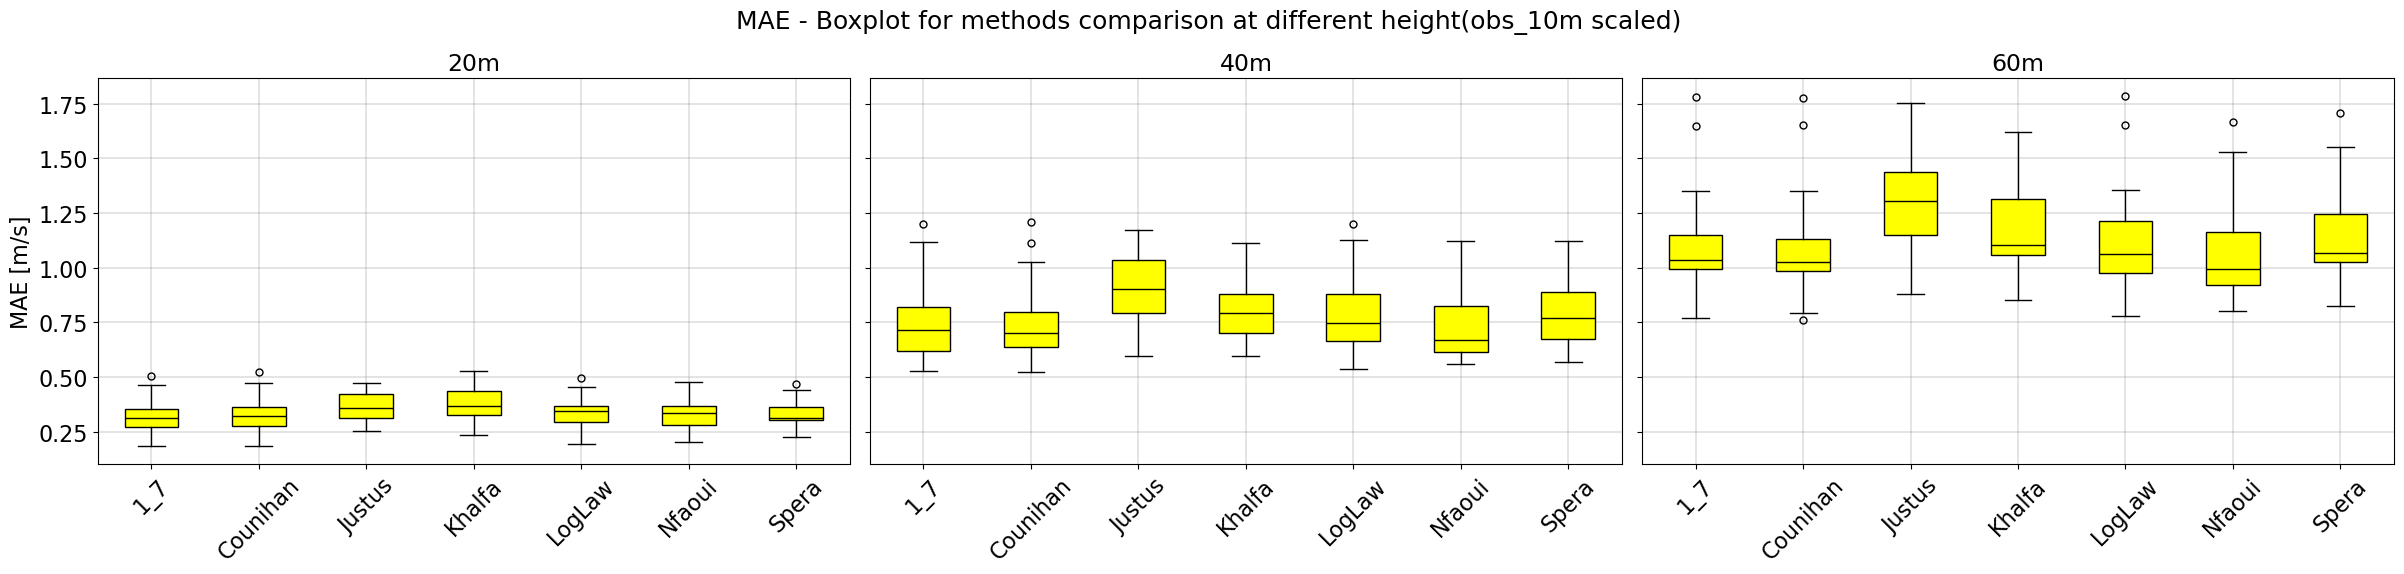

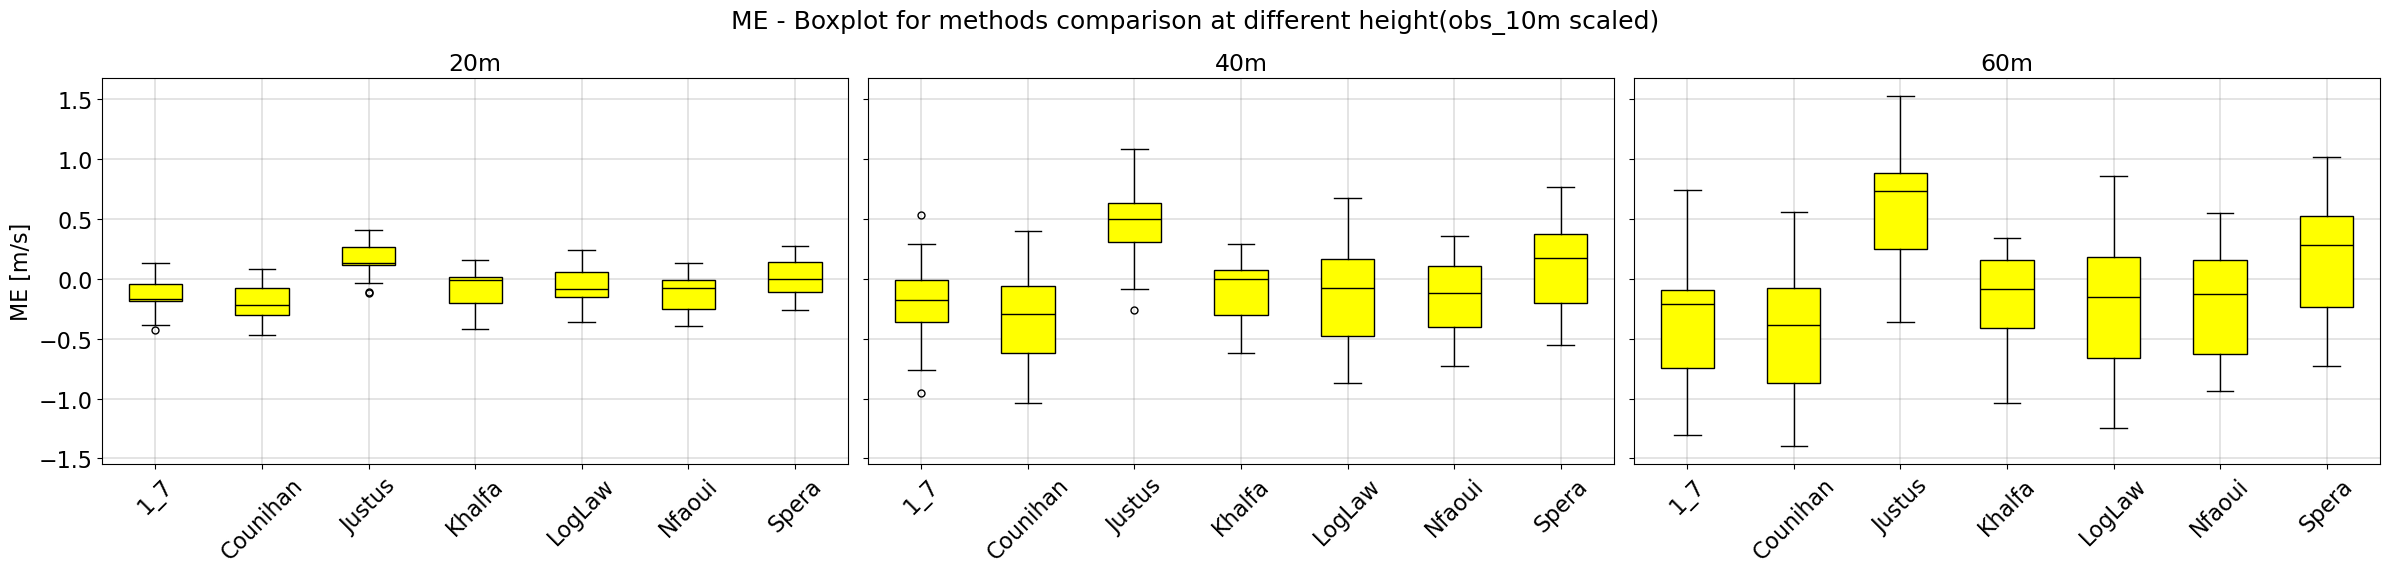

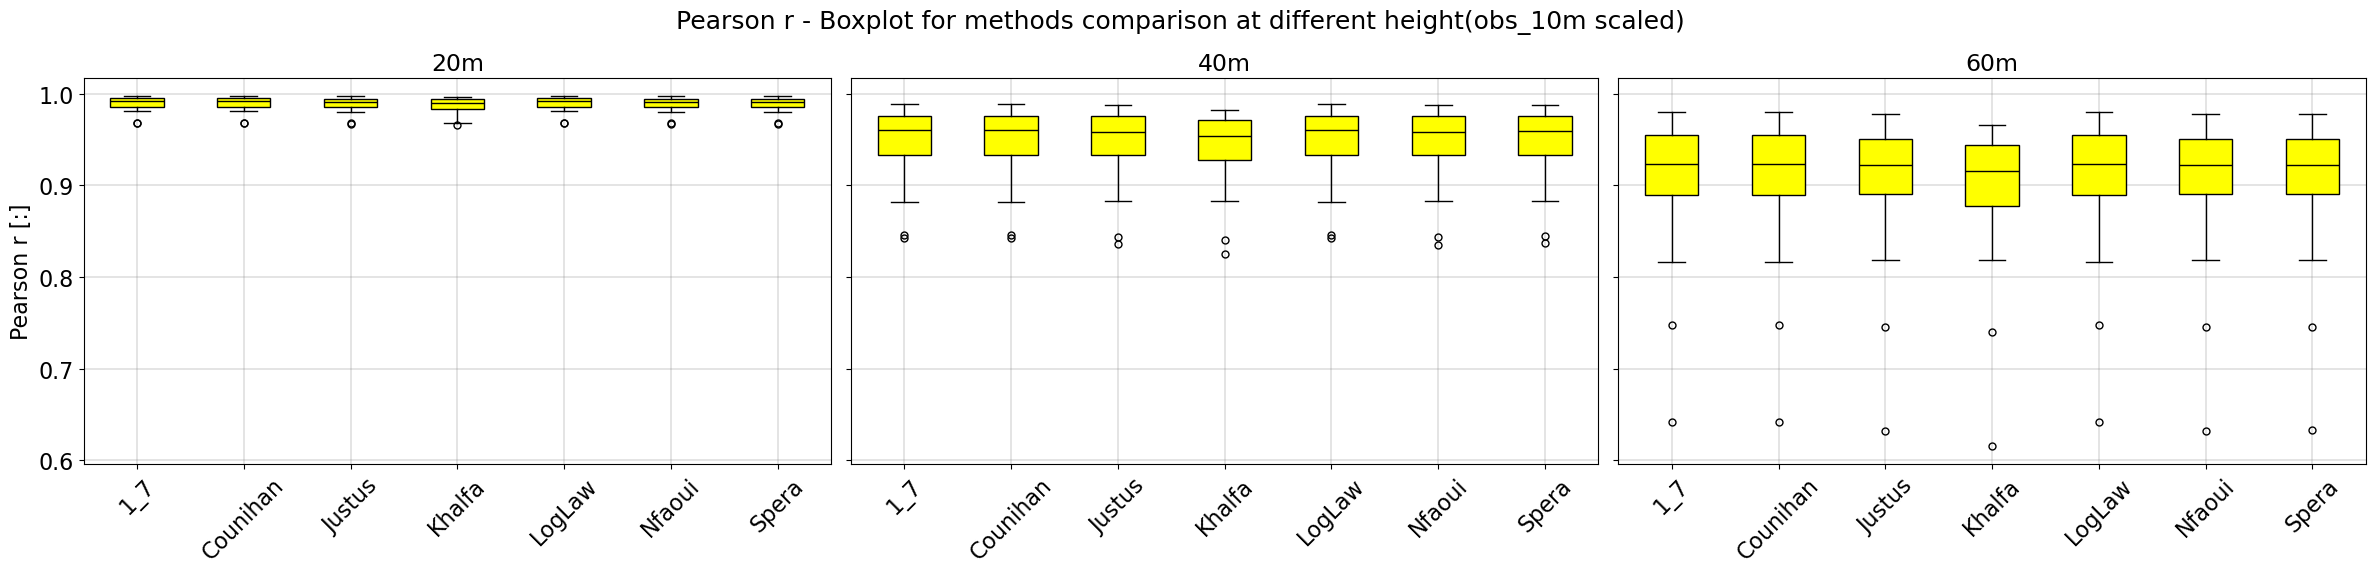

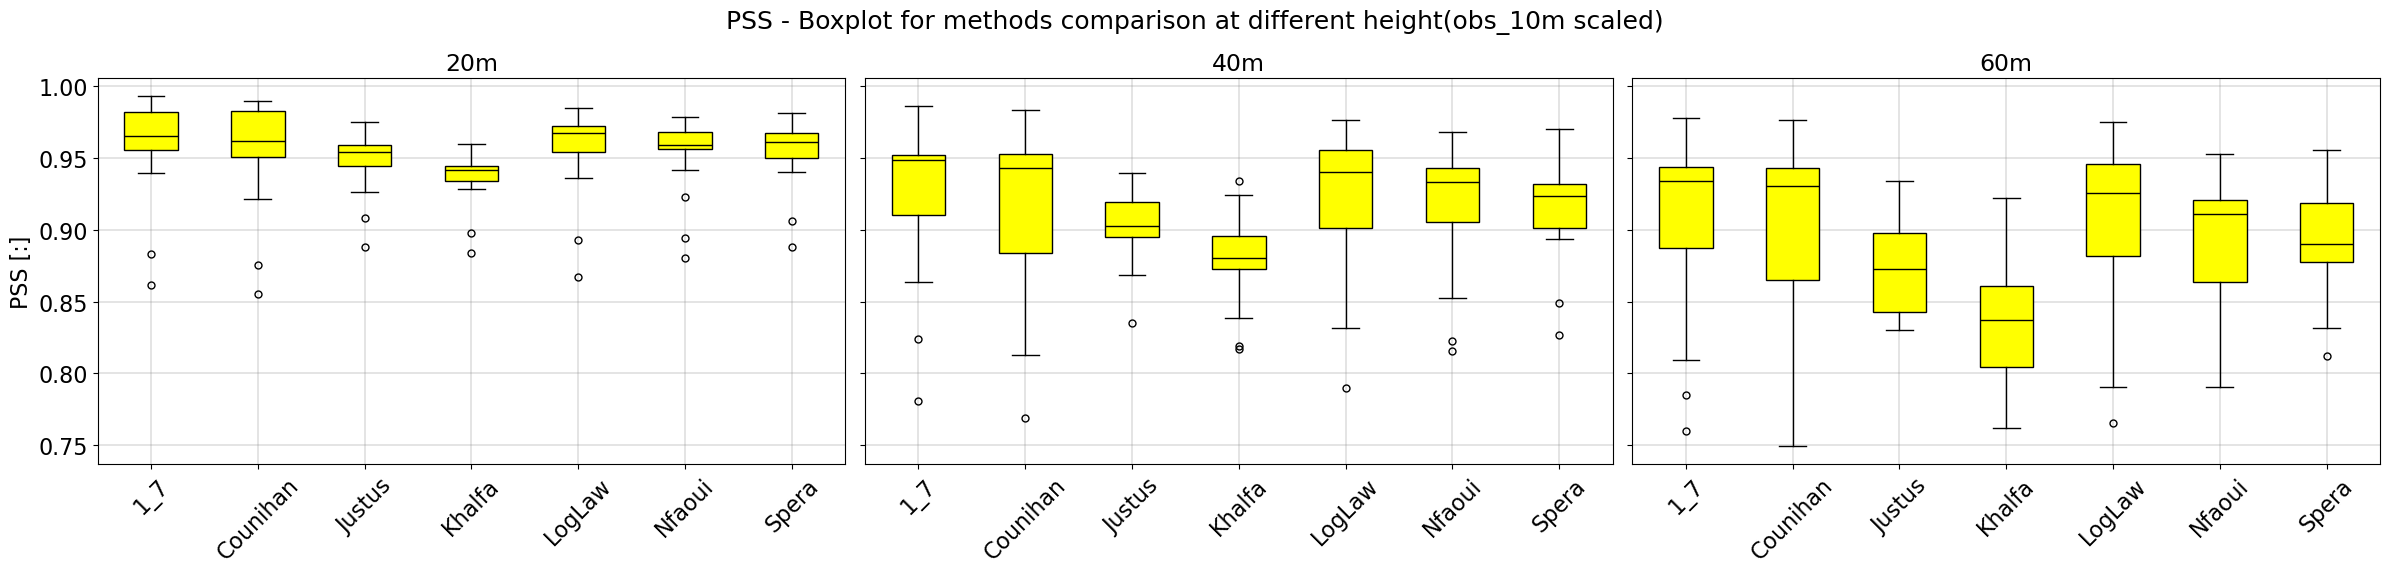

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_obs_extrapolated_20m_cut.xlsx",
    40: base_path + r"\metrics_obs_extrapolated_40m_cut.xlsx",
    60: base_path + r"\metrics_obs_extrapolated_60m_cut.xlsx"
}

# 📊 Métriques à tracer
metrics = ["MAE"]
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 🎨 Style des boîtes
box_face_color = "yellow"
edge_color = "black"
median_color = "black"
whisker_color = "black"
cap_color = "black"
flier_color = "black"

# 🔁 Pour chaque métrique
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Boxplot for methods comparison at different height(obs_10m scaled)", fontsize=18)

    # 🔁 Pour chaque hauteur
    for ax, h in zip(axes, [20, 40, 60]):
        xls = pd.read_excel(paths[h], sheet_name=None)
        stations = [s for s in xls.keys() if s not in exclusions[h]]

        # 📦 Regroupement des données
        method_data = {m: [] for m in methods_obs_extra}
        for station in stations:
            df = xls[station]
            for method in methods_obs_extra:
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    method_data[method].append(val)
                except: continue

        # 🎨 Création du boxplot
        box = ax.boxplot([method_data[m] for m in methods_obs_extra], patch_artist=True,
                         tick_labels=methods_obs_extra,
                         medianprops=dict(color=median_color),
                         whiskerprops=dict(color=whisker_color),
                         capprops=dict(color=cap_color),
                         flierprops=dict(marker='o', color=flier_color, markersize=5))

        for patch in box['boxes']:
            patch.set_facecolor(box_face_color)
            patch.set_edgecolor(edge_color)

        ax.set_title(f"{h}m", fontsize=17)
        ax.set_xticklabels(methods_obs_extra, rotation=45, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        if h == 20:
            ax.set_ylabel(f"{metric} [m/s]", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extra_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()

    
    
metrics = ["ME"]    
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 🎨 Style des boîtes
box_face_color = "yellow"
edge_color = "black"
median_color = "black"
whisker_color = "black"
cap_color = "black"
flier_color = "black"

# 🔁 Pour chaque métrique
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Boxplot for methods comparison at different height(obs_10m scaled)", fontsize=18)

    # 🔁 Pour chaque hauteur
    for ax, h in zip(axes, [20, 40, 60]):
        xls = pd.read_excel(paths[h], sheet_name=None)
        stations = [s for s in xls.keys() if s not in exclusions[h]]

        # 📦 Regroupement des données
        method_data = {m: [] for m in methods_obs_extra}
        for station in stations:
            df = xls[station]
            for method in methods_obs_extra:
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    method_data[method].append(val)
                except: continue

        # 🎨 Création du boxplot
        box = ax.boxplot([method_data[m] for m in methods_obs_extra], patch_artist=True,
                         tick_labels=methods_obs_extra,
                         medianprops=dict(color=median_color),
                         whiskerprops=dict(color=whisker_color),
                         capprops=dict(color=cap_color),
                         flierprops=dict(marker='o', color=flier_color, markersize=5))

        for patch in box['boxes']:
            patch.set_facecolor(box_face_color)
            patch.set_edgecolor(edge_color)

        ax.set_title(f"{h}m", fontsize=17)
        ax.set_xticklabels(methods_obs_extra, rotation=45, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        if h == 20:
            ax.set_ylabel(f"{metric} [m/s]", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extra_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()



metrics = ["Pearson r"]
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 🎨 Style des boîtes
box_face_color = "yellow"
edge_color = "black"
median_color = "black"
whisker_color = "black"
cap_color = "black"
flier_color = "black"

# 🔁 Pour chaque métrique
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Boxplot for methods comparison at different height(obs_10m scaled)", fontsize=18)

    # 🔁 Pour chaque hauteur
    for ax, h in zip(axes, [20, 40, 60]):
        xls = pd.read_excel(paths[h], sheet_name=None)
        stations = [s for s in xls.keys() if s not in exclusions[h]]

        # 📦 Regroupement des données
        method_data = {m: [] for m in methods_obs_extra}
        for station in stations:
            df = xls[station]
            for method in methods_obs_extra:
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    method_data[method].append(val)
                except: continue

        # 🎨 Création du boxplot
        box = ax.boxplot([method_data[m] for m in methods_obs_extra], patch_artist=True,
                         tick_labels=methods_obs_extra,
                         medianprops=dict(color=median_color),
                         whiskerprops=dict(color=whisker_color),
                         capprops=dict(color=cap_color),
                         flierprops=dict(marker='o', color=flier_color, markersize=5))

        for patch in box['boxes']:
            patch.set_facecolor(box_face_color)
            patch.set_edgecolor(edge_color)

        ax.set_title(f"{h}m", fontsize=17)
        ax.set_xticklabels(methods_obs_extra, rotation=45, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        if h == 20:
            ax.set_ylabel(f"{metric} [:]", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extra_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()



metrics = ["PSS"]
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 🎨 Style des boîtes
box_face_color = "yellow"
edge_color = "black"
median_color = "black"
whisker_color = "black"
cap_color = "black"
flier_color = "black"

# 🔁 Pour chaque métrique
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Boxplot for methods comparison at different height(obs_10m scaled)", fontsize=18)

    # 🔁 Pour chaque hauteur
    for ax, h in zip(axes, [20, 40, 60]):
        xls = pd.read_excel(paths[h], sheet_name=None)
        stations = [s for s in xls.keys() if s not in exclusions[h]]

        # 📦 Regroupement des données
        method_data = {m: [] for m in methods_obs_extra}
        for station in stations:
            df = xls[station]
            for method in methods_obs_extra:
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    method_data[method].append(val)
                except: continue

        # 🎨 Création du boxplot
        box = ax.boxplot([method_data[m] for m in methods_obs_extra], patch_artist=True,
                         tick_labels=methods_obs_extra,
                         medianprops=dict(color=median_color),
                         whiskerprops=dict(color=whisker_color),
                         capprops=dict(color=cap_color),
                         flierprops=dict(marker='o', color=flier_color, markersize=5))

        for patch in box['boxes']:
            patch.set_facecolor(box_face_color)
            patch.set_edgecolor(edge_color)

        ax.set_title(f"{h}m", fontsize=17)
        ax.set_xticklabels(methods_obs_extra, rotation=45, fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        if h == 20:
            ax.set_ylabel(f"{metric} [:]", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extra_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()


In [46]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_obs_extrapolated_20m_cut.xlsx",
    40: base_path + r"\metrics_obs_extrapolated_40m_cut.xlsx",
    60: base_path + r"\metrics_obs_extrapolated_60m_cut.xlsx"
}

# 📊 Métriques à analyser
metrics = ["MAE", "ME", "Pearson r", "PSS"]
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    xls = pd.read_excel(paths[h], sheet_name=None)
    stations = [s for s in xls.keys() if s not in exclusions[h]]

    for metric in metrics:
        for method in methods_obs_extra:
            values = []
            for station in stations:
                df = xls[station]
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    values.append(val)
                except:
                    continue
            if values:
                q75 = np.percentile(values, 75)
                records.append({
                    "Height": h,
                    "Method": method,
                    "Metric": metric,
                    "Q75": round(q75, 3),
                    "N": len(values)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage
print("\n📊 3e quartile (75%) des métriques par méthode et hauteur\n")

pd.set_option('display.max_rows', 100)  # ou plus si nécessaire
print(quartile_df)



📊 3e quartile (75%) des métriques par méthode et hauteur

    Height    Method     Metric    Q75   N
0       20       1_7        MAE  0.353  17
1       20  Counihan        MAE  0.363  17
2       20    Justus        MAE  0.423  17
3       20    Khalfa        MAE  0.435  17
4       20    LogLaw        MAE  0.365  17
5       20    Nfaoui        MAE  0.365  17
6       20     Spera        MAE  0.360  17
7       20       1_7         ME -0.043  17
8       20  Counihan         ME -0.080  17
9       20    Justus         ME  0.264  17
10      20    Khalfa         ME  0.018  17
11      20    LogLaw         ME  0.059  17
12      20    Nfaoui         ME -0.006  17
13      20     Spera         ME  0.140  17
14      20       1_7  Pearson r  0.995  17
15      20  Counihan  Pearson r  0.995  17
16      20    Justus  Pearson r  0.995  17
17      20    Khalfa  Pearson r  0.994  17
18      20    LogLaw  Pearson r  0.995  17
19      20    Nfaoui  Pearson r  0.995  17
20      20     Spera  Pearson r  0.995

In [49]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_obs_extrapolated_20m_cut.xlsx",
    40: base_path + r"\metrics_obs_extrapolated_40m_cut.xlsx",
    60: base_path + r"\metrics_obs_extrapolated_60m_cut.xlsx"
}

# 📊 Métriques à analyser
metrics = ["MAE", "ME", "Pearson r", "PSS"]
methods_obs_extra = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    xls = pd.read_excel(paths[h], sheet_name=None)
    stations = [s for s in xls.keys() if s not in exclusions[h]]

    for metric in metrics:
        for method in methods_obs_extra:
            values = []
            for station in stations:
                df = xls[station]
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    values.append(val)
                except:
                    continue
            if values:
                q25 = np.percentile(values, 25)
                records.append({
                    "Height": h,
                    "Method": method,
                    "Metric": metric,
                    "Q25": round(q25, 3),
                    "N": len(values)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage
print("\n📊 3e quartile (25%) des métriques par méthode et hauteur\n")

pd.set_option('display.max_rows', 100)  # ou plus si nécessaire
print(quartile_df)



📊 3e quartile (25%) des métriques par méthode et hauteur

    Height    Method     Metric    Q25   N
0       20       1_7        MAE  0.269  17
1       20  Counihan        MAE  0.273  17
2       20    Justus        MAE  0.312  17
3       20    Khalfa        MAE  0.324  17
4       20    LogLaw        MAE  0.296  17
5       20    Nfaoui        MAE  0.281  17
6       20     Spera        MAE  0.302  17
7       20       1_7         ME -0.188  17
8       20  Counihan         ME -0.300  17
9       20    Justus         ME  0.115  17
10      20    Khalfa         ME -0.200  17
11      20    LogLaw         ME -0.150  17
12      20    Nfaoui         ME -0.250  17
13      20     Spera         ME -0.113  17
14      20       1_7  Pearson r  0.985  17
15      20  Counihan  Pearson r  0.985  17
16      20    Justus  Pearson r  0.985  17
17      20    Khalfa  Pearson r  0.983  17
18      20    LogLaw  Pearson r  0.985  17
19      20    Nfaoui  Pearson r  0.985  17
20      20     Spera  Pearson r  0.985

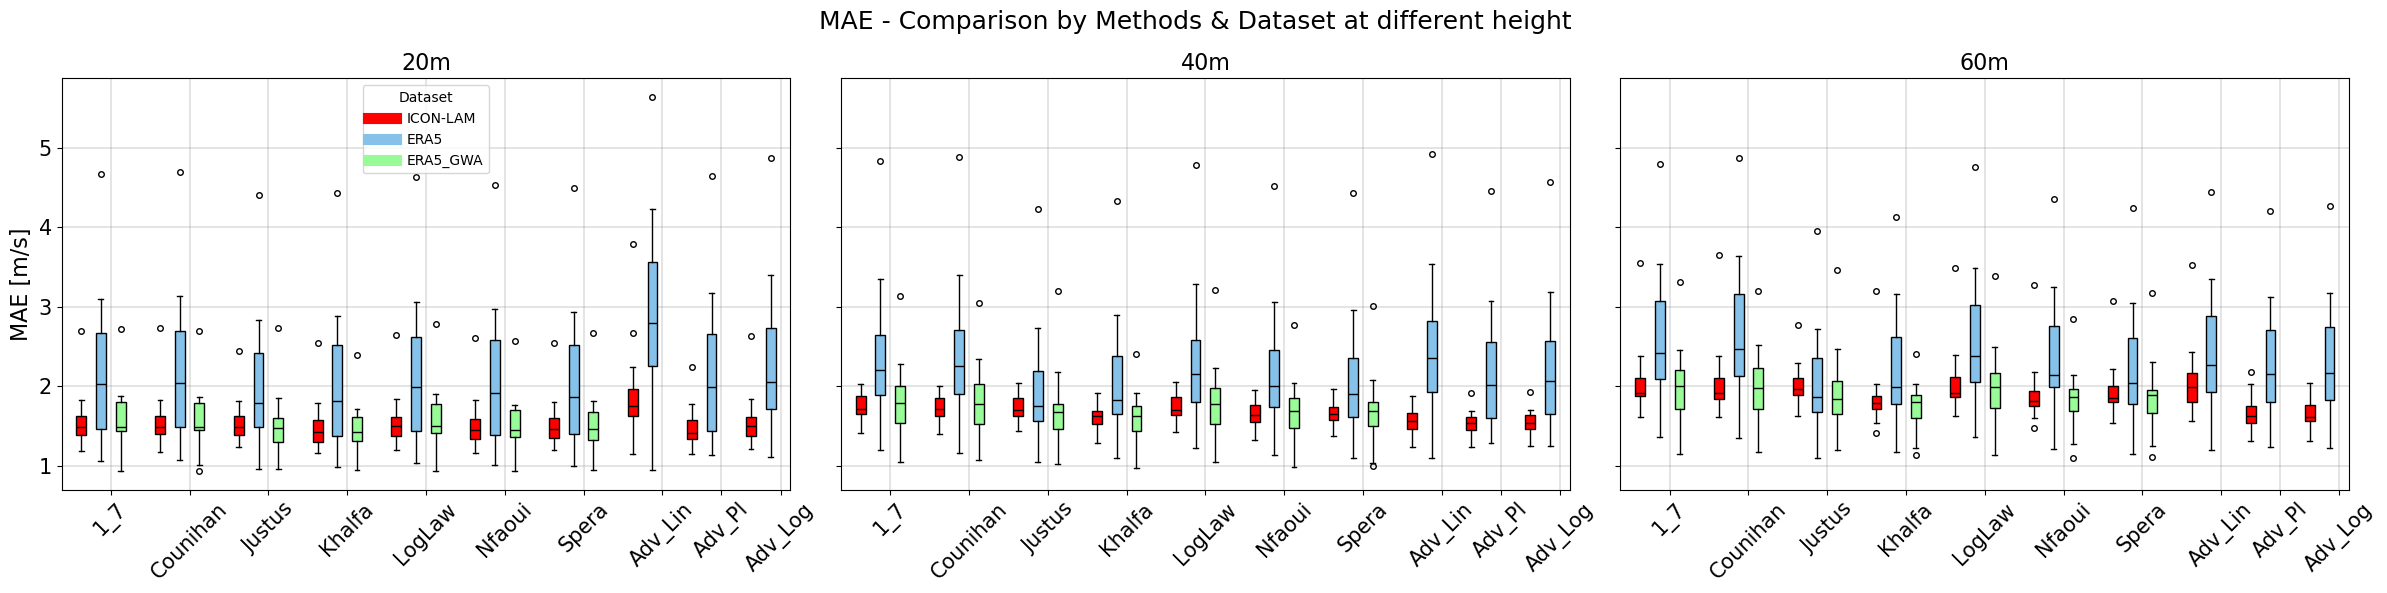

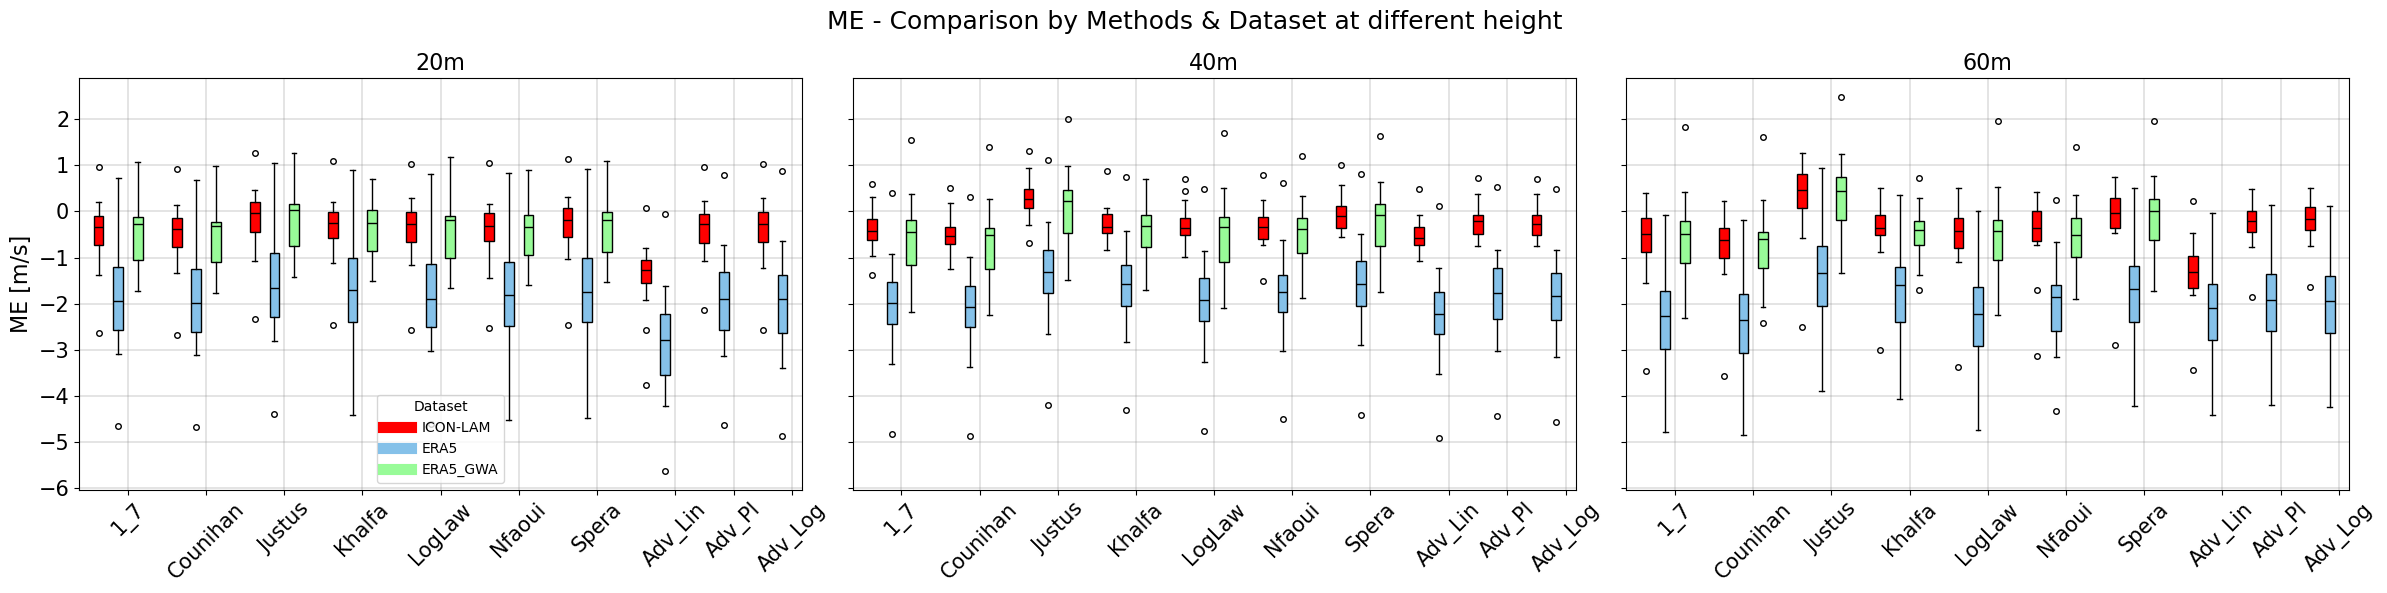

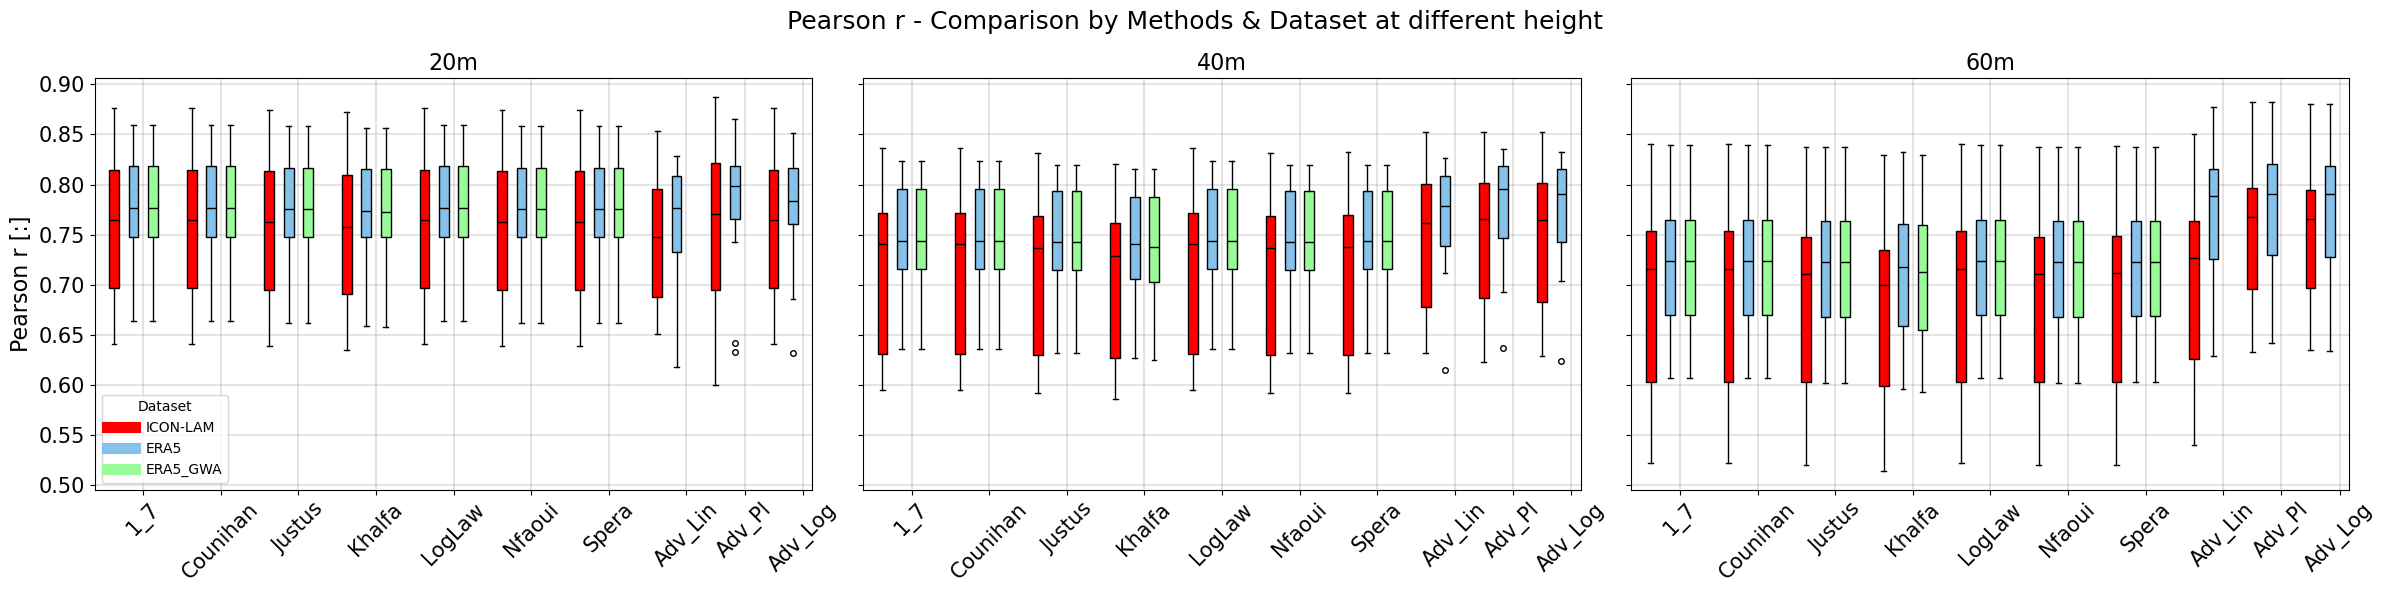

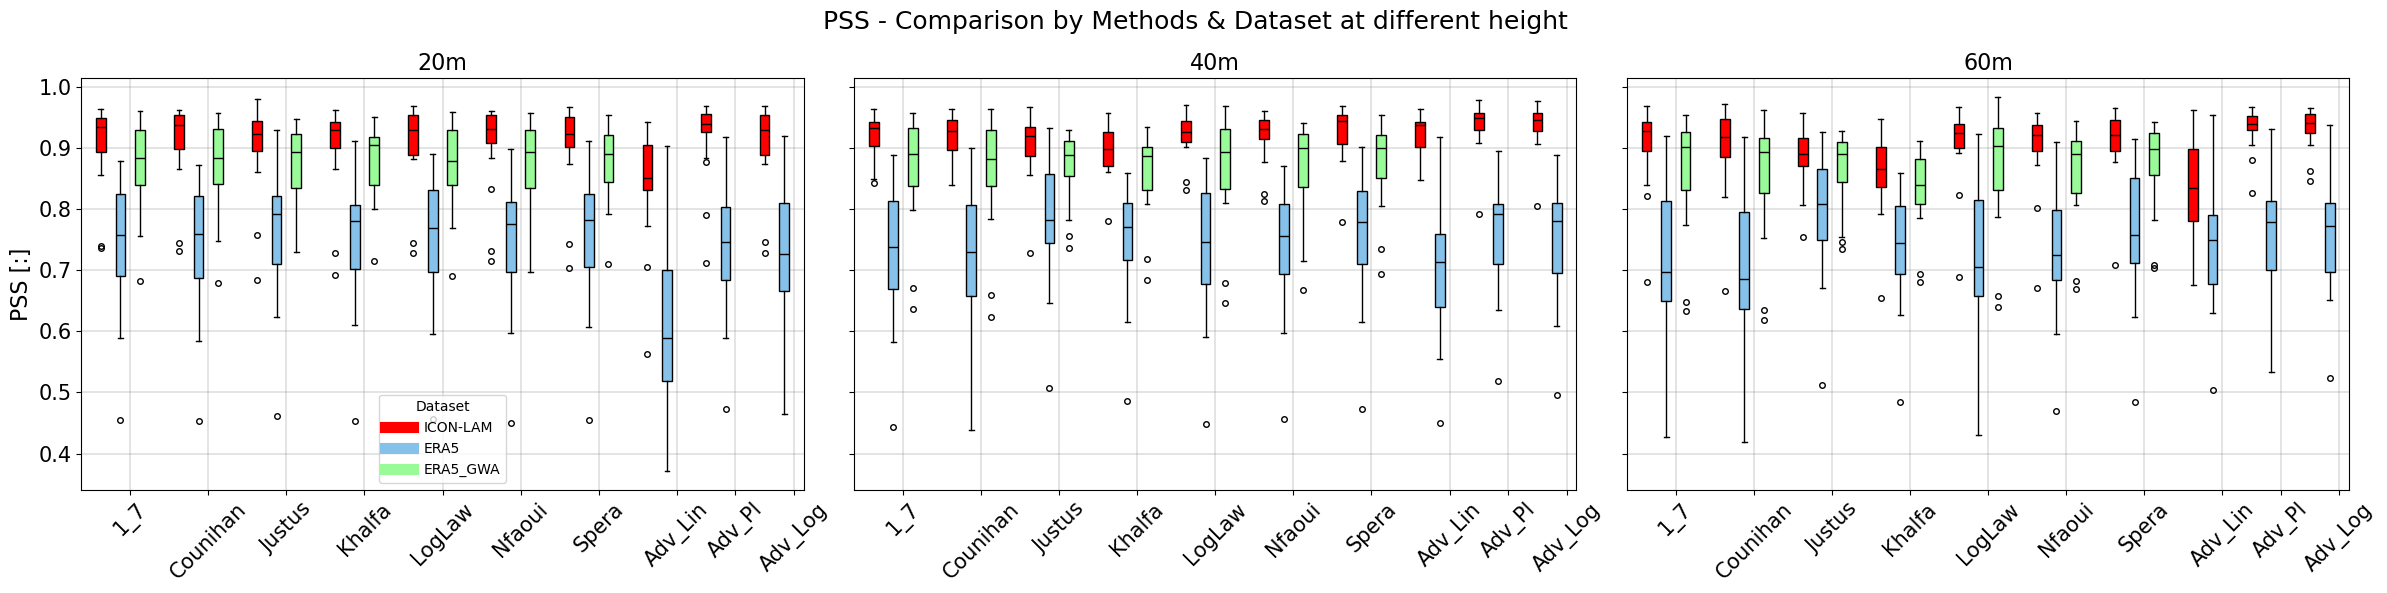

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 📁 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: {
        "ICON-LAM": base_path + r"\metrics_ICON-LAM_20m_cut.xlsx",
        "ERA5": base_path + r"\metrics_ERA5_20m_cut.xlsx",
        "ERA5_GWA": base_path + r"\metrics_ERA5_GWA_20m_cut.xlsx"
    },
    40: {
        "ICON-LAM": base_path + r"\metrics_ICON-LAM_40m_cut.xlsx",
        "ERA5": base_path + r"\metrics_ERA5_40m_cut.xlsx",
        "ERA5_GWA": base_path + r"\metrics_ERA5_GWA_40m_cut.xlsx"
    },
    60: {
        "ICON-LAM": base_path + r"\metrics_ICON-LAM_60m_cut.xlsx",
        "ERA5": base_path + r"\metrics_ERA5_60m_cut.xlsx",
        "ERA5_GWA": base_path + r"\metrics_ERA5_GWA_60m_cut.xlsx"
    }
}

metrics = ["MAE"]
methods_all = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log"]
methods_gwa = methods_all[:7]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}
color_map = {"ICON-LAM": "red", "ERA5": "#85C1E9", "ERA5_GWA": "#98FB98"}

# 📊 Boucle sur les métriques
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Comparison by Methods & Dataset at different height", fontsize=18)

    for ax, h in zip(axes, [20, 40, 60]):
        positions = []
        box_data = []
        box_colors = []
        box_labels = []
        means = []

        pos = 1
        sheets = {label: pd.read_excel(paths[h][label], sheet_name=None) for label in color_map}

        for method in methods_all:
            for label in ["ICON-LAM", "ERA5", "ERA5_GWA"]:
                if method not in methods_gwa and label == "ERA5_GWA":
                    continue

                df_dict = sheets[label]
                data = []

                for station, df in df_dict.items():
                    if station in exclusions[h]: continue
                    try:
                        val = df.loc[df["Methods"] == method, metric].values[0]
                        data.append(val)
                    except: continue

                if data:
                    box_data.append(data)
                    box_colors.append(color_map[label])
                    box_labels.append(method)
                    positions.append(pos)
                    means.append(np.mean(data))
                    pos += 1
            pos += 1  # espacement entre les groupes

        # 📦 Boxplot groupé
        box = ax.boxplot(box_data, positions=positions, patch_artist=True,
                         medianprops=dict(color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         flierprops=dict(marker='o', color='black', markersize=4))

        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')



        # 📍 Méthodes en x
        method_ticks = []
        method_pos = []
        tick_pos = 2.5
        for method in methods_all:
            if method in methods_gwa:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 4
            else:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 3

        ax.set_title(f"{h}m", fontsize=16)
        ax.set_xticks(method_pos)
        ax.set_xticklabels(method_ticks, rotation=45, fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        ax.set_xlim(0, max(positions)+1)

        if h == 20:
            ax.set_ylabel(f"{metric} [m/s]", fontsize=16)

    # 🧾 Légende commune
    for label, color in color_map.items():
        axes[0].plot([], [], color=color, label=label, linewidth=8)
    axes[0].legend(title="Dataset")

    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\multiheight_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()


metrics = ["ME"]
methods_all = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log"]
methods_gwa = methods_all[:7]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}
color_map = {"ICON-LAM": "red", "ERA5": "#85C1E9", "ERA5_GWA": "#98FB98"}

# 📊 Boucle sur les métriques
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Comparison by Methods & Dataset at different height", fontsize=18)

    for ax, h in zip(axes, [20, 40, 60]):
        positions = []
        box_data = []
        box_colors = []
        box_labels = []
        means = []

        pos = 1
        sheets = {label: pd.read_excel(paths[h][label], sheet_name=None) for label in color_map}

        for method in methods_all:
            for label in ["ICON-LAM", "ERA5", "ERA5_GWA"]:
                if method not in methods_gwa and label == "ERA5_GWA":
                    continue

                df_dict = sheets[label]
                data = []

                for station, df in df_dict.items():
                    if station in exclusions[h]: continue
                    try:
                        val = df.loc[df["Methods"] == method, metric].values[0]
                        data.append(val)
                    except: continue

                if data:
                    box_data.append(data)
                    box_colors.append(color_map[label])
                    box_labels.append(method)
                    positions.append(pos)
                    means.append(np.mean(data))
                    pos += 1
            pos += 1  # espacement entre les groupes

        # 📦 Boxplot groupé
        box = ax.boxplot(box_data, positions=positions, patch_artist=True,
                         medianprops=dict(color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         flierprops=dict(marker='o', color='black', markersize=4))

        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')



        # 📍 Méthodes en x
        method_ticks = []
        method_pos = []
        tick_pos = 2.5
        for method in methods_all:
            if method in methods_gwa:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 4
            else:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 3

        ax.set_title(f"{h}m", fontsize=16)
        ax.set_xticks(method_pos)
        ax.set_xticklabels(method_ticks, rotation=45, fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        ax.set_xlim(0, max(positions)+1)

        if h == 20:
            ax.set_ylabel(f"{metric} [m/s]", fontsize=16)

    # 🧾 Légende commune
    for label, color in color_map.items():
        axes[0].plot([], [], color=color, label=label, linewidth=8)
    axes[0].legend(title="Dataset")

    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\multiheight_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()


metrics = ["Pearson r"]
methods_all = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log"]
methods_gwa = methods_all[:7]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}
color_map = {"ICON-LAM": "red", "ERA5": "#85C1E9", "ERA5_GWA": "#98FB98"}

# 📊 Boucle sur les métriques
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Comparison by Methods & Dataset at different height", fontsize=18)

    for ax, h in zip(axes, [20, 40, 60]):
        positions = []
        box_data = []
        box_colors = []
        box_labels = []
        means = []

        pos = 1
        sheets = {label: pd.read_excel(paths[h][label], sheet_name=None) for label in color_map}

        for method in methods_all:
            for label in ["ICON-LAM", "ERA5", "ERA5_GWA"]:
                if method not in methods_gwa and label == "ERA5_GWA":
                    continue

                df_dict = sheets[label]
                data = []

                for station, df in df_dict.items():
                    if station in exclusions[h]: continue
                    try:
                        val = df.loc[df["Methods"] == method, metric].values[0]
                        data.append(val)
                    except: continue

                if data:
                    box_data.append(data)
                    box_colors.append(color_map[label])
                    box_labels.append(method)
                    positions.append(pos)
                    means.append(np.mean(data))
                    pos += 1
            pos += 1  # espacement entre les groupes

        # 📦 Boxplot groupé
        box = ax.boxplot(box_data, positions=positions, patch_artist=True,
                         medianprops=dict(color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         flierprops=dict(marker='o', color='black', markersize=4))

        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')



        # 📍 Méthodes en x
        method_ticks = []
        method_pos = []
        tick_pos = 2.5
        for method in methods_all:
            if method in methods_gwa:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 4
            else:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 3

        ax.set_title(f"{h}m", fontsize=16)
        ax.set_xticks(method_pos)
        ax.set_xticklabels(method_ticks, rotation=45, fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        ax.set_xlim(0, max(positions)+1)

        if h == 20:
            ax.set_ylabel(f"{metric} [:]", fontsize=16)

    # 🧾 Légende commune
    for label, color in color_map.items():
        axes[0].plot([], [], color=color, label=label, linewidth=8)
    axes[0].legend(title="Dataset")

    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\multiheight_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()


metrics = ["PSS"]
methods_all = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log"]
methods_gwa = methods_all[:7]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}
color_map = {"ICON-LAM": "red", "ERA5": "#85C1E9", "ERA5_GWA": "#98FB98"}

# 📊 Boucle sur les métriques
for metric in metrics:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    plt.suptitle(f"{metric} - Comparison by Methods & Dataset at different height", fontsize=18)

    for ax, h in zip(axes, [20, 40, 60]):
        positions = []
        box_data = []
        box_colors = []
        box_labels = []
        means = []

        pos = 1
        sheets = {label: pd.read_excel(paths[h][label], sheet_name=None) for label in color_map}

        for method in methods_all:
            for label in ["ICON-LAM", "ERA5", "ERA5_GWA"]:
                if method not in methods_gwa and label == "ERA5_GWA":
                    continue

                df_dict = sheets[label]
                data = []

                for station, df in df_dict.items():
                    if station in exclusions[h]: continue
                    try:
                        val = df.loc[df["Methods"] == method, metric].values[0]
                        data.append(val)
                    except: continue

                if data:
                    box_data.append(data)
                    box_colors.append(color_map[label])
                    box_labels.append(method)
                    positions.append(pos)
                    means.append(np.mean(data))
                    pos += 1
            pos += 1  # espacement entre les groupes

        # 📦 Boxplot groupé
        box = ax.boxplot(box_data, positions=positions, patch_artist=True,
                         medianprops=dict(color='black'),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'),
                         flierprops=dict(marker='o', color='black', markersize=4))

        for patch, color in zip(box['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('black')



        # 📍 Méthodes en x
        method_ticks = []
        method_pos = []
        tick_pos = 2.5
        for method in methods_all:
            if method in methods_gwa:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 4
            else:
                method_ticks.append(method)
                method_pos.append(tick_pos)
                tick_pos += 3

        ax.set_title(f"{h}m", fontsize=16)
        ax.set_xticks(method_pos)
        ax.set_xticklabels(method_ticks, rotation=45, fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
        ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')

        ax.set_xlim(0, max(positions)+1)

        if h == 20:
            ax.set_ylabel(f"{metric} [:]", fontsize=16)

    # 🧾 Légende commune
    for label, color in color_map.items():
        axes[0].plot([], [], color=color, label=label, linewidth=8)
    axes[0].legend(title="Dataset")

    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.savefig(fr"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\multiheight_boxplot_{metric}_by_method.png", dpi=300)
    plt.show()

In [51]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_ICON-LAM_20m_cut.xlsx",
    40: base_path + r"\metrics_ICON-LAM_40m_cut.xlsx",
    60: base_path + r"\metrics_ICON-LAM_60m_cut.xlsx"
}

# 📊 Métriques à analyser
metrics = ["MAE", "ME", "Pearson r", "PSS"]
methods_ICON_LAM = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log" ]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    xls = pd.read_excel(paths[h], sheet_name=None)
    stations = [s for s in xls.keys() if s not in exclusions[h]]

    for metric in metrics:
        for method in methods_ICON_LAM:
            values = []
            for station in stations:
                df = xls[station]
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    values.append(val)
                except:
                    continue
            if values:
                q75 = np.percentile(values, 75)
                records.append({
                    "Height": h,
                    "Method": method,
                    "Metric": metric,
                    "Q75": round(q75, 3),
                    "N": len(values)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage
print("\n📊 3e quartile (75%) des métriques par méthode et hauteur\n")

pd.set_option('display.max_rows', 150)  # ou plus si nécessaire
print(quartile_df)


📊 3e quartile (75%) des métriques par méthode et hauteur

     Height    Method     Metric    Q75   N
0        20       1_7        MAE  1.626  17
1        20  Counihan        MAE  1.623  17
2        20    Justus        MAE  1.626  17
3        20    Khalfa        MAE  1.574  17
4        20    LogLaw        MAE  1.607  17
5        20    Nfaoui        MAE  1.591  17
6        20     Spera        MAE  1.596  17
7        20   Adv_Lin        MAE  1.968  17
8        20    Adv_Pl        MAE  1.574  17
9        20   Adv_Log        MAE  1.608  17
10       20       1_7         ME -0.091  17
11       20  Counihan         ME -0.134  17
12       20    Justus         ME  0.205  17
13       20    Khalfa         ME -0.003  17
14       20    LogLaw         ME -0.020  17
15       20    Nfaoui         ME -0.043  17
16       20     Spera         ME  0.073  17
17       20   Adv_Lin         ME -1.064  17
18       20    Adv_Pl         ME -0.046  17
19       20   Adv_Log         ME -0.017  17
20       20      

In [57]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_ERA5_GWA_20m_cut.xlsx",
    40: base_path + r"\metrics_ERA5_GWA_40m_cut.xlsx",
    60: base_path + r"\metrics_ERA5_GWA_60m_cut.xlsx"
}

# 📊 Métriques à analyser
metrics = ["MAE", "ME", "Pearson r", "PSS"]
methods_ICON_LAM = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera"]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    xls = pd.read_excel(paths[h], sheet_name=None)
    stations = [s for s in xls.keys() if s not in exclusions[h]]

    for metric in metrics:
        for method in methods_ICON_LAM:
            values = []
            for station in stations:
                df = xls[station]
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    values.append(val)
                except:
                    continue
            if values:
                q75 = np.percentile(values, 75)
                records.append({
                    "Height": h,
                    "Method": method,
                    "Metric": metric,
                    "Q75": round(q75, 3),
                    "N": len(values)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage
print("\n📊 ERA5_GWA 3e quartile (75%) des métriques par méthode et hauteur\n")

pd.set_option('display.max_rows', 150)  # ou plus si nécessaire
print(quartile_df)


📊 ERA5_GWA 3e quartile (75%) des métriques par méthode et hauteur

    Height    Method     Metric    Q75   N
0       20       1_7        MAE  1.808  17
1       20  Counihan        MAE  1.787  17
2       20    Justus        MAE  1.596  17
3       20    Khalfa        MAE  1.608  17
4       20    LogLaw        MAE  1.782  17
5       20    Nfaoui        MAE  1.700  17
6       20     Spera        MAE  1.680  17
7       20       1_7         ME -0.121  17
8       20  Counihan         ME -0.229  17
9       20    Justus         ME  0.169  17
10      20    Khalfa         ME  0.037  17
11      20    LogLaw         ME -0.088  17
12      20    Nfaoui         ME -0.066  17
13      20     Spera         ME -0.002  17
14      20       1_7  Pearson r  0.819  17
15      20  Counihan  Pearson r  0.819  17
16      20    Justus  Pearson r  0.817  17
17      20    Khalfa  Pearson r  0.815  17
18      20    LogLaw  Pearson r  0.819  17
19      20    Nfaoui  Pearson r  0.817  17
20      20     Spera  Pearson

In [56]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers
base_path = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM"
paths = {
    20: base_path + r"\metrics_ERA5_20m_cut.xlsx",
    40: base_path + r"\metrics_ERA5_40m_cut.xlsx",
    60: base_path + r"\metrics_ERA5_60m_cut.xlsx"
}

# 📊 Métriques à analyser
metrics = ["MAE", "ME", "Pearson r", "PSS"]
methods_ICON_LAM = ["1_7", "Counihan", "Justus", "Khalfa", "LogLaw", "Nfaoui", "Spera", "Adv_Lin", "Adv_Pl", "Adv_Log" ]
exclusions = {20: ["WM10"], 40: ["WM05", "WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    xls = pd.read_excel(paths[h], sheet_name=None)
    stations = [s for s in xls.keys() if s not in exclusions[h]]

    for metric in metrics:
        for method in methods_ICON_LAM:
            values = []
            for station in stations:
                df = xls[station]
                try:
                    val = df.loc[df["Methods"] == method, metric].values[0]
                    values.append(val)
                except:
                    continue
            if values:
                q75 = np.percentile(values, 75)
                records.append({
                    "Height": h,
                    "Method": method,
                    "Metric": metric,
                    "Q75": round(q75, 3),
                    "N": len(values)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage
print("\n📊 ERA5 3e quartile (75%) des métriques par méthode et hauteur\n")

pd.set_option('display.max_rows', 150)  # ou plus si nécessaire
print(quartile_df)


📊 ERA5 3e quartile (75%) des métriques par méthode et hauteur

     Height    Method     Metric    Q75   N
0        20       1_7        MAE  2.669  17
1        20  Counihan        MAE  2.701  17
2        20    Justus        MAE  2.423  17
3        20    Khalfa        MAE  2.521  17
4        20    LogLaw        MAE  2.617  17
5        20    Nfaoui        MAE  2.582  17
6        20     Spera        MAE  2.520  17
7        20   Adv_Lin        MAE  3.566  17
8        20    Adv_Pl        MAE  2.651  17
9        20   Adv_Log        MAE  2.729  17
10       20       1_7         ME -1.201  17
11       20  Counihan         ME -1.240  17
12       20    Justus         ME -0.897  17
13       20    Khalfa         ME -1.006  17
14       20    LogLaw         ME -1.141  17
15       20    Nfaoui         ME -1.093  17
16       20     Spera         ME -1.019  17
17       20   Adv_Lin         ME -2.224  17
18       20    Adv_Pl         ME -1.312  17
19       20   Adv_Log         ME -1.386  17
20       20 

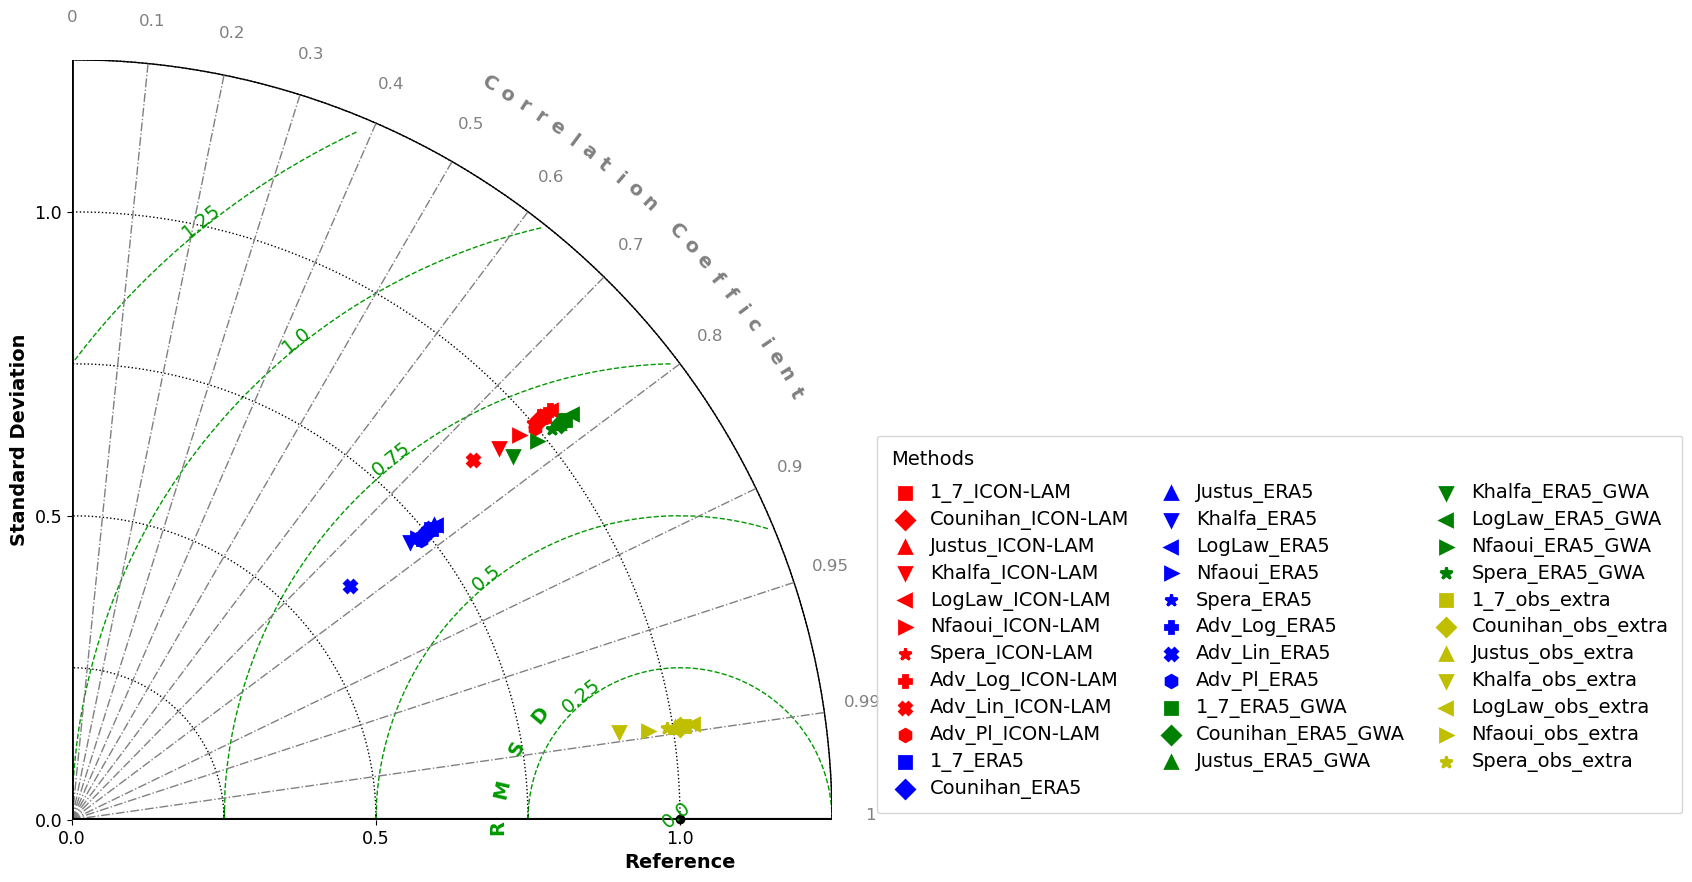

34 34

📊 Taylor Skill Score by methods and dataset at 20m with cut:

                    Skill Score
Method                         
Justus_obs_extra       0.994121
Counihan_obs_extra     0.994099
Spera_obs_extra        0.994067
1_7_obs_extra          0.993867
LogLaw_obs_extra       0.993133
Nfaoui_obs_extra       0.992381
Khalfa_obs_extra       0.985024
Counihan_ERA5_GWA      0.887350
Spera_ERA5_GWA         0.887347
Nfaoui_ERA5_GWA        0.887328
1_7_ERA5_GWA           0.886782
Justus_ERA5_GWA        0.886551
LogLaw_ERA5_GWA        0.885560
Khalfa_ERA5_GWA        0.882563
Adv_Pl_ICON            0.881678
Counihan_ICON          0.879685
1_7_ICON               0.879424
Spera_ICON             0.879004
Adv_Log_ICON           0.878749
LogLaw_ICON            0.878730
Justus_ICON            0.878634
Nfaoui_ICON            0.878031
Khalfa_ICON            0.872577
Adv_Lin_ICON           0.859845
LogLaw_ERA5            0.830872
Justus_ERA5            0.828332
1_7_ERA5               0.824876
Cou

In [31]:
import argparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import skill_metrics as sm

args = type('', (), {})()
args.no_show = False
args.no_save = False

# Configuration de l'affichage
rcParams["figure.figsize"] = [16.0, 12.8]
rcParams['lines.linewidth'] = 1
rcParams.update({'font.size': 12})
plt.close('all')


# declaration des valeur manuellement
stats0 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "1_7", ["Std_obs"]]
stats1 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats2 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats3 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats4 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats5 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats6 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats7 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats8 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats9 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats10 = icon_mean_metrics_20m_cut.loc[icon_mean_metrics_20m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats11 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats12 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats13 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats14 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats15 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats16 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats17 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats18 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats19 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats20 = ERA5_mean_metrics_20m_cut.loc[ERA5_mean_metrics_20m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats21 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats22 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats23 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats24 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats25 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats26 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats27 = ERA5_GWA_mean_metrics_20m_cut.loc[ERA5_GWA_mean_metrics_20m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats31 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats32 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats33 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats34 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats35 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats36 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats37 = obs_extrapolated_mean_metrics_20m_cut.loc[obs_extrapolated_mean_metrics_20m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]



MARKERS = {
    "1_7_ICON-LAM": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Counihan_ICON-LAM": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Justus_ICON-LAM": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Khalfa_ICON-LAM": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "LogLaw_ICON-LAM": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Nfaoui_ICON-LAM": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Spera_ICON-LAM": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Log_ICON-LAM": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Lin_ICON-LAM": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Pl_ICON-LAM": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "1_7_ERA5": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Counihan_ERA5": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Justus_ERA5": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Khalfa_ERA5": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "LogLaw_ERA5": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Nfaoui_ERA5": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Spera_ERA5": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Log_ERA5": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Lin_ERA5": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Pl_ERA5": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "1_7_ERA5_GWA": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Counihan_ERA5_GWA": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Justus_ERA5_GWA": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Khalfa_ERA5_GWA": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "LogLaw_ERA5_GWA": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Nfaoui_ERA5_GWA": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Spera_ERA5_GWA": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "1_7_obs_extra": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Counihan_obs_extra": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Justus_obs_extra": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Khalfa_obs_extra": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "LogLaw_obs_extra": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Nfaoui_obs_extra": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Spera_obs_extra": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "y", "edgeColor": "y",}
                  }

# Regrouper les valeurs
sdev = np.array([
    stats0['Std_obs'].values[0],
    stats1['Std_pred'].values[0],
    stats2['Std_pred'].values[0],
    stats3['Std_pred'].values[0],
    stats4['Std_pred'].values[0],
    stats5['Std_pred'].values[0],
    stats6['Std_pred'].values[0],
    stats7['Std_pred'].values[0],
    stats8['Std_pred'].values[0],
    stats9['Std_pred'].values[0],
    stats10['Std_pred'].values[0],
    stats11['Std_pred'].values[0],
    stats12['Std_pred'].values[0],
    stats13['Std_pred'].values[0],
    stats14['Std_pred'].values[0],
    stats15['Std_pred'].values[0],
    stats16['Std_pred'].values[0],
    stats17['Std_pred'].values[0],
    stats18['Std_pred'].values[0],
    stats19['Std_pred'].values[0],
    stats20['Std_pred'].values[0],
    stats21['Std_pred'].values[0],
    stats22['Std_pred'].values[0],
    stats23['Std_pred'].values[0],
    stats24['Std_pred'].values[0],
    stats25['Std_pred'].values[0],
    stats26['Std_pred'].values[0],
    stats27['Std_pred'].values[0],
    stats31['Std_pred'].values[0],
    stats32['Std_pred'].values[0],
    stats33['Std_pred'].values[0],
    stats34['Std_pred'].values[0],
    stats35['Std_pred'].values[0],
    stats36['Std_pred'].values[0],
    stats37['Std_pred'].values[0]
])

crmsd = np.array([
    0,
    stats1['CRMSD'].values[0],
    stats2['CRMSD'].values[0],
    stats3['CRMSD'].values[0],
    stats4['CRMSD'].values[0],
    stats5['CRMSD'].values[0],
    stats6['CRMSD'].values[0],
    stats7['CRMSD'].values[0],
    stats8['CRMSD'].values[0],
    stats9['CRMSD'].values[0],
    stats10['CRMSD'].values[0],
    stats11['CRMSD'].values[0],
    stats12['CRMSD'].values[0],
    stats13['CRMSD'].values[0],
    stats14['CRMSD'].values[0],
    stats15['CRMSD'].values[0],
    stats16['CRMSD'].values[0],
    stats17['CRMSD'].values[0],
    stats18['CRMSD'].values[0],
    stats19['CRMSD'].values[0],
    stats20['CRMSD'].values[0],
    stats21['CRMSD'].values[0],
    stats22['CRMSD'].values[0],
    stats23['CRMSD'].values[0],
    stats24['CRMSD'].values[0],
    stats25['CRMSD'].values[0],
    stats26['CRMSD'].values[0],
    stats27['CRMSD'].values[0],
    stats31['CRMSD'].values[0],
    stats32['CRMSD'].values[0],
    stats33['CRMSD'].values[0],
    stats34['CRMSD'].values[0],
    stats35['CRMSD'].values[0],
    stats36['CRMSD'].values[0],
    stats37['CRMSD'].values[0]
])

ccoef = np.array([
    0,
    stats1['Pearson r'].values[0],
    stats2['Pearson r'].values[0],
    stats3['Pearson r'].values[0],
    stats4['Pearson r'].values[0],
    stats5['Pearson r'].values[0],
    stats6['Pearson r'].values[0],
    stats7['Pearson r'].values[0],
    stats8['Pearson r'].values[0],
    stats9['Pearson r'].values[0],
    stats10['Pearson r'].values[0],
    stats11['Pearson r'].values[0],
    stats12['Pearson r'].values[0],
    stats13['Pearson r'].values[0],
    stats14['Pearson r'].values[0],
    stats15['Pearson r'].values[0],
    stats16['Pearson r'].values[0],
    stats17['Pearson r'].values[0],
    stats18['Pearson r'].values[0],
    stats19['Pearson r'].values[0],
    stats20['Pearson r'].values[0],
    stats21['Pearson r'].values[0],
    stats22['Pearson r'].values[0],
    stats23['Pearson r'].values[0],
    stats24['Pearson r'].values[0],
    stats25['Pearson r'].values[0],
    stats26['Pearson r'].values[0],
    stats27['Pearson r'].values[0],
    stats31['Pearson r'].values[0],
    stats32['Pearson r'].values[0],
    stats33['Pearson r'].values[0],
    stats34['Pearson r'].values[0],
    stats35['Pearson r'].values[0],
    stats36['Pearson r'].values[0],
    stats37['Pearson r'].values[0]
])

# 🧮 Normaliser toutes les STD (et CRMSD) par la std de référence
sigma_ref = stats0['Std_obs'].values[0]

sdev_norm = sdev / sigma_ref
crmsd_norm = crmsd / sigma_ref

# Génération du diagramme
sm.taylor_diagram(sdev_norm, crmsd_norm, ccoef, markers = MARKERS,
                  markerLegend = 'on',
                  styleOBS='None',
                  markerOBS='o',
                  titleOBS='Reference',
                  colOBS='black',
                  colCOR='gray',
                  tickRMS = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  tickSTD = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  markerSize=10,)                


ax = plt.gca()
leg = ax.get_legend()

# 3. Déplace-la en haut et au centre
leg.set_loc('lower left')             # position “center top”
leg.set_bbox_to_anchor((1.05, 0.0))     # 0.5 = milieu en x, 1.15 au-dessus de la boxplot
leg.set_frame_on(True)                  # facultatif : remets un cadre si tu veux

# 🔧 Ajustements pour agrandir visuellement le box
leg.set_title("Methods", prop={'size': 14})
for text in leg.get_texts():
    text.set_fontsize(14)  # Taille du texte
leg._legend_box.sep = 10  # Espacement vertical entre les éléments
leg._legend_box.pad = 10  # Padding interne
leg._legend_box.align = "left"




# Sauvegarde conditionnelle
if not args.no_save:
    plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_diagram_20m_cut.png", bbox_inches='tight')

# Affichage conditionnel
if not args.no_show:
    plt.show()

plt.close()




# --- Normalisation de l'écart type
sdev_norm = sdev / sigma_ref

# --- Corrélation de référence
R0 = 1.0  # valeur par défaut utilisée dans de nombreux articles

# --- Fonction Skill Score de Taylor
def taylor_skill_score(r, sigma_star, r0=1.0):
    numerator = 4 * (1 + r)
    denominator = ((sigma_star + 1/sigma_star)**2) * (1 + r0)
    return numerator / denominator

# --- Calcul
scores = []
for i in range(len(ccoef)):
    r = ccoef[i]
    sigma_star = sdev_norm[i]
    score = taylor_skill_score(r, sigma_star, R0)
    scores.append(score)

# --- Résultat sous forme de DataFrame
method_labels = [
    "1_7_ICON", "Counihan_ICON", "Justus_ICON", "Khalfa_ICON", "LogLaw_ICON", "Nfaoui_ICON", "Spera_ICON",
    "Adv_Log_ICON", "Adv_Lin_ICON", "Adv_Pl_ICON",
    "1_7_ERA5", "Counihan_ERA5", "Justus_ERA5", "Khalfa_ERA5", "LogLaw_ERA5", "Nfaoui_ERA5", "Spera_ERA5",
    "Adv_Log_ERA5", "Adv_Lin_ERA5", "Adv_Pl_ERA5",
    "1_7_ERA5_GWA", "Counihan_ERA5_GWA", "Justus_ERA5_GWA", "Khalfa_ERA5_GWA", "LogLaw_ERA5_GWA", "Nfaoui_ERA5_GWA", "Spera_ERA5_GWA",
    "1_7_obs_extra", "Counihan_obs_extra", "Justus_obs_extra", "Khalfa_obs_extra", "LogLaw_obs_extra", "Nfaoui_obs_extra", "Spera_obs_extra"

]

# on slice scores pour ne garder que les 27 méthodes
method_scores = scores[1:]

print(len(method_labels), len(method_scores))  # 27, 27

skill_20m_cut_df = pd.DataFrame({
    "Method": method_labels,
    "Skill Score": method_scores
}).set_index("Method").sort_values("Skill Score", ascending=False)

# --- Affichage
print("\n📊 Taylor Skill Score by methods and dataset at 20m with cut:\n")
print(skill_20m_cut_df.round(6))

# --- Export
skill_20m_cut_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_skill_scores_20m_cut.xlsx")


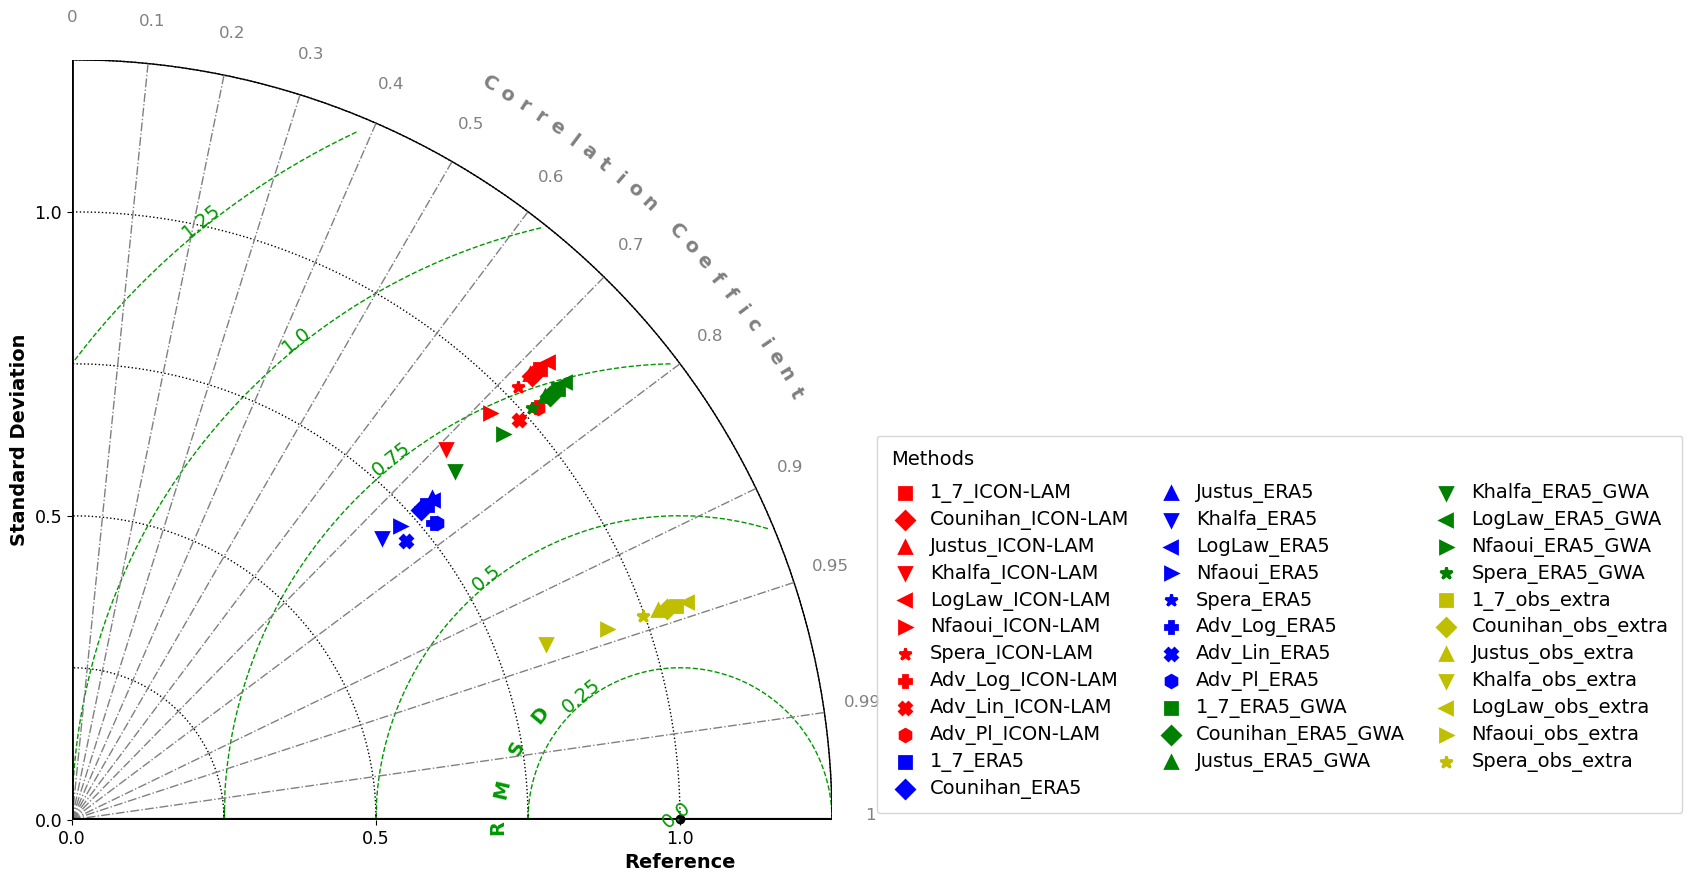

34 34

📊 Taylor Skill Score by methods and dataset at 20m with cut:

                    Skill Score
Method                         
Spera_obs_extra           0.971
Justus_obs_extra          0.970
Counihan_obs_extra        0.970
1_7_obs_extra             0.969
LogLaw_obs_extra          0.967
Nfaoui_obs_extra          0.966
Khalfa_obs_extra          0.936
Adv_Pl_ICON               0.874
Adv_Log_ICON              0.874
Adv_Lin_ICON              0.873
Spera_ERA5_GWA            0.873
Counihan_ERA5_GWA         0.872
Justus_ERA5_GWA           0.871
Nfaoui_ERA5_GWA           0.870
1_7_ERA5_GWA              0.870
LogLaw_ERA5_GWA           0.868
Spera_ICON                0.858
Counihan_ICON             0.858
Nfaoui_ICON               0.857
Justus_ICON               0.856
1_7_ICON                  0.856
LogLaw_ICON               0.854
Khalfa_ERA5_GWA           0.847
Khalfa_ICON               0.837
Adv_Pl_ERA5               0.832
LogLaw_ERA5               0.829
Justus_ERA5               0.828
Adv

In [32]:
import argparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import skill_metrics as sm

args = type('', (), {})()
args.no_show = False
args.no_save = False

# Configuration de l'affichage

rcParams['lines.linewidth'] = 1
rcParams.update({'font.size': 12})
plt.close('all')


# declaration des valeur manuellement
stats0 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "1_7", ["Std_obs"]]
stats1 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats2 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats3 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats4 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats5 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats6 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats7 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats8 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats9 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats10 = icon_mean_metrics_40m_cut.loc[icon_mean_metrics_40m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats11 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats12 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats13 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats14 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats15 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats16 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats17 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats18 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats19 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats20 = ERA5_mean_metrics_40m_cut.loc[ERA5_mean_metrics_40m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats21 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats22 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats23 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats24 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats25 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats26 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats27 = ERA5_GWA_mean_metrics_40m_cut.loc[ERA5_GWA_mean_metrics_40m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats31 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats32 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats33 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats34 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats35 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats36 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats37 = obs_extrapolated_mean_metrics_40m_cut.loc[obs_extrapolated_mean_metrics_40m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]



MARKERS = {
    "1_7_ICON-LAM": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Counihan_ICON-LAM": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Justus_ICON-LAM": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Khalfa_ICON-LAM": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "LogLaw_ICON-LAM": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Nfaoui_ICON-LAM": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Spera_ICON-LAM": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Log_ICON-LAM": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Lin_ICON-LAM": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Pl_ICON-LAM": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "1_7_ERA5": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Counihan_ERA5": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Justus_ERA5": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Khalfa_ERA5": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "LogLaw_ERA5": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Nfaoui_ERA5": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Spera_ERA5": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Log_ERA5": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Lin_ERA5": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Pl_ERA5": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "1_7_ERA5_GWA": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Counihan_ERA5_GWA": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Justus_ERA5_GWA": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Khalfa_ERA5_GWA": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "LogLaw_ERA5_GWA": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Nfaoui_ERA5_GWA": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Spera_ERA5_GWA": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "1_7_obs_extra": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Counihan_obs_extra": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Justus_obs_extra": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Khalfa_obs_extra": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "LogLaw_obs_extra": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Nfaoui_obs_extra": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Spera_obs_extra": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "y", "edgeColor": "y",}
                  }

# Regrouper les valeurs
sdev = np.array([
    stats0['Std_obs'].values[0],
    stats1['Std_pred'].values[0],
    stats2['Std_pred'].values[0],
    stats3['Std_pred'].values[0],
    stats4['Std_pred'].values[0],
    stats5['Std_pred'].values[0],
    stats6['Std_pred'].values[0],
    stats7['Std_pred'].values[0],
    stats8['Std_pred'].values[0],
    stats9['Std_pred'].values[0],
    stats10['Std_pred'].values[0],
    stats11['Std_pred'].values[0],
    stats12['Std_pred'].values[0],
    stats13['Std_pred'].values[0],
    stats14['Std_pred'].values[0],
    stats15['Std_pred'].values[0],
    stats16['Std_pred'].values[0],
    stats17['Std_pred'].values[0],
    stats18['Std_pred'].values[0],
    stats19['Std_pred'].values[0],
    stats20['Std_pred'].values[0],
    stats21['Std_pred'].values[0],
    stats22['Std_pred'].values[0],
    stats23['Std_pred'].values[0],
    stats24['Std_pred'].values[0],
    stats25['Std_pred'].values[0],
    stats26['Std_pred'].values[0],
    stats27['Std_pred'].values[0],
    stats31['Std_pred'].values[0],
    stats32['Std_pred'].values[0],
    stats33['Std_pred'].values[0],
    stats34['Std_pred'].values[0],
    stats35['Std_pred'].values[0],
    stats36['Std_pred'].values[0],
    stats37['Std_pred'].values[0]
])

crmsd = np.array([
    0,
    stats1['CRMSD'].values[0],
    stats2['CRMSD'].values[0],
    stats3['CRMSD'].values[0],
    stats4['CRMSD'].values[0],
    stats5['CRMSD'].values[0],
    stats6['CRMSD'].values[0],
    stats7['CRMSD'].values[0],
    stats8['CRMSD'].values[0],
    stats9['CRMSD'].values[0],
    stats10['CRMSD'].values[0],
    stats11['CRMSD'].values[0],
    stats12['CRMSD'].values[0],
    stats13['CRMSD'].values[0],
    stats14['CRMSD'].values[0],
    stats15['CRMSD'].values[0],
    stats16['CRMSD'].values[0],
    stats17['CRMSD'].values[0],
    stats18['CRMSD'].values[0],
    stats19['CRMSD'].values[0],
    stats20['CRMSD'].values[0],
    stats21['CRMSD'].values[0],
    stats22['CRMSD'].values[0],
    stats23['CRMSD'].values[0],
    stats24['CRMSD'].values[0],
    stats25['CRMSD'].values[0],
    stats26['CRMSD'].values[0],
    stats27['CRMSD'].values[0],
    stats31['CRMSD'].values[0],
    stats32['CRMSD'].values[0],
    stats33['CRMSD'].values[0],
    stats34['CRMSD'].values[0],
    stats35['CRMSD'].values[0],
    stats36['CRMSD'].values[0],
    stats37['CRMSD'].values[0]
])

ccoef = np.array([
    0,
    stats1['Pearson r'].values[0],
    stats2['Pearson r'].values[0],
    stats3['Pearson r'].values[0],
    stats4['Pearson r'].values[0],
    stats5['Pearson r'].values[0],
    stats6['Pearson r'].values[0],
    stats7['Pearson r'].values[0],
    stats8['Pearson r'].values[0],
    stats9['Pearson r'].values[0],
    stats10['Pearson r'].values[0],
    stats11['Pearson r'].values[0],
    stats12['Pearson r'].values[0],
    stats13['Pearson r'].values[0],
    stats14['Pearson r'].values[0],
    stats15['Pearson r'].values[0],
    stats16['Pearson r'].values[0],
    stats17['Pearson r'].values[0],
    stats18['Pearson r'].values[0],
    stats19['Pearson r'].values[0],
    stats20['Pearson r'].values[0],
    stats21['Pearson r'].values[0],
    stats22['Pearson r'].values[0],
    stats23['Pearson r'].values[0],
    stats24['Pearson r'].values[0],
    stats25['Pearson r'].values[0],
    stats26['Pearson r'].values[0],
    stats27['Pearson r'].values[0],
    stats31['Pearson r'].values[0],
    stats32['Pearson r'].values[0],
    stats33['Pearson r'].values[0],
    stats34['Pearson r'].values[0],
    stats35['Pearson r'].values[0],
    stats36['Pearson r'].values[0],
    stats37['Pearson r'].values[0]
])

# 🧮 Normaliser toutes les STD (et CRMSD) par la std de référence
sigma_ref = stats0['Std_obs'].values[0]

sdev_norm = sdev / sigma_ref
crmsd_norm = crmsd / sigma_ref

# Génération du diagramme
sm.taylor_diagram(sdev_norm, crmsd_norm, ccoef, markers = MARKERS,
                  markerLegend = 'on',
                  styleOBS='None',
                  markerOBS='o',
                  titleOBS='Reference',
                  colOBS='black',
                  colCOR='gray',
                  tickRMS = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  tickSTD = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  markerSize=10,)                

ax  = plt.gca()
leg = ax.get_legend()

# 3. Déplace-la en haut et au centre
leg.set_loc('lower left')             # position “center top”
leg.set_bbox_to_anchor((1.05, 0.0))     # 0.5 = milieu en x, 1.15 au-dessus de la boxplot
leg.set_frame_on(True)                  # facultatif : remets un cadre si tu veux

# 🔧 Ajustements pour agrandir visuellement le box
leg.set_title("Methods", prop={'size': 14})
for text in leg.get_texts():
    text.set_fontsize(14)  # Taille du texte
leg._legend_box.sep = 10  # Espacement vertical entre les éléments
leg._legend_box.pad = 10  # Padding interne
leg._legend_box.align = "left"

# Sauvegarde conditionnelle
if not args.no_save:
    plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_diagram_40m_cut.png", bbox_inches='tight')

# Affichage conditionnel
if not args.no_show:
    plt.show()

plt.close()




# --- Normalisation de l'écart type
sdev_norm = sdev / sigma_ref

# --- Corrélation de référence
R0 = 1.0  # valeur par défaut utilisée dans de nombreux articles

# --- Fonction Skill Score de Taylor
def taylor_skill_score(r, sigma_star, r0=1.0):
    numerator = 4 * (1 + r)
    denominator = ((sigma_star + 1/sigma_star)**2) * (1 + r0)
    return numerator / denominator

# --- Calcul
scores = []
for i in range(len(ccoef)):
    r = ccoef[i]
    sigma_star = sdev_norm[i]
    score = taylor_skill_score(r, sigma_star, R0)
    scores.append(score)

# --- Résultat sous forme de DataFrame
method_labels = [
    "1_7_ICON", "Counihan_ICON", "Justus_ICON", "Khalfa_ICON", "LogLaw_ICON", "Nfaoui_ICON", "Spera_ICON",
    "Adv_Log_ICON", "Adv_Lin_ICON", "Adv_Pl_ICON",
    "1_7_ERA5", "Counihan_ERA5", "Justus_ERA5", "Khalfa_ERA5", "LogLaw_ERA5", "Nfaoui_ERA5", "Spera_ERA5",
    "Adv_Log_ERA5", "Adv_Lin_ERA5", "Adv_Pl_ERA5",
    "1_7_ERA5_GWA", "Counihan_ERA5_GWA", "Justus_ERA5_GWA", "Khalfa_ERA5_GWA", "LogLaw_ERA5_GWA", "Nfaoui_ERA5_GWA", "Spera_ERA5_GWA",
    "1_7_obs_extra", "Counihan_obs_extra", "Justus_obs_extra", "Khalfa_obs_extra", "LogLaw_obs_extra", "Nfaoui_obs_extra", "Spera_obs_extra"

]

# on slice scores pour ne garder que les 27 méthodes
method_scores = scores[1:]

print(len(method_labels), len(method_scores))  # 27, 27

skill_40m_cut_df = pd.DataFrame({
    "Method": method_labels,
    "Skill Score": method_scores
}).set_index("Method").sort_values("Skill Score", ascending=False)

# --- Affichage
print("\n📊 Taylor Skill Score by methods and dataset at 20m with cut:\n")
print(skill_40m_cut_df.round(3))

# --- Export
skill_40m_cut_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_skill_scores_40m_cut.xlsx")


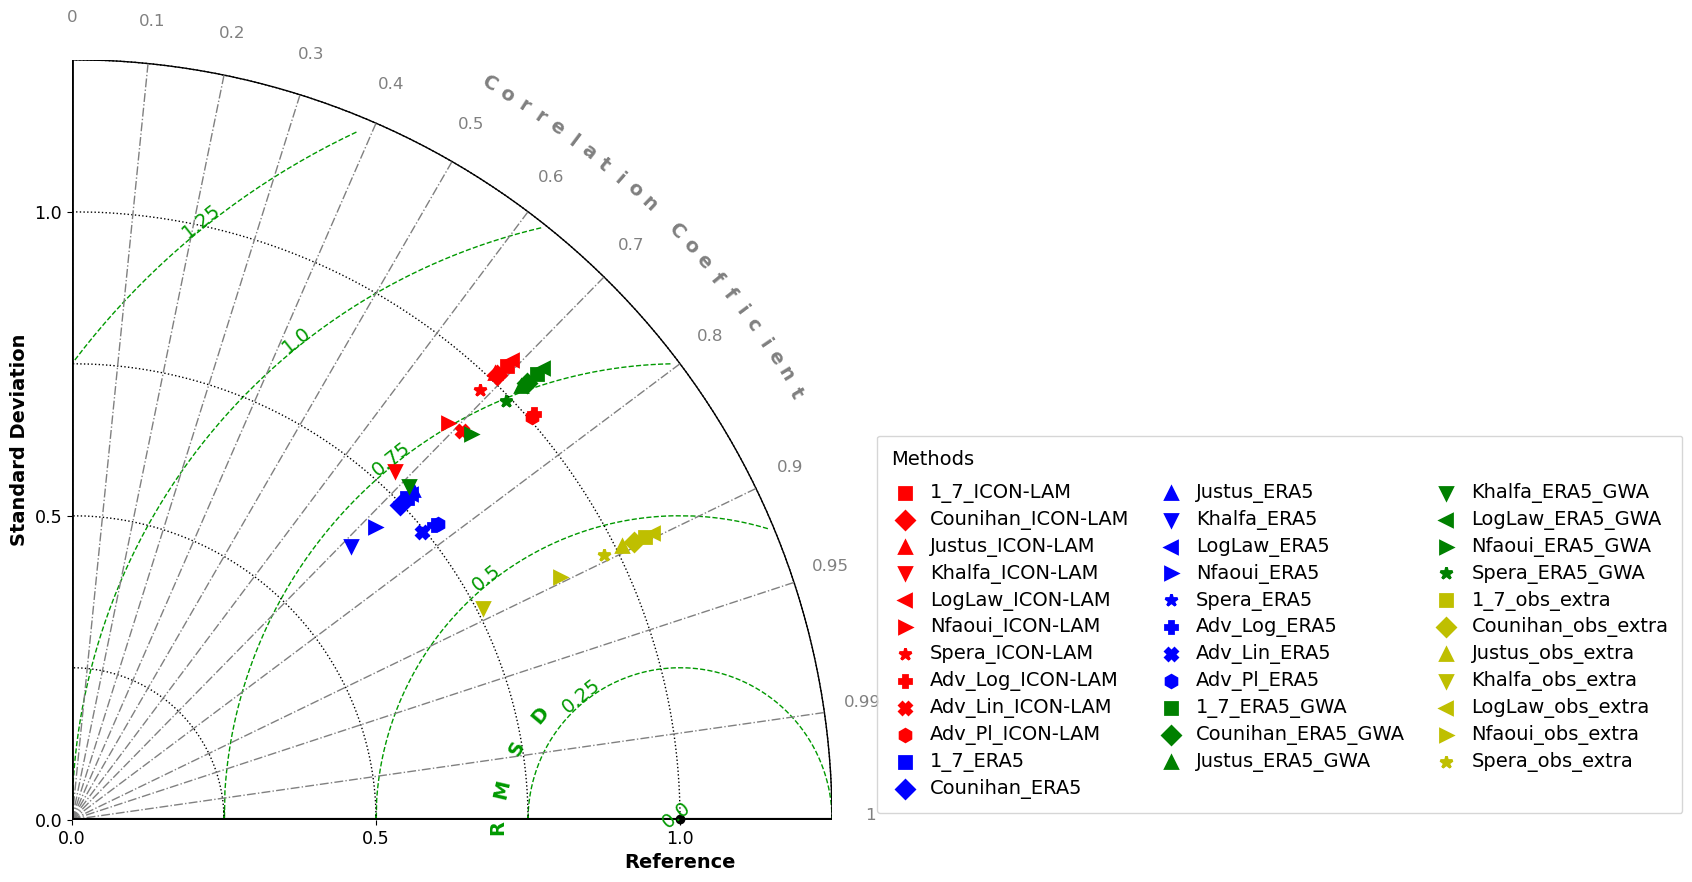

34 34

📊 Taylor Skill Score by methods and dataset at 60m with cut:

                    Skill Score
Method                         
Justus_obs_extra          0.947
Counihan_obs_extra        0.947
Spera_obs_extra           0.947
1_7_obs_extra             0.946
LogLaw_obs_extra          0.944
Nfaoui_obs_extra          0.937
Khalfa_obs_extra          0.877
Adv_Pl_ICON               0.876
Adv_Log_ICON              0.875
Spera_ERA5_GWA            0.860
Counihan_ERA5_GWA         0.860
Justus_ERA5_GWA           0.859
1_7_ERA5_GWA              0.858
LogLaw_ERA5_GWA           0.856
Nfaoui_ERA5_GWA           0.852
Adv_Lin_ICON              0.846
Counihan_ICON             0.846
1_7_ICON                  0.845
LogLaw_ICON               0.844
Justus_ICON               0.844
Spera_ICON                0.844
Nfaoui_ICON               0.835
Adv_Pl_ERA5               0.833
Adv_Log_ERA5              0.829
Adv_Lin_ERA5              0.814
Justus_ERA5               0.809
LogLaw_ERA5               0.806
Kha

In [33]:
import argparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import skill_metrics as sm

args = type('', (), {})()
args.no_show = False
args.no_save = False

# Configuration de l'affichage

rcParams['lines.linewidth'] = 1
rcParams.update({'font.size': 12})
plt.close('all')


# declaration des valeur manuellement
stats0 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "1_7", ["Std_obs"]]
stats1 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats2 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats3 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats4 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats5 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats6 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats7 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats8 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats9 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats10 = icon_mean_metrics_60m_cut.loc[icon_mean_metrics_60m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats11 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats12 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats13 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats14 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats15 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats16 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats17 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats18 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats19 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats20 = ERA5_mean_metrics_60m_cut.loc[ERA5_mean_metrics_60m_cut["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats21 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats22 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats23 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats24 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats25 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats26 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats27 = ERA5_GWA_mean_metrics_60m_cut.loc[ERA5_GWA_mean_metrics_60m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats31 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats32 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats33 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats34 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats35 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats36 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats37 = obs_extrapolated_mean_metrics_60m_cut.loc[obs_extrapolated_mean_metrics_60m_cut["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]



MARKERS = {
    "1_7_ICON-LAM": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Counihan_ICON-LAM": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Justus_ICON-LAM": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Khalfa_ICON-LAM": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "LogLaw_ICON-LAM": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Nfaoui_ICON-LAM": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Spera_ICON-LAM": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Log_ICON-LAM": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Lin_ICON-LAM": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Pl_ICON-LAM": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "1_7_ERA5": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Counihan_ERA5": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Justus_ERA5": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Khalfa_ERA5": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "LogLaw_ERA5": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Nfaoui_ERA5": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Spera_ERA5": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Log_ERA5": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Lin_ERA5": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Pl_ERA5": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "1_7_ERA5_GWA": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Counihan_ERA5_GWA": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Justus_ERA5_GWA": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Khalfa_ERA5_GWA": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "LogLaw_ERA5_GWA": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Nfaoui_ERA5_GWA": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Spera_ERA5_GWA": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "1_7_obs_extra": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Counihan_obs_extra": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Justus_obs_extra": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Khalfa_obs_extra": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "LogLaw_obs_extra": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Nfaoui_obs_extra": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Spera_obs_extra": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "y", "edgeColor": "y",}
                  }

# Regrouper les valeurs
sdev = np.array([
    stats0['Std_obs'].values[0],
    stats1['Std_pred'].values[0],
    stats2['Std_pred'].values[0],
    stats3['Std_pred'].values[0],
    stats4['Std_pred'].values[0],
    stats5['Std_pred'].values[0],
    stats6['Std_pred'].values[0],
    stats7['Std_pred'].values[0],
    stats8['Std_pred'].values[0],
    stats9['Std_pred'].values[0],
    stats10['Std_pred'].values[0],
    stats11['Std_pred'].values[0],
    stats12['Std_pred'].values[0],
    stats13['Std_pred'].values[0],
    stats14['Std_pred'].values[0],
    stats15['Std_pred'].values[0],
    stats16['Std_pred'].values[0],
    stats17['Std_pred'].values[0],
    stats18['Std_pred'].values[0],
    stats19['Std_pred'].values[0],
    stats20['Std_pred'].values[0],
    stats21['Std_pred'].values[0],
    stats22['Std_pred'].values[0],
    stats23['Std_pred'].values[0],
    stats24['Std_pred'].values[0],
    stats25['Std_pred'].values[0],
    stats26['Std_pred'].values[0],
    stats27['Std_pred'].values[0],
    stats31['Std_pred'].values[0],
    stats32['Std_pred'].values[0],
    stats33['Std_pred'].values[0],
    stats34['Std_pred'].values[0],
    stats35['Std_pred'].values[0],
    stats36['Std_pred'].values[0],
    stats37['Std_pred'].values[0]
])

crmsd = np.array([
    0,
    stats1['CRMSD'].values[0],
    stats2['CRMSD'].values[0],
    stats3['CRMSD'].values[0],
    stats4['CRMSD'].values[0],
    stats5['CRMSD'].values[0],
    stats6['CRMSD'].values[0],
    stats7['CRMSD'].values[0],
    stats8['CRMSD'].values[0],
    stats9['CRMSD'].values[0],
    stats10['CRMSD'].values[0],
    stats11['CRMSD'].values[0],
    stats12['CRMSD'].values[0],
    stats13['CRMSD'].values[0],
    stats14['CRMSD'].values[0],
    stats15['CRMSD'].values[0],
    stats16['CRMSD'].values[0],
    stats17['CRMSD'].values[0],
    stats18['CRMSD'].values[0],
    stats19['CRMSD'].values[0],
    stats20['CRMSD'].values[0],
    stats21['CRMSD'].values[0],
    stats22['CRMSD'].values[0],
    stats23['CRMSD'].values[0],
    stats24['CRMSD'].values[0],
    stats25['CRMSD'].values[0],
    stats26['CRMSD'].values[0],
    stats27['CRMSD'].values[0],
    stats31['CRMSD'].values[0],
    stats32['CRMSD'].values[0],
    stats33['CRMSD'].values[0],
    stats34['CRMSD'].values[0],
    stats35['CRMSD'].values[0],
    stats36['CRMSD'].values[0],
    stats37['CRMSD'].values[0]
])

ccoef = np.array([
    0,
    stats1['Pearson r'].values[0],
    stats2['Pearson r'].values[0],
    stats3['Pearson r'].values[0],
    stats4['Pearson r'].values[0],
    stats5['Pearson r'].values[0],
    stats6['Pearson r'].values[0],
    stats7['Pearson r'].values[0],
    stats8['Pearson r'].values[0],
    stats9['Pearson r'].values[0],
    stats10['Pearson r'].values[0],
    stats11['Pearson r'].values[0],
    stats12['Pearson r'].values[0],
    stats13['Pearson r'].values[0],
    stats14['Pearson r'].values[0],
    stats15['Pearson r'].values[0],
    stats16['Pearson r'].values[0],
    stats17['Pearson r'].values[0],
    stats18['Pearson r'].values[0],
    stats19['Pearson r'].values[0],
    stats20['Pearson r'].values[0],
    stats21['Pearson r'].values[0],
    stats22['Pearson r'].values[0],
    stats23['Pearson r'].values[0],
    stats24['Pearson r'].values[0],
    stats25['Pearson r'].values[0],
    stats26['Pearson r'].values[0],
    stats27['Pearson r'].values[0],
    stats31['Pearson r'].values[0],
    stats32['Pearson r'].values[0],
    stats33['Pearson r'].values[0],
    stats34['Pearson r'].values[0],
    stats35['Pearson r'].values[0],
    stats36['Pearson r'].values[0],
    stats37['Pearson r'].values[0]
])

# 🧮 Normaliser toutes les STD (et CRMSD) par la std de référence
sigma_ref = stats0['Std_obs'].values[0]

sdev_norm = sdev / sigma_ref
crmsd_norm = crmsd / sigma_ref

# Génération du diagramme
sm.taylor_diagram(sdev_norm, crmsd_norm, ccoef, markers = MARKERS,
                  markerLegend = 'on',
                  styleOBS='None',
                  markerOBS='o',
                  titleOBS='Reference',
                  colOBS='black',
                  colCOR='gray',
                  tickRMS = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  tickSTD = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  markerSize=10,)                

ax  = plt.gca()
leg = ax.get_legend()

# 3. Déplace-la en haut et au centre
leg.set_loc('lower left')             # position “center top”
leg.set_bbox_to_anchor((1.05, 0.0))     # 0.5 = milieu en x, 1.15 au-dessus de la boxplot
leg.set_frame_on(True)                  # facultatif : remets un cadre si tu veux

# 🔧 Ajustements pour agrandir visuellement le box
leg.set_title("Methods", prop={'size': 14})
for text in leg.get_texts():
    text.set_fontsize(14)  # Taille du texte
leg._legend_box.sep = 10  # Espacement vertical entre les éléments
leg._legend_box.pad = 10  # Padding interne
leg._legend_box.align = "left"

# Sauvegarde conditionnelle
if not args.no_save:
    plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_diagram_60m_cut.png", bbox_inches='tight')

# Affichage conditionnel
if not args.no_show:
    plt.show()

plt.close()




# --- Normalisation de l'écart type
sdev_norm = sdev / sigma_ref

# --- Corrélation de référence
R0 = 1.0  # valeur par défaut utilisée dans de nombreux articles

# --- Fonction Skill Score de Taylor
def taylor_skill_score(r, sigma_star, r0=1.0):
    numerator = 4 * (1 + r)
    denominator = ((sigma_star + 1/sigma_star)**2) * (1 + r0)
    return numerator / denominator

# --- Calcul
scores = []
for i in range(len(ccoef)):
    r = ccoef[i]
    sigma_star = sdev_norm[i]
    score = taylor_skill_score(r, sigma_star, R0)
    scores.append(score)

# --- Résultat sous forme de DataFrame
method_labels = [
    "1_7_ICON", "Counihan_ICON", "Justus_ICON", "Khalfa_ICON", "LogLaw_ICON", "Nfaoui_ICON", "Spera_ICON",
    "Adv_Log_ICON", "Adv_Lin_ICON", "Adv_Pl_ICON",
    "1_7_ERA5", "Counihan_ERA5", "Justus_ERA5", "Khalfa_ERA5", "LogLaw_ERA5", "Nfaoui_ERA5", "Spera_ERA5",
    "Adv_Log_ERA5", "Adv_Lin_ERA5", "Adv_Pl_ERA5",
    "1_7_ERA5_GWA", "Counihan_ERA5_GWA", "Justus_ERA5_GWA", "Khalfa_ERA5_GWA", "LogLaw_ERA5_GWA", "Nfaoui_ERA5_GWA", "Spera_ERA5_GWA",
    "1_7_obs_extra", "Counihan_obs_extra", "Justus_obs_extra", "Khalfa_obs_extra", "LogLaw_obs_extra", "Nfaoui_obs_extra", "Spera_obs_extra"

]

# on slice scores pour ne garder que les 27 méthodes
method_scores = scores[1:]

print(len(method_labels), len(method_scores))  # 27, 27

skill_60m_cut_df = pd.DataFrame({
    "Method": method_labels,
    "Skill Score": method_scores
}).set_index("Method").sort_values("Skill Score", ascending=False)

# --- Affichage
print("\n📊 Taylor Skill Score by methods and dataset at 60m with cut:\n")
print(skill_60m_cut_df.round(3))

# --- Export
skill_60m_cut_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_skill_scores_60m_cut.xlsx")


In [34]:
import pandas as pd
import numpy as np
import os

# ⚙️ Constantes physiques
rho = 1.225  # kg/m³
cut_in = 2.0
cut_out = 25.0

# 🌀 Liste des colonnes de l'observation
wind_columns_obs = ["WS_10_mean", "WS_20_mean", "WS_40_mean", "WS_60_mean"]

# 📦 Stockage de l'énergie observée
wind_energy_obs = {}

for station, df in obs_WM_dict.items():
    energy_by_col = {}

    for col in wind_columns_obs:
        if col not in df.columns:
            continue

        ws_series = df[col].dropna()
        ws_valid = ws_series[(ws_series >= cut_in) & (ws_series <= cut_out)]

        # ⚡️ Énergie = 0.5 * rho * v³ (en MJ)
        energy = 0.5 * rho * (ws_valid**3).sum() / 1000000
        energy_by_col[col] = energy

    wind_energy_obs[station] = energy_by_col

# 📄 Fusionner tous les résultats obs
combined_obs_df = pd.DataFrame.from_dict(wind_energy_obs, orient='index')
combined_obs_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy\wind_energy_obs_all_stations_merged.xlsx", sheet_name='Observation')


# 🌀 Liste des colonnes prédictives ICON
wind_columns_ICON = [
    "WS_10_ICON-LAM", "WS_20_1_7", "WS_20_Counihan", "WS_20_Justus", "WS_20_Khalfa", "WS_20_LogLaw", "WS_20_Spera", "WS_20_Nfaoui", "WS_20_Adv_Lin", "WS_20_Adv_Pl", "WS_20_Adv_Log",
    "WS_40_1_7", "WS_40_Counihan", "WS_40_Justus", "WS_40_Khalfa", "WS_40_LogLaw", "WS_40_Spera", "WS_40_Nfaoui", "WS_40_Adv_Lin", "WS_40_Adv_Pl", "WS_40_Adv_Log",
    "WS_60_1_7", "WS_60_Counihan", "WS_60_Justus", "WS_60_Khalfa", "WS_60_LogLaw", "WS_60_Spera", "WS_60_Nfaoui", "WS_60_Adv_Lin", "WS_60_Adv_Pl", "WS_60_Adv_Log",
]

# 📦 Stockage énergie prédite (ICON-LAM)
wind_energy_ICON = {}

for station, pred_df in ICON_all_data_fused.items():
    if station not in obs_WM_dict:
        continue

    obs_df = obs_WM_dict[station].copy()
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    energy_by_col = {}

    for col in wind_columns_ICON:
        if col not in pred_df.columns:
            continue

        height = col.split('_')[1]
        obs_key = f"WS_{height}_mean" if height != "10" else "WS_10_mean"

        if obs_key not in obs_df.columns:
            continue

        # 🎯 Etape 1 : filtre sur l’observation
        obs_series = obs_df[obs_key].dropna()
        obs_valid = obs_series[(obs_series >= cut_in) & (obs_series <= cut_out)]
        valid_index = obs_valid.index

        # 🎯 Etape 2 : alignement prédiction
        pred_series = pred_df[col].reindex(valid_index).dropna()

        # ⚡️ Énergie si données valides
        if len(pred_series) == 0:
            continue

        energy = 0.5 * rho * (pred_series**3).sum() / 1000000
        energy_by_col[col] = energy

    wind_energy_ICON[station] = energy_by_col

# 📄 Fusionner les résultats prédits
combined_pred_df = pd.DataFrame.from_dict(wind_energy_ICON, orient='index')
combined_pred_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy\wind_energy_ICON-LAM_all_stations_merged.xlsx", sheet_name='ICON-LAM')



wind_columns_ERA5 = ["WS_10_ERA5", "WS_20_1_7", "WS_20_Counihan", "WS_20_Justus", "WS_20_Khalfa", "WS_20_LogLaw", "WS_20_Spera", "WS_20_Nfaoui", "WS_20_Adv_Lin", "WS_20_Adv_Pl", "WS_20_Adv_Log",
    "WS_40_1_7", "WS_40_Counihan", "WS_40_Justus", "WS_40_Khalfa", "WS_40_LogLaw", "WS_40_Spera", "WS_40_Nfaoui", "WS_40_Adv_Lin", "WS_40_Adv_Pl", "WS_40_Adv_Log",
    "WS_60_1_7", "WS_60_Counihan", "WS_60_Justus", "WS_60_Khalfa", "WS_60_LogLaw", "WS_60_Spera", "WS_60_Nfaoui", "WS_60_Adv_Lin", "WS_60_Adv_Pl", "WS_60_Adv_Log",
]

wind_energy_ERA5 = {}

for station, pred_df in ERA5_all_data_fused.items():
    if station not in obs_WM_dict:
        continue  # 🔁 On ne garde que les stations présentes aussi côté observation

    obs_df = obs_WM_dict[station].copy()
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    energy_by_col = {}

    for col in wind_columns_ERA5:
        if col not in pred_df.columns:
            continue

        height = col.split('_')[1]
        obs_key = f"WS_{height}_mean" if height != "10" else "WS_10_mean"

        if obs_key not in obs_df.columns:
            continue

        # 🎯 Etape 1 : filtre sur l’observation
        obs_series = obs_df[obs_key].dropna()
        obs_valid = obs_series[(obs_series >= cut_in) & (obs_series <= cut_out)]
        valid_index = obs_valid.index

        # 🎯 Etape 2 : alignement prédiction
        pred_series = pred_df[col].reindex(valid_index).dropna()

        # ⚡️ Énergie si données valides
        if len(pred_series) == 0:
            continue

        energy = 0.5 * rho * (pred_series**3).sum() / 1000000
        energy_by_col[col] = energy

    wind_energy_ERA5[station] = energy_by_col

# 📄 Fusionner les résultats prédits
combined_pred_df = pd.DataFrame.from_dict(wind_energy_ERA5, orient='index')
combined_pred_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy\wind_energy_ERA5_all_stations_merged.xlsx", sheet_name='ERA5')

wind_columns_ERA5_GWA = ["WS_10_ERA5_GWA", "WS_20_1_7", "WS_20_Counihan", "WS_20_Justus", "WS_20_Khalfa", "WS_20_LogLaw", "WS_20_Spera", "WS_20_Nfaoui",
                        "WS_40_1_7", "WS_40_Counihan", "WS_40_Justus", "WS_40_Khalfa", "WS_40_LogLaw", "WS_40_Spera", "WS_40_Nfaoui", 
                        "WS_60_1_7", "WS_60_Counihan", "WS_60_Justus", "WS_60_Khalfa", "WS_60_LogLaw", "WS_60_Spera", "WS_60_Nfaoui",
]

wind_energy_ERA5_GWA = {}

for station, pred_df in ERA5_GWA_all_data_fused.items():
    if station not in obs_WM_dict:
        continue  # 🔁 On ne garde que les stations présentes aussi côté observation

    obs_df = obs_WM_dict[station].copy()
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    energy_by_col = {}

    for col in wind_columns_ERA5_GWA:
        if col not in pred_df.columns:
            continue

        height = col.split('_')[1]
        obs_key = f"WS_{height}_mean" if height != "10" else "WS_10_mean"

        if obs_key not in obs_df.columns:
            continue

        # 🎯 Etape 1 : filtre sur l’observation
        obs_series = obs_df[obs_key].dropna()
        obs_valid = obs_series[(obs_series >= cut_in) & (obs_series <= cut_out)]
        valid_index = obs_valid.index

        # 🎯 Etape 2 : alignement prédiction
        pred_series = pred_df[col].reindex(valid_index).dropna()

        # ⚡️ Énergie si données valides
        if len(pred_series) == 0:
            continue

        energy = 0.5 * rho * (pred_series**3).sum() / 1000000
        energy_by_col[col] = energy

    wind_energy_ERA5_GWA[station] = energy_by_col

# 📄 Fusionner les résultats prédits
combined_pred_df = pd.DataFrame.from_dict(wind_energy_ERA5_GWA, orient='index')
combined_pred_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy\wind_energy_ERA5_GWA_all_stations_merged.xlsx", sheet_name='ERA5')


wind_columns_obs_extrapolated = ["WS_20_1_7", "WS_20_Counihan", "WS_20_Justus", "WS_20_Khalfa", "WS_20_LogLaw", "WS_20_Spera", "WS_20_Nfaoui",  
                                 "WS_40_1_7", "WS_40_Counihan", "WS_40_Justus", "WS_40_Khalfa", "WS_40_LogLaw", "WS_40_Spera", "WS_40_Nfaoui",  
                                 "WS_60_1_7", "WS_60_Counihan", "WS_60_Justus", "WS_60_Khalfa", "WS_60_LogLaw", "WS_60_Spera", "WS_60_Nfaoui"]

wind_energy_obs_extrapolated = {}

for station, pred_df in  obs_extrapolated_WM_dict.items():
    if station not in obs_WM_dict:
        continue  # 🔁 On ne garde que les stations présentes aussi côté observation

    obs_df = obs_WM_dict[station].copy()
    obs_df.index = pd.to_datetime(obs_df.index).tz_localize(None)
    pred_df.index = pd.to_datetime(pred_df.index).tz_localize(None)

    energy_by_col = {}

    for col in wind_columns_obs_extrapolated:
        if col not in pred_df.columns:
            continue

        height = col.split('_')[1]
        obs_key = f"WS_{height}_mean" if height != "10" else "WS_10_mean"

        if obs_key not in obs_df.columns:
            continue

        # 🎯 Etape 1 : filtre sur l’observation
        obs_series = obs_df[obs_key].dropna()
        obs_valid = obs_series[(obs_series >= cut_in) & (obs_series <= cut_out)]
        valid_index = obs_valid.index

        # 🎯 Etape 2 : alignement prédiction
        pred_series = pred_df[col].reindex(valid_index).dropna()

        # ⚡️ Énergie si données valides
        if len(pred_series) == 0:
            continue

        energy = 0.5 * rho * (pred_series**3).sum() / 1000000
        energy_by_col[col] = energy

    wind_energy_obs_extrapolated[station] = energy_by_col

# 📄 Fusionner les résultats prédits
combined_pred_df = pd.DataFrame.from_dict(wind_energy_obs_extrapolated, orient='index')
combined_pred_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy\wind_energy_obs_extrapolated_all_stations_merged.xlsx", sheet_name='ERA5')


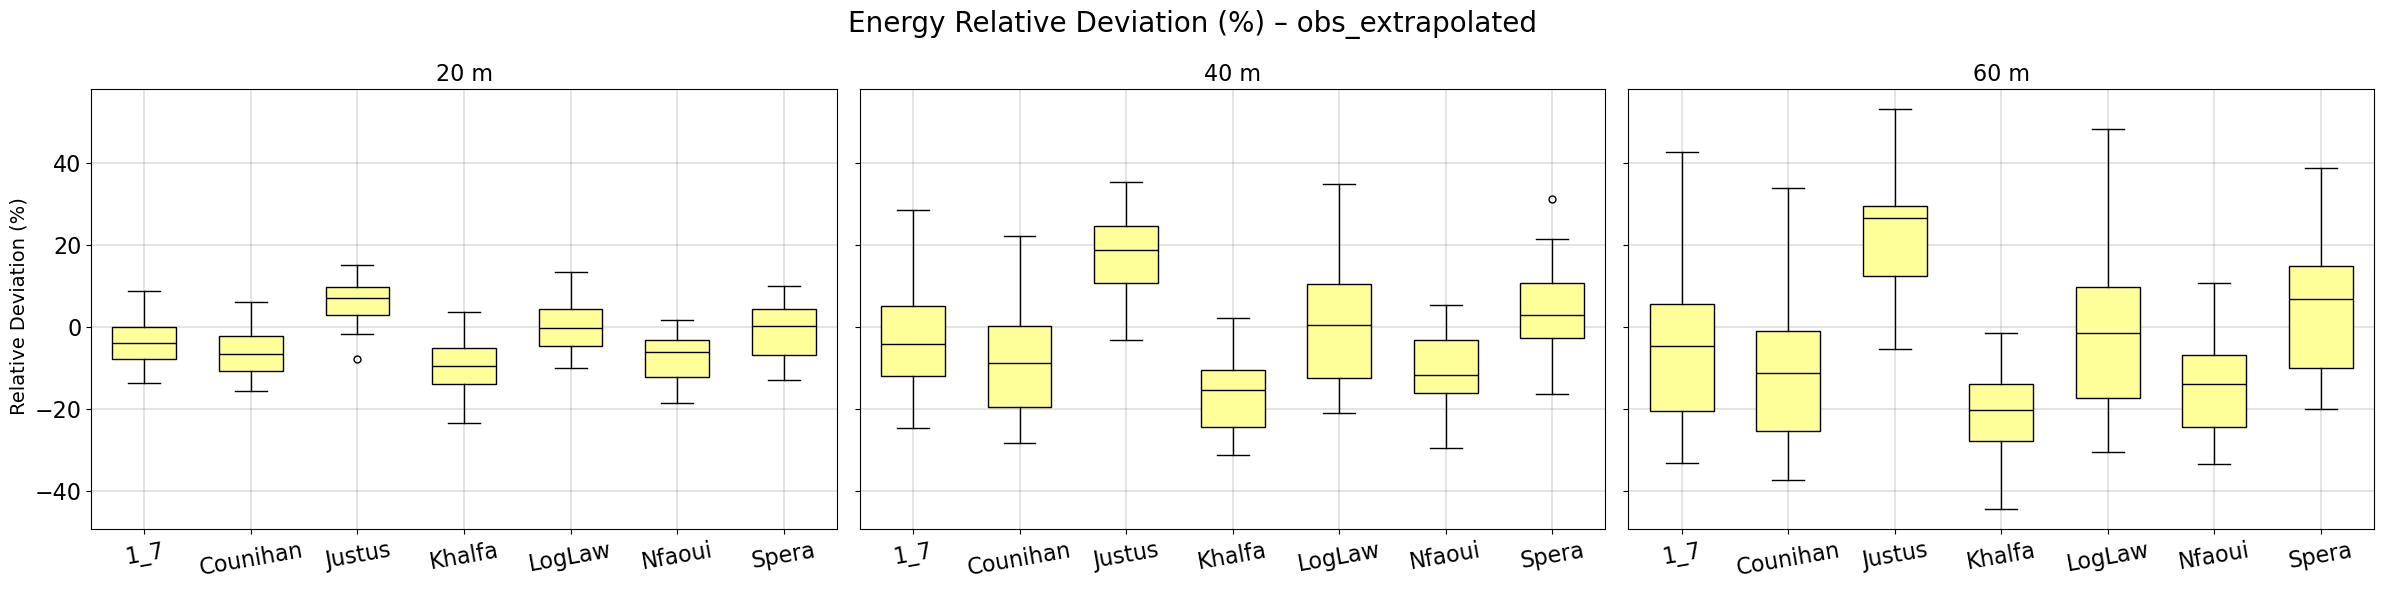

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 📂 Chemins vers les fichiers d’énergie
base = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy"
df_obs  = pd.read_excel(f"{base}\\wind_energy_obs_all_stations_merged.xlsx",  index_col=0)
df_extr = pd.read_excel(f"{base}\\wind_energy_obs_extrapolated_all_stations_merged.xlsx", index_col=0)

# 🔧 Méthodes et exclusions
methods        = ["1_7","Counihan","Justus","Khalfa","LogLaw","Nfaoui","Spera"]
exclusions     = {20: ["WM10"], 40: ["WM05","WM10"], 60: ["WM10"]}

# 🎨 Style des boîtes
facecolor  = "#ffff99"  # jaune clair
edgecolor  = "black"
medianprops= dict(color='black')
whiskerprops=dict(color='black')
capprops   = dict(color='black')
flierprops = dict(marker='o', color='black', markersize=5)

# 📊 Création de la figure et des 3 sous-plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
plt.suptitle("Energy Relative Deviation (%) – obs_extrapolated", fontsize=20)

for ax, h in zip(axes, [20, 40, 60]):
    excl = exclusions[h]
    data = []
    
    # collecter la déviation pour chaque méthode
    for m in methods:
        devs = []
        for st in df_obs.index:
            if st in excl: 
                continue
            col_obs  = f"WS_{h}_mean"
            col_extr = f"WS_{h}_{m}"
            
            if col_obs not in df_obs.columns or col_extr not in df_extr.columns:
                continue
            
            e_obs  = df_obs.loc[st, col_obs]
            e_extr = df_extr.loc[st, col_extr]
            
            if pd.notna(e_obs) and e_obs != 0:
                devs.append((e_extr - e_obs) / e_obs * 100)
        
        data.append(devs)

    # tracer le boxplot
    box = ax.boxplot(
        data,
        positions=range(1, len(methods)+1),
        widths=0.6,
        patch_artist=True,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        flierprops=flierprops
    )
    
    # mise en couleur
    for patch in box['boxes']:
        patch.set_facecolor(facecolor)
        patch.set_edgecolor(edgecolor)
    
    # labels x
    ax.set_xticks(range(1, len(methods)+1))
    ax.set_xticklabels(methods, rotation=10, fontsize=16)
    ax.set_title(f"{h} m", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
    ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
   
    if h == 20:
        ax.set_ylabel(" Relative Deviation (%)", fontsize=14)

# ajustement et sauvegarde
plt.tight_layout(rect=[0, 0.00, 1, 1])
out = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extr_energy_deviation.png"
plt.savefig(out, dpi=300)
plt.show()

In [58]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers d’énergie
base = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy"
df_obs  = pd.read_excel(f"{base}\\wind_energy_obs_all_stations_merged.xlsx",  index_col=0)
df_extr = pd.read_excel(f"{base}\\wind_energy_obs_extrapolated_all_stations_merged.xlsx", index_col=0)

# 🔧 Méthodes et exclusions
methods     = ["1_7","Counihan","Justus","Khalfa","LogLaw","Nfaoui","Spera"]
exclusions  = {20: ["WM10"], 40: ["WM05","WM10"], 60: ["WM10"]}

# 📦 Stockage des résultats
records = []

for h in [20, 40, 60]:
    excl = exclusions[h]
    for m in methods:
        deviations = []
        for st in df_obs.index:
            if st in excl:
                continue
            col_obs  = f"WS_{h}_mean"
            col_extr = f"WS_{h}_{m}"
            if col_obs not in df_obs.columns or col_extr not in df_extr.columns:
                continue
            e_obs  = df_obs.loc[st, col_obs]
            e_extr = df_extr.loc[st, col_extr]
            if pd.notna(e_obs) and e_obs != 0:
                deviations.append((e_extr - e_obs) / e_obs * 100)
        if deviations:
            q25, q50, q75 = np.percentile(deviations, [25, 50, 75])
            records.append({
                "Height": h,
                "Method": m,
                "Q25": round(q25, 3),
                "Q50": round(q50, 3),
                "Q75": round(q75, 3),
                "N": len(deviations)
            })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage complet
pd.set_option('display.max_rows', 100)
print("\n📊 Quartiles de la déviation relative d’énergie (%)\n")
print(quartile_df)

# 💾 Sauvegarde
quartile_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\obs_extr_energy_deviation_quartiles.xlsx", index=False)



📊 Quartiles de la déviation relative d’énergie (%)

    Height    Method     Q25     Q50     Q75   N
0       20       1_7  -7.777  -4.027   0.003  17
1       20  Counihan -10.703  -6.652  -2.320  17
2       20    Justus   2.887   7.047   9.619  17
3       20    Khalfa -13.895  -9.648  -5.147  17
4       20    LogLaw  -4.616  -0.289   4.338  17
5       20    Nfaoui -12.312  -6.034  -3.279  17
6       20     Spera  -6.929   0.253   4.301  17
7       40       1_7 -11.901  -4.237   5.206  16
8       40  Counihan -19.513  -8.878   0.106  16
9       40    Justus  10.822  18.650  24.577  16
10      40    Khalfa -24.353 -15.404 -10.426  16
11      40    LogLaw -12.360   0.464  10.370  16
12      40    Nfaoui -16.223 -11.604  -3.217  16
13      40     Spera  -2.772   2.835  10.791  16
14      60       1_7 -20.424  -4.601   5.693  17
15      60  Counihan -25.374 -11.114  -0.881  17
16      60    Justus  12.376  26.596  29.527  17
17      60    Khalfa -27.910 -20.317 -13.995  17
18      60    Lo

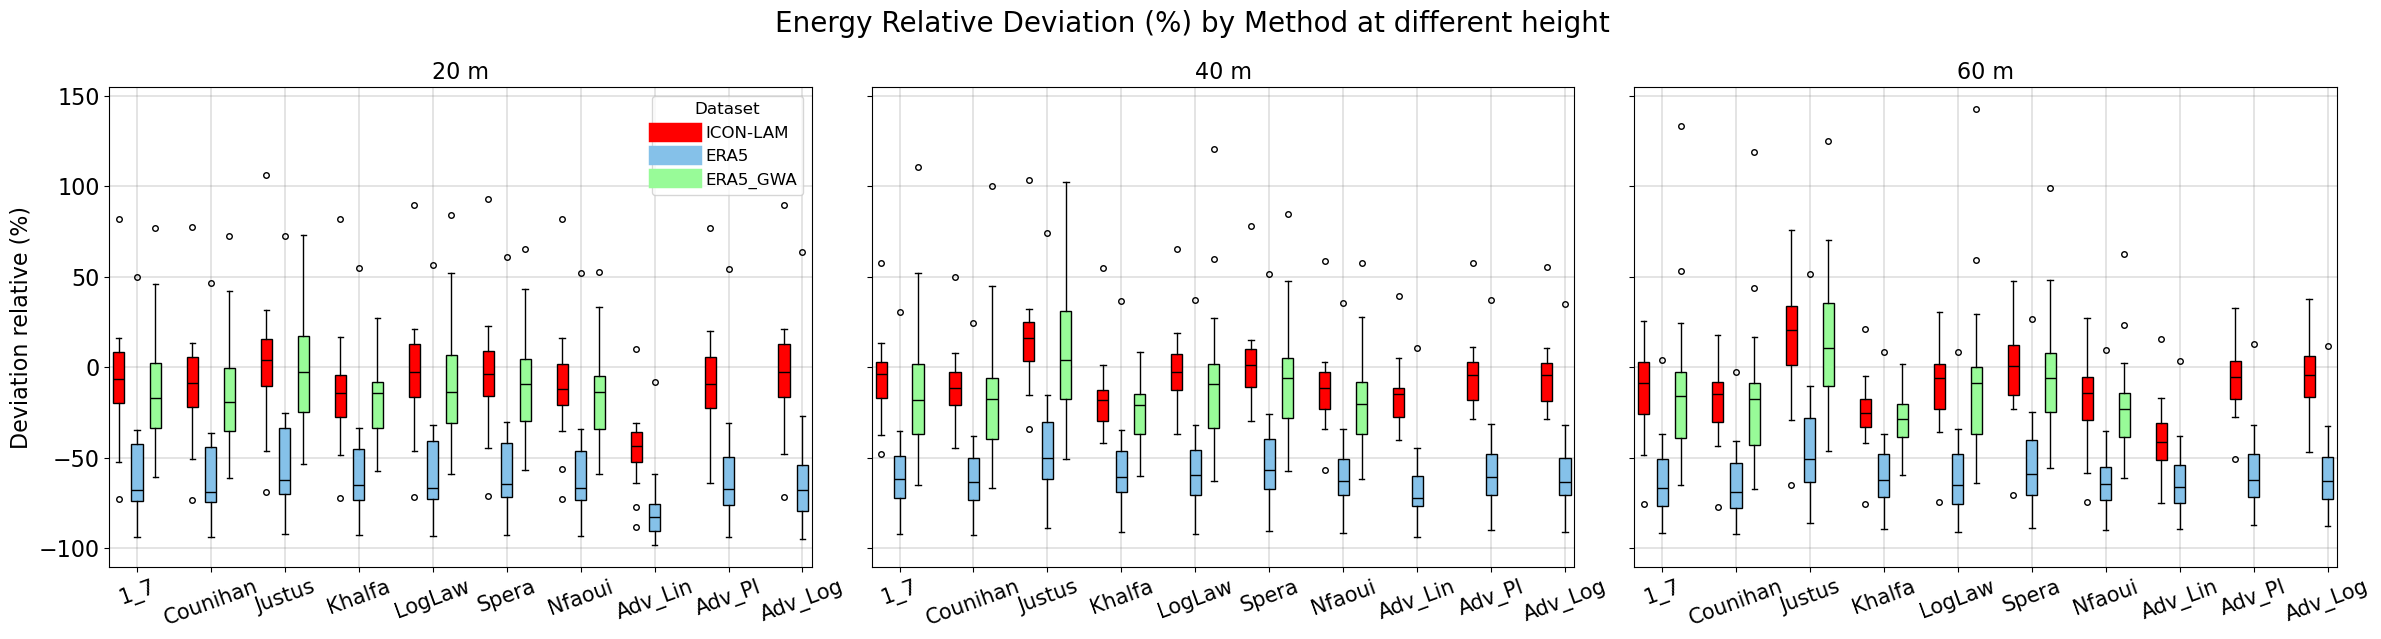

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 📂 Chemins vers tes fichiers d'énergie
base = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy"
df_obs  = pd.read_excel(f"{base}\\wind_energy_obs_all_stations_merged.xlsx",  index_col=0)
df_icon = pd.read_excel(f"{base}\\wind_energy_ICON-LAM_all_stations_merged.xlsx", index_col=0)
df_era5 = pd.read_excel(f"{base}\\wind_energy_ERA5_all_stations_merged.xlsx",    index_col=0)
df_gwa  = pd.read_excel(f"{base}\\wind_energy_ERA5_GWA_all_stations_merged.xlsx",index_col=0)

# Méthodes et datasets
methods          = ["1_7","Counihan","Justus","Khalfa","LogLaw","Spera","Nfaoui","Adv_Lin", "Adv_Pl", "Adv_Log"]
datasets         = ["ICON-LAM","ERA5","ERA5_GWA"]
energy_dfs       = {"ICON-LAM": df_icon, "ERA5": df_era5, "ERA5_GWA": df_gwa}
methods_by_ds    = {"ICON-LAM": methods, "ERA5": methods, "ERA5_GWA": methods[:7]}  # GWA n'a pas lg/ln/pl
colors           = {"ICON-LAM": "red", "ERA5": "#85C1E9", "ERA5_GWA": "#98FB98"}    # vert clair
exclusions_by_h  = {20: ["WM10"], 40: ["WM05","WM10"], 60: []}

# Création de la figure
fig, axes = plt.subplots(1, 3, figsize=(24, 6.5), sharey=True)
plt.suptitle("Energy Relative Deviation (%) by Method at different height", fontsize=20)

for ax, height in zip(axes, [20, 40, 60]):
    exclude = exclusions_by_h[height]
    group_space = len(datasets) + 1
    positions   = []
    box_data    = []
    box_colors  = []

    # boucle sur chaque méthode
    for i, method in enumerate(methods):
        # pour chaque dataset on collecte les deviations
        for j, ds in enumerate(datasets):
            if method not in methods_by_ds[ds]:
                continue

            data = []
            df_pred = energy_dfs[ds]

            for station in df_obs.index:
                if station in exclude: 
                    continue
                # énergie obs
                e_obs_col  = f"WS_{height}_mean"
                if e_obs_col not in df_obs.columns:
                    continue
                e_obs = df_obs.loc[station, e_obs_col]

                # énergie prédite
                col_pred = f"WS_{height}_{method}"
                if col_pred not in df_pred.columns:
                    continue
                e_pred = df_pred.loc[station, col_pred]

                # déviation relative
                if e_obs != 0:
                    data.append((e_pred - e_obs) / e_obs * 100)

            if data:
                pos = i * group_space + j
                positions.append(pos)
                box_data.append(data)
                box_colors.append(colors[ds])

    # tracer le boxplot groupé
    box = ax.boxplot(
        box_data,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(marker='o', color='black', markersize=4)
    )

    # colorier les boîtes
    for patch, col in zip(box['boxes'], box_colors):
        patch.set_facecolor(col)
        patch.set_edgecolor('black')

    # labels en x, centrés entre groupes
    xticks = [i * group_space + (len(datasets)-1)/2 for i in range(len(methods))]
    ax.set_xticks(xticks)
    ax.set_xticklabels(methods, rotation=20, fontsize=15)
    ax.set_title(f"{height} m", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')
    ax.xaxis.grid(True, linestyle='-', linewidth=0.3, color='gray')


    if height == 20:
        ax.set_ylabel("Deviation relative (%)", fontsize=16)

# légende manuelle
for ds in datasets:
    axes[0].plot([], [], color=colors[ds], label=ds, linewidth=14)
axes[0].legend(loc="upper right", title="Dataset")

plt.tight_layout(rect=[0, 0.0, 1, 1])
plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\boxplot_energy_dev_multiheight.png", dpi=300)
plt.show()

In [59]:
import pandas as pd
import numpy as np

# 📂 Chemins vers les fichiers d’énergie
base = r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\energy"
df_obs  = pd.read_excel(f"{base}\\wind_energy_obs_all_stations_merged.xlsx",  index_col=0)
df_icon = pd.read_excel(f"{base}\\wind_energy_ICON-LAM_all_stations_merged.xlsx", index_col=0)
df_era5 = pd.read_excel(f"{base}\\wind_energy_ERA5_all_stations_merged.xlsx",    index_col=0)
df_gwa  = pd.read_excel(f"{base}\\wind_energy_ERA5_GWA_all_stations_merged.xlsx",index_col=0)

# 🔧 Méthodes et datasets
methods          = ["1_7","Counihan","Justus","Khalfa","LogLaw","Spera","Nfaoui","Adv_Lin", "Adv_Pl", "Adv_Log"]
datasets         = ["ICON-LAM","ERA5","ERA5_GWA"]
energy_dfs       = {"ICON-LAM": df_icon, "ERA5": df_era5, "ERA5_GWA": df_gwa}
methods_by_ds    = {"ICON-LAM": methods, "ERA5": methods, "ERA5_GWA": methods[:7]}
exclusions_by_h  = {20: ["WM10"], 40: ["WM05","WM10"], 60: []}

# 📦 Stockage des résultats
records = []

for height in [20, 40, 60]:
    exclude = exclusions_by_h[height]
    for method in methods:
        for ds in datasets:
            if method not in methods_by_ds[ds]:
                continue
            df_pred = energy_dfs[ds]
            deviations = []
            for station in df_obs.index:
                if station in exclude:
                    continue
                col_obs  = f"WS_{height}_mean"
                col_pred = f"WS_{height}_{method}"
                if col_obs not in df_obs.columns or col_pred not in df_pred.columns:
                    continue
                e_obs = df_obs.loc[station, col_obs]
                e_pred = df_pred.loc[station, col_pred]
                if pd.notna(e_obs) and e_obs != 0:
                    deviations.append((e_pred - e_obs) / e_obs * 100)
            if deviations:
                q25, q50, q75 = np.percentile(deviations, [25, 50, 75])
                records.append({
                    "Height": height,
                    "Method": method,
                    "Dataset": ds,
                    "Q25": round(q25, 3),
                    "Q50": round(q50, 3),
                    "Q75": round(q75, 3),
                    "N": len(deviations)
                })

# 🔁 Transformation en DataFrame
quartile_df = pd.DataFrame(records)

# 🖨️ Affichage complet
pd.set_option('display.max_rows', 100)
print("\n📊 Quartiles de la déviation relative d’énergie (%) par méthode, dataset et hauteur\n")
print(quartile_df)

# 💾 Sauvegarde
quartile_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\plot new\energy_deviation_quartiles_by_method_dataset.xlsx", index=False)



📊 Quartiles de la déviation relative d’énergie (%) par méthode, dataset et hauteur

    Height    Method   Dataset     Q25     Q50     Q75   N
0       20       1_7  ICON-LAM -19.927  -6.659   8.221  17
1       20       1_7      ERA5 -73.819 -67.879 -42.570  17
2       20       1_7  ERA5_GWA -33.448 -17.270   2.305  17
3       20  Counihan  ICON-LAM -21.891  -8.949   5.565  17
4       20  Counihan      ERA5 -74.461 -68.667 -43.979  17
5       20  Counihan  ERA5_GWA -35.081 -19.300  -0.206  17
6       20    Justus  ICON-LAM -10.510   3.923  15.423  17
7       20    Justus      ERA5 -69.922 -62.017 -33.832  17
8       20    Justus  ERA5_GWA -24.723  -2.411  17.475  17
9       20    Khalfa  ICON-LAM -27.239 -14.294  -4.407  17
10      20    Khalfa      ERA5 -73.106 -65.220 -44.905  17
11      20    Khalfa  ERA5_GWA -33.702 -14.339  -8.156  17
12      20    LogLaw  ICON-LAM -16.567  -2.743  12.761  17
13      20    LogLaw      ERA5 -72.720 -66.531 -40.680  17
14      20    LogLaw  ERA5_GWA

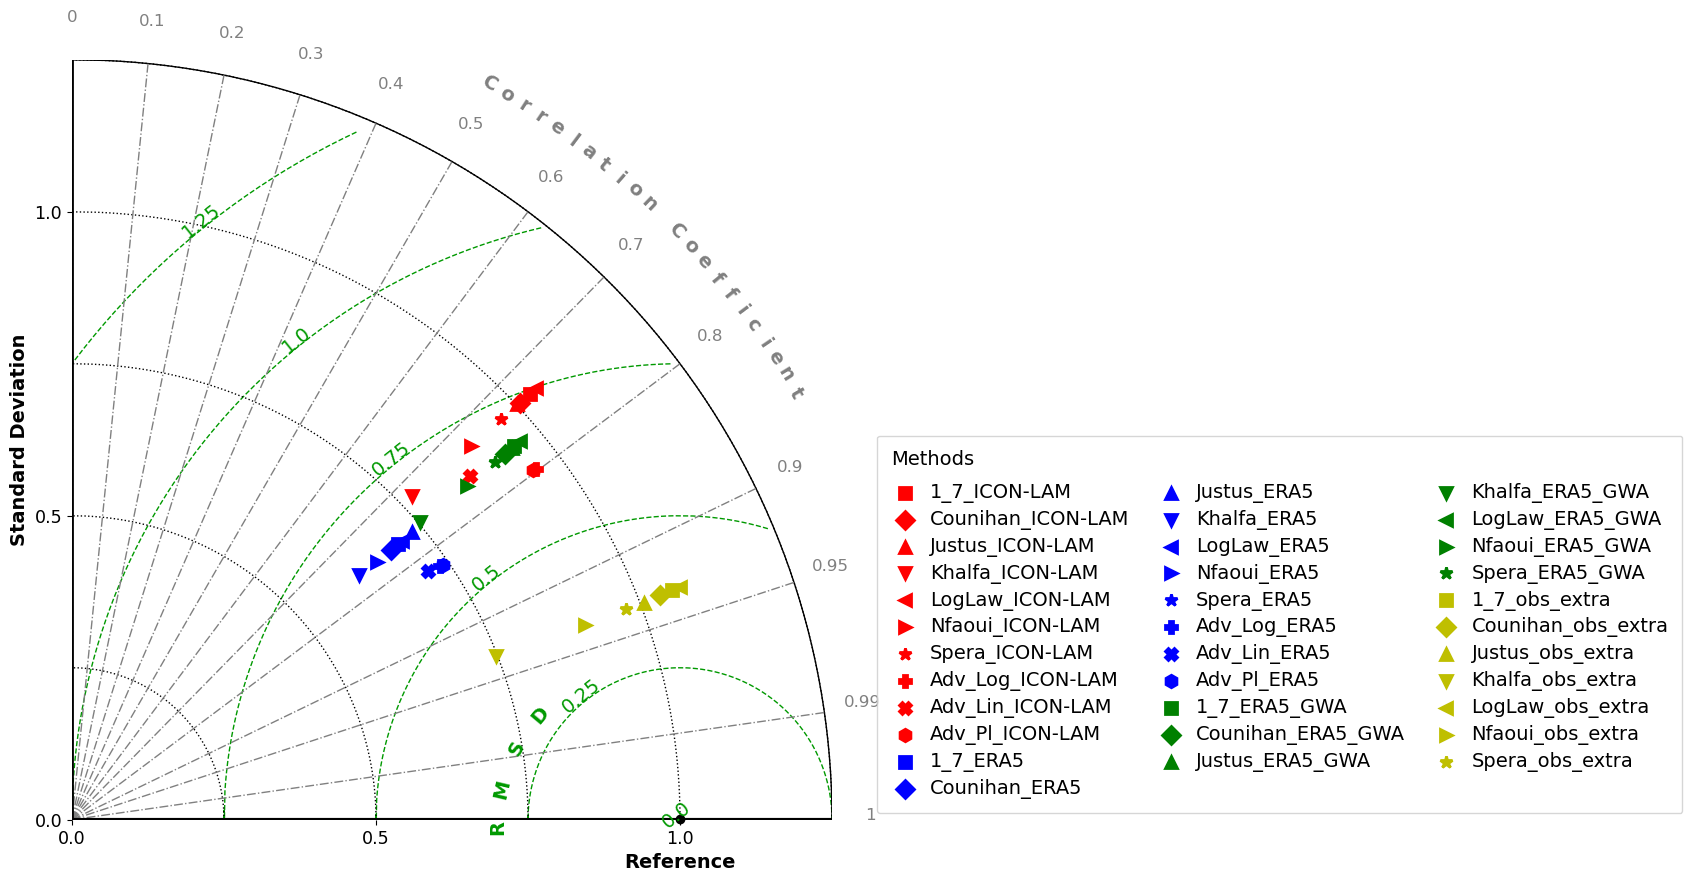

34 34

📊 Taylor Skill Score by methods and dataset at 20m with cut for WM01:

                    Skill Score
Method                         
Justus_obs_extra       0.967440
Spera_obs_extra        0.966802
Counihan_obs_extra     0.965784
1_7_obs_extra          0.963931
LogLaw_obs_extra       0.962395
Nfaoui_obs_extra       0.957507
Adv_Log_ICON           0.897033
Adv_Pl_ICON            0.896039
Khalfa_obs_extra       0.888731
LogLaw_ERA5_GWA        0.880750
1_7_ERA5_GWA           0.879789
Justus_ERA5_GWA        0.879173
Counihan_ERA5_GWA      0.877552
Spera_ERA5_GWA         0.874251
Counihan_ICON          0.866140
1_7_ICON               0.865486
Justus_ICON            0.865196
LogLaw_ICON            0.864712
Spera_ICON             0.864401
Adv_Lin_ICON           0.860545
Nfaoui_ERA5_GWA        0.858909
Nfaoui_ICON            0.855432
Adv_Pl_ERA5            0.833909
Adv_Log_ERA5           0.830117
Adv_Lin_ERA5           0.814536
Khalfa_ERA5_GWA        0.812722
Khalfa_ICON            0.8

In [37]:
import argparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import skill_metrics as sm

args = type('', (), {})()
args.no_show = False
args.no_save = False

# Configuration de l'affichage
rcParams["figure.figsize"] = [16.0, 12.8]
rcParams['lines.linewidth'] = 1
rcParams.update({'font.size': 12})
plt.close('all')



# 🔁 Chargement des feuilles spécifiques à la station WM01
icon_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ICON-LAM_60m_cut.xlsx", sheet_name="WM03")
ERA5_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ERA5_60m_cut.xlsx", sheet_name="WM03")
ERA5_GWA_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ERA5_GWA_60m_cut.xlsx", sheet_name="WM03")
obs_extrapolated_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_obs_extrapolated_60m_cut.xlsx", sheet_name="WM03")

stats0 = icon_WM01.loc[icon_WM01["Methods"] == "1_7", ["Std_obs"]]
stats1 = icon_WM01.loc[icon_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats2 = icon_WM01.loc[icon_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats3 = icon_WM01.loc[icon_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats4 = icon_WM01.loc[icon_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats5 = icon_WM01.loc[icon_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats6 = icon_WM01.loc[icon_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats7 = icon_WM01.loc[icon_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats8 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats9 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats10 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats11 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats12 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats13 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats14 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats15 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats16 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats17 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats18 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats19 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats20 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats21 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats22 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats23 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats24 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats25 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats26 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats27 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats31 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats32 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats33 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats34 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats35 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats36 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats37 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]



MARKERS = {
    "1_7_ICON-LAM": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Counihan_ICON-LAM": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Justus_ICON-LAM": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Khalfa_ICON-LAM": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "LogLaw_ICON-LAM": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Nfaoui_ICON-LAM": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Spera_ICON-LAM": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Log_ICON-LAM": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Lin_ICON-LAM": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Pl_ICON-LAM": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "1_7_ERA5": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Counihan_ERA5": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Justus_ERA5": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Khalfa_ERA5": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "LogLaw_ERA5": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Nfaoui_ERA5": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Spera_ERA5": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Log_ERA5": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Lin_ERA5": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Pl_ERA5": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "1_7_ERA5_GWA": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Counihan_ERA5_GWA": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Justus_ERA5_GWA": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Khalfa_ERA5_GWA": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "LogLaw_ERA5_GWA": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Nfaoui_ERA5_GWA": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Spera_ERA5_GWA": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "1_7_obs_extra": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Counihan_obs_extra": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Justus_obs_extra": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Khalfa_obs_extra": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "LogLaw_obs_extra": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Nfaoui_obs_extra": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Spera_obs_extra": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "y", "edgeColor": "y",}
                  }

# Regrouper les valeurs
sdev = np.array([
    stats0['Std_obs'].values[0],
    stats1['Std_pred'].values[0],
    stats2['Std_pred'].values[0],
    stats3['Std_pred'].values[0],
    stats4['Std_pred'].values[0],
    stats5['Std_pred'].values[0],
    stats6['Std_pred'].values[0],
    stats7['Std_pred'].values[0],
    stats8['Std_pred'].values[0],
    stats9['Std_pred'].values[0],
    stats10['Std_pred'].values[0],
    stats11['Std_pred'].values[0],
    stats12['Std_pred'].values[0],
    stats13['Std_pred'].values[0],
    stats14['Std_pred'].values[0],
    stats15['Std_pred'].values[0],
    stats16['Std_pred'].values[0],
    stats17['Std_pred'].values[0],
    stats18['Std_pred'].values[0],
    stats19['Std_pred'].values[0],
    stats20['Std_pred'].values[0],
    stats21['Std_pred'].values[0],
    stats22['Std_pred'].values[0],
    stats23['Std_pred'].values[0],
    stats24['Std_pred'].values[0],
    stats25['Std_pred'].values[0],
    stats26['Std_pred'].values[0],
    stats27['Std_pred'].values[0],
    stats31['Std_pred'].values[0],
    stats32['Std_pred'].values[0],
    stats33['Std_pred'].values[0],
    stats34['Std_pred'].values[0],
    stats35['Std_pred'].values[0],
    stats36['Std_pred'].values[0],
    stats37['Std_pred'].values[0]
])

crmsd = np.array([
    0,
    stats1['CRMSD'].values[0],
    stats2['CRMSD'].values[0],
    stats3['CRMSD'].values[0],
    stats4['CRMSD'].values[0],
    stats5['CRMSD'].values[0],
    stats6['CRMSD'].values[0],
    stats7['CRMSD'].values[0],
    stats8['CRMSD'].values[0],
    stats9['CRMSD'].values[0],
    stats10['CRMSD'].values[0],
    stats11['CRMSD'].values[0],
    stats12['CRMSD'].values[0],
    stats13['CRMSD'].values[0],
    stats14['CRMSD'].values[0],
    stats15['CRMSD'].values[0],
    stats16['CRMSD'].values[0],
    stats17['CRMSD'].values[0],
    stats18['CRMSD'].values[0],
    stats19['CRMSD'].values[0],
    stats20['CRMSD'].values[0],
    stats21['CRMSD'].values[0],
    stats22['CRMSD'].values[0],
    stats23['CRMSD'].values[0],
    stats24['CRMSD'].values[0],
    stats25['CRMSD'].values[0],
    stats26['CRMSD'].values[0],
    stats27['CRMSD'].values[0],
    stats31['CRMSD'].values[0],
    stats32['CRMSD'].values[0],
    stats33['CRMSD'].values[0],
    stats34['CRMSD'].values[0],
    stats35['CRMSD'].values[0],
    stats36['CRMSD'].values[0],
    stats37['CRMSD'].values[0]
])

ccoef = np.array([
    0,
    stats1['Pearson r'].values[0],
    stats2['Pearson r'].values[0],
    stats3['Pearson r'].values[0],
    stats4['Pearson r'].values[0],
    stats5['Pearson r'].values[0],
    stats6['Pearson r'].values[0],
    stats7['Pearson r'].values[0],
    stats8['Pearson r'].values[0],
    stats9['Pearson r'].values[0],
    stats10['Pearson r'].values[0],
    stats11['Pearson r'].values[0],
    stats12['Pearson r'].values[0],
    stats13['Pearson r'].values[0],
    stats14['Pearson r'].values[0],
    stats15['Pearson r'].values[0],
    stats16['Pearson r'].values[0],
    stats17['Pearson r'].values[0],
    stats18['Pearson r'].values[0],
    stats19['Pearson r'].values[0],
    stats20['Pearson r'].values[0],
    stats21['Pearson r'].values[0],
    stats22['Pearson r'].values[0],
    stats23['Pearson r'].values[0],
    stats24['Pearson r'].values[0],
    stats25['Pearson r'].values[0],
    stats26['Pearson r'].values[0],
    stats27['Pearson r'].values[0],
    stats31['Pearson r'].values[0],
    stats32['Pearson r'].values[0],
    stats33['Pearson r'].values[0],
    stats34['Pearson r'].values[0],
    stats35['Pearson r'].values[0],
    stats36['Pearson r'].values[0],
    stats37['Pearson r'].values[0]
])

# 🧮 Normaliser toutes les STD (et CRMSD) par la std de référence
sigma_ref = stats0['Std_obs'].values[0]

sdev_norm = sdev / sigma_ref
crmsd_norm = crmsd / sigma_ref

# Génération du diagramme
sm.taylor_diagram(sdev_norm, crmsd_norm, ccoef, markers = MARKERS,
                  markerLegend = 'on',
                  styleOBS='None',
                  markerOBS='o',
                  titleOBS='Reference',
                  colOBS='black',
                  colCOR='gray',
                  tickRMS = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  tickSTD = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  markerSize=10,)                


ax = plt.gca()
leg = ax.get_legend()

# 3. Déplace-la en haut et au centre
leg.set_loc('lower left')             # position “center top”
leg.set_bbox_to_anchor((1.05, 0.0))     # 0.5 = milieu en x, 1.15 au-dessus de la boxplot
leg.set_frame_on(True)                  # facultatif : remets un cadre si tu veux

# 🔧 Ajustements pour agrandir visuellement le box
leg.set_title("Methods", prop={'size': 14})
for text in leg.get_texts():
    text.set_fontsize(14)  # Taille du texte
leg._legend_box.sep = 10  # Espacement vertical entre les éléments
leg._legend_box.pad = 10  # Padding interne
leg._legend_box.align = "left"




# Sauvegarde conditionnelle
if not args.no_save:
    plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_diagram_20m_cut_WM03.png", bbox_inches='tight')

# Affichage conditionnel
if not args.no_show:
    plt.show()

plt.close()




# --- Normalisation de l'écart type
sdev_norm = sdev / sigma_ref

# --- Corrélation de référence
R0 = 1.0  # valeur par défaut utilisée dans de nombreux articles

# --- Fonction Skill Score de Taylor
def taylor_skill_score(r, sigma_star, r0=1.0):
    numerator = 4 * (1 + r)
    denominator = ((sigma_star + 1/sigma_star)**2) * (1 + r0)
    return numerator / denominator

# --- Calcul
scores = []
for i in range(len(ccoef)):
    r = ccoef[i]
    sigma_star = sdev_norm[i]
    score = taylor_skill_score(r, sigma_star, R0)
    scores.append(score)

# --- Résultat sous forme de DataFrame
method_labels = [
    "1_7_ICON", "Counihan_ICON", "Justus_ICON", "Khalfa_ICON", "LogLaw_ICON", "Nfaoui_ICON", "Spera_ICON",
    "Adv_Log_ICON", "Adv_Lin_ICON", "Adv_Pl_ICON",
    "1_7_ERA5", "Counihan_ERA5", "Justus_ERA5", "Khalfa_ERA5", "LogLaw_ERA5", "Nfaoui_ERA5", "Spera_ERA5",
    "Adv_Log_ERA5", "Adv_Lin_ERA5", "Adv_Pl_ERA5",
    "1_7_ERA5_GWA", "Counihan_ERA5_GWA", "Justus_ERA5_GWA", "Khalfa_ERA5_GWA", "LogLaw_ERA5_GWA", "Nfaoui_ERA5_GWA", "Spera_ERA5_GWA",
    "1_7_obs_extra", "Counihan_obs_extra", "Justus_obs_extra", "Khalfa_obs_extra", "LogLaw_obs_extra", "Nfaoui_obs_extra", "Spera_obs_extra"

]

# on slice scores pour ne garder que les 27 méthodes
method_scores = scores[1:]

print(len(method_labels), len(method_scores))  # 27, 27

skill_20m_cut_df = pd.DataFrame({
    "Method": method_labels,
    "Skill Score": method_scores
}).set_index("Method").sort_values("Skill Score", ascending=False)

# --- Affichage
print("\n📊 Taylor Skill Score by methods and dataset at 20m with cut for WM01:\n")
print(skill_20m_cut_df.round(6))

# --- Export
skill_20m_cut_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_skill_scores_20m_cut_WM03.xlsx")


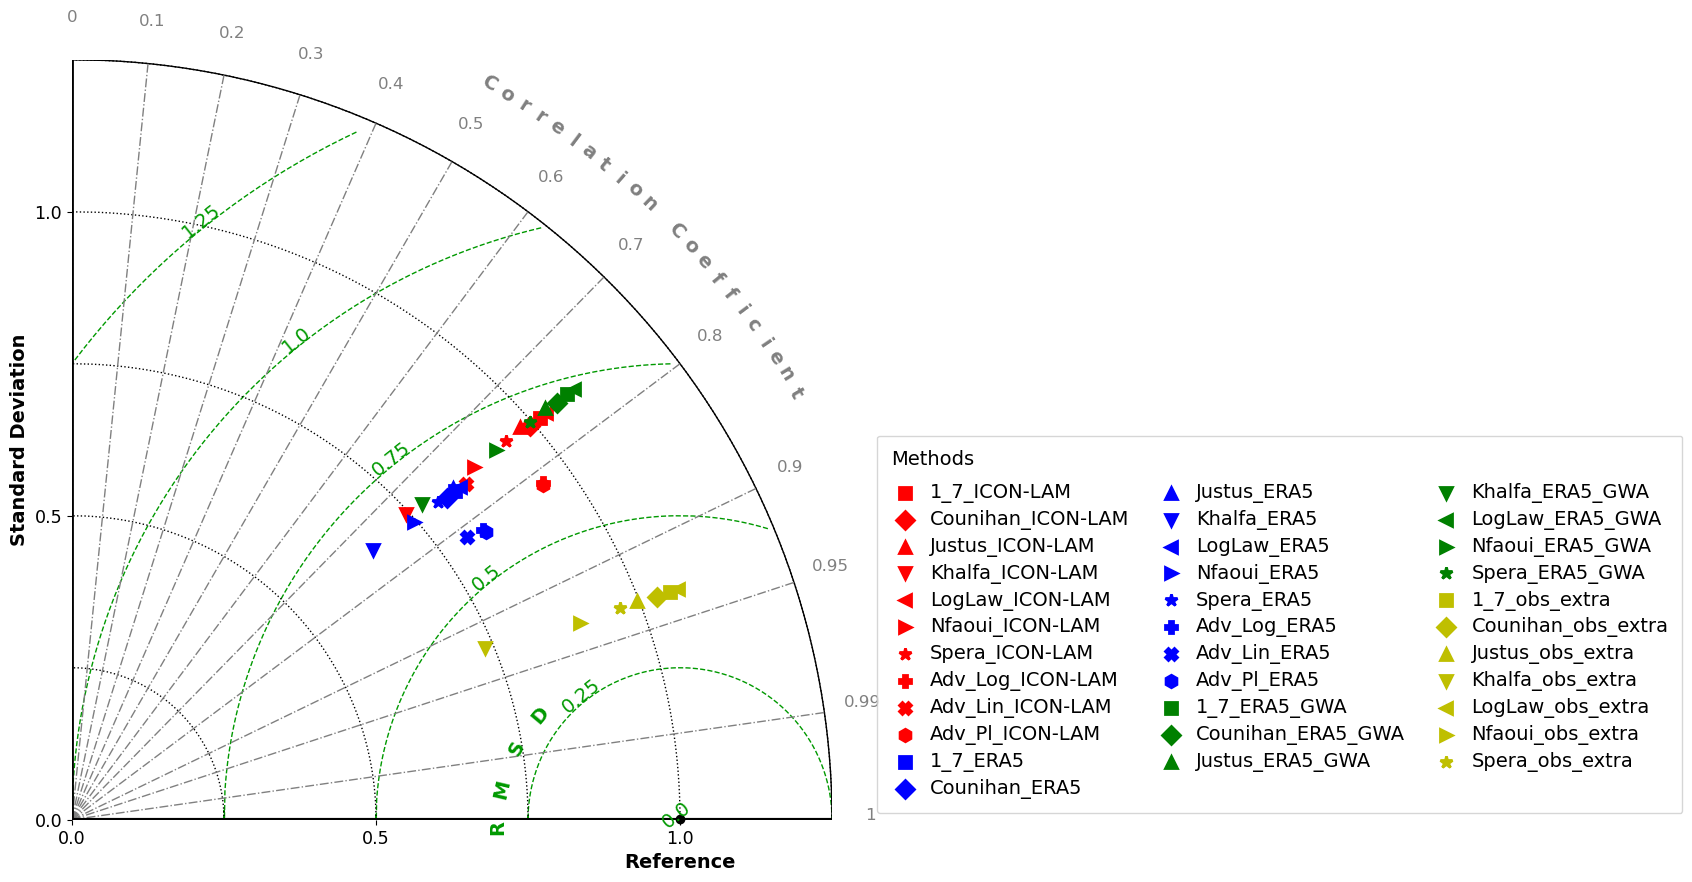

34 34

📊 Taylor Skill Score by methods and dataset at 20m with cut for WM01:

                    Skill Score
Method                         
Counihan_obs_extra     0.966425
Justus_obs_extra       0.966238
Spera_obs_extra        0.965342
1_7_obs_extra          0.964772
LogLaw_obs_extra       0.963356
Nfaoui_obs_extra       0.954485
Adv_Pl_ICON            0.905159
Adv_Log_ICON           0.904757
Counihan_ICON          0.879417
1_7_ICON               0.879261
Adv_Pl_ERA5            0.879084
LogLaw_ICON            0.878780
Spera_ERA5_GWA         0.877493
Counihan_ERA5_GWA      0.877068
Adv_Log_ERA5           0.876432
Khalfa_obs_extra       0.876333
Justus_ERA5_GWA        0.876293
Justus_ICON            0.875803
1_7_ERA5_GWA           0.874785
Spera_ICON             0.874109
LogLaw_ERA5_GWA        0.873033
Nfaoui_ERA5_GWA        0.871872
Adv_Lin_ERA5           0.862753
Nfaoui_ICON            0.861859
Adv_Lin_ICON           0.858154
LogLaw_ERA5            0.853389
1_7_ERA5               0.8

In [38]:
import argparse
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import skill_metrics as sm

args = type('', (), {})()
args.no_show = False
args.no_save = False

# Configuration de l'affichage
rcParams["figure.figsize"] = [16.0, 12.8]
rcParams['lines.linewidth'] = 1
rcParams.update({'font.size': 12})
plt.close('all')



# 🔁 Chargement des feuilles spécifiques à la station WM01
icon_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ICON-LAM_60m_cut.xlsx", sheet_name="WM06")
ERA5_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ERA5_60m_cut.xlsx", sheet_name="WM06")
ERA5_GWA_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_ERA5_GWA_60m_cut.xlsx", sheet_name="WM06")
obs_extrapolated_WM01 = pd.read_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\Metrics\Metric_WM\metrics_obs_extrapolated_60m_cut.xlsx", sheet_name="WM06")

stats0 = icon_WM01.loc[icon_WM01["Methods"] == "1_7", ["Std_obs"]]
stats1 = icon_WM01.loc[icon_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats2 = icon_WM01.loc[icon_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats3 = icon_WM01.loc[icon_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats4 = icon_WM01.loc[icon_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats5 = icon_WM01.loc[icon_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats6 = icon_WM01.loc[icon_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats7 = icon_WM01.loc[icon_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats8 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats9 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats10 = icon_WM01.loc[icon_WM01["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats11 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats12 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats13 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats14 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats15 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats16 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats17 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats18 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Log", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats19 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Lin", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats20 = ERA5_WM01.loc[ERA5_WM01["Methods"] == "Adv_Pl", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats21 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats22 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats23 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats24 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats25 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats26 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats27 = ERA5_GWA_WM01.loc[ERA5_GWA_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats31 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "1_7", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats32 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Counihan", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats33 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Justus", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats34 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Khalfa", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats35 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "LogLaw", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats36 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Nfaoui", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]
stats37 = obs_extrapolated_WM01.loc[obs_extrapolated_WM01["Methods"] == "Spera", ["Pearson r","Std_pred", "Std_obs", "CRMSD"]]



MARKERS = {
    "1_7_ICON-LAM": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Counihan_ICON-LAM": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Justus_ICON-LAM": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Khalfa_ICON-LAM": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "LogLaw_ICON-LAM": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Nfaoui_ICON-LAM": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Spera_ICON-LAM": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Log_ICON-LAM": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Lin_ICON-LAM": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "Adv_Pl_ICON-LAM": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "r", "edgeColor": "r",},
    "1_7_ERA5": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Counihan_ERA5": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Justus_ERA5": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Khalfa_ERA5": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "LogLaw_ERA5": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Nfaoui_ERA5": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Spera_ERA5": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Log_ERA5": {"labelColor": "black", "symbol": "P", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Lin_ERA5": {"labelColor": "black", "symbol": "X", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "Adv_Pl_ERA5": {"labelColor": "black", "symbol": "h", "size": 9, "faceColor": "b", "edgeColor": "b",},
    "1_7_ERA5_GWA": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Counihan_ERA5_GWA": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Justus_ERA5_GWA": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Khalfa_ERA5_GWA": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "LogLaw_ERA5_GWA": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Nfaoui_ERA5_GWA": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "Spera_ERA5_GWA": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "g", "edgeColor": "g",},
    "1_7_obs_extra": {"labelColor": "black", "symbol": "s", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Counihan_obs_extra": {"labelColor": "black", "symbol": "D", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Justus_obs_extra": {"labelColor": "black", "symbol": "^", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Khalfa_obs_extra": {"labelColor": "black", "symbol": "v", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "LogLaw_obs_extra": {"labelColor": "black", "symbol": "<", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Nfaoui_obs_extra": {"labelColor": "black", "symbol": ">", "size": 9, "faceColor": "y", "edgeColor": "y",},
    "Spera_obs_extra": {"labelColor": "black", "symbol": "*", "size": 9, "faceColor": "y", "edgeColor": "y",}
                  }

# Regrouper les valeurs
sdev = np.array([
    stats0['Std_obs'].values[0],
    stats1['Std_pred'].values[0],
    stats2['Std_pred'].values[0],
    stats3['Std_pred'].values[0],
    stats4['Std_pred'].values[0],
    stats5['Std_pred'].values[0],
    stats6['Std_pred'].values[0],
    stats7['Std_pred'].values[0],
    stats8['Std_pred'].values[0],
    stats9['Std_pred'].values[0],
    stats10['Std_pred'].values[0],
    stats11['Std_pred'].values[0],
    stats12['Std_pred'].values[0],
    stats13['Std_pred'].values[0],
    stats14['Std_pred'].values[0],
    stats15['Std_pred'].values[0],
    stats16['Std_pred'].values[0],
    stats17['Std_pred'].values[0],
    stats18['Std_pred'].values[0],
    stats19['Std_pred'].values[0],
    stats20['Std_pred'].values[0],
    stats21['Std_pred'].values[0],
    stats22['Std_pred'].values[0],
    stats23['Std_pred'].values[0],
    stats24['Std_pred'].values[0],
    stats25['Std_pred'].values[0],
    stats26['Std_pred'].values[0],
    stats27['Std_pred'].values[0],
    stats31['Std_pred'].values[0],
    stats32['Std_pred'].values[0],
    stats33['Std_pred'].values[0],
    stats34['Std_pred'].values[0],
    stats35['Std_pred'].values[0],
    stats36['Std_pred'].values[0],
    stats37['Std_pred'].values[0]
])

crmsd = np.array([
    0,
    stats1['CRMSD'].values[0],
    stats2['CRMSD'].values[0],
    stats3['CRMSD'].values[0],
    stats4['CRMSD'].values[0],
    stats5['CRMSD'].values[0],
    stats6['CRMSD'].values[0],
    stats7['CRMSD'].values[0],
    stats8['CRMSD'].values[0],
    stats9['CRMSD'].values[0],
    stats10['CRMSD'].values[0],
    stats11['CRMSD'].values[0],
    stats12['CRMSD'].values[0],
    stats13['CRMSD'].values[0],
    stats14['CRMSD'].values[0],
    stats15['CRMSD'].values[0],
    stats16['CRMSD'].values[0],
    stats17['CRMSD'].values[0],
    stats18['CRMSD'].values[0],
    stats19['CRMSD'].values[0],
    stats20['CRMSD'].values[0],
    stats21['CRMSD'].values[0],
    stats22['CRMSD'].values[0],
    stats23['CRMSD'].values[0],
    stats24['CRMSD'].values[0],
    stats25['CRMSD'].values[0],
    stats26['CRMSD'].values[0],
    stats27['CRMSD'].values[0],
    stats31['CRMSD'].values[0],
    stats32['CRMSD'].values[0],
    stats33['CRMSD'].values[0],
    stats34['CRMSD'].values[0],
    stats35['CRMSD'].values[0],
    stats36['CRMSD'].values[0],
    stats37['CRMSD'].values[0]
])

ccoef = np.array([
    0,
    stats1['Pearson r'].values[0],
    stats2['Pearson r'].values[0],
    stats3['Pearson r'].values[0],
    stats4['Pearson r'].values[0],
    stats5['Pearson r'].values[0],
    stats6['Pearson r'].values[0],
    stats7['Pearson r'].values[0],
    stats8['Pearson r'].values[0],
    stats9['Pearson r'].values[0],
    stats10['Pearson r'].values[0],
    stats11['Pearson r'].values[0],
    stats12['Pearson r'].values[0],
    stats13['Pearson r'].values[0],
    stats14['Pearson r'].values[0],
    stats15['Pearson r'].values[0],
    stats16['Pearson r'].values[0],
    stats17['Pearson r'].values[0],
    stats18['Pearson r'].values[0],
    stats19['Pearson r'].values[0],
    stats20['Pearson r'].values[0],
    stats21['Pearson r'].values[0],
    stats22['Pearson r'].values[0],
    stats23['Pearson r'].values[0],
    stats24['Pearson r'].values[0],
    stats25['Pearson r'].values[0],
    stats26['Pearson r'].values[0],
    stats27['Pearson r'].values[0],
    stats31['Pearson r'].values[0],
    stats32['Pearson r'].values[0],
    stats33['Pearson r'].values[0],
    stats34['Pearson r'].values[0],
    stats35['Pearson r'].values[0],
    stats36['Pearson r'].values[0],
    stats37['Pearson r'].values[0]
])

# 🧮 Normaliser toutes les STD (et CRMSD) par la std de référence
sigma_ref = stats0['Std_obs'].values[0]

sdev_norm = sdev / sigma_ref
crmsd_norm = crmsd / sigma_ref

# Génération du diagramme
sm.taylor_diagram(sdev_norm, crmsd_norm, ccoef, markers = MARKERS,
                  markerLegend = 'on',
                  styleOBS='None',
                  markerOBS='o',
                  titleOBS='Reference',
                  colOBS='black',
                  colCOR='gray',
                  tickRMS = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  tickSTD = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25],
                  markerSize=10,)                


ax = plt.gca()
leg = ax.get_legend()

# 3. Déplace-la en haut et au centre
leg.set_loc('lower left')             # position “center top”
leg.set_bbox_to_anchor((1.05, 0.0))     # 0.5 = milieu en x, 1.15 au-dessus de la boxplot
leg.set_frame_on(True)                  # facultatif : remets un cadre si tu veux

# 🔧 Ajustements pour agrandir visuellement le box
leg.set_title("Methods", prop={'size': 14})
for text in leg.get_texts():
    text.set_fontsize(14)  # Taille du texte
leg._legend_box.sep = 10  # Espacement vertical entre les éléments
leg._legend_box.pad = 10  # Padding interne
leg._legend_box.align = "left"




# Sauvegarde conditionnelle
if not args.no_save:
    plt.savefig(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_diagram_20m_cut_WM06.png", bbox_inches='tight')

# Affichage conditionnel
if not args.no_show:
    plt.show()

plt.close()




# --- Normalisation de l'écart type
sdev_norm = sdev / sigma_ref

# --- Corrélation de référence
R0 = 1.0  # valeur par défaut utilisée dans de nombreux articles

# --- Fonction Skill Score de Taylor
def taylor_skill_score(r, sigma_star, r0=1.0):
    numerator = 4 * (1 + r)
    denominator = ((sigma_star + 1/sigma_star)**2) * (1 + r0)
    return numerator / denominator

# --- Calcul
scores = []
for i in range(len(ccoef)):
    r = ccoef[i]
    sigma_star = sdev_norm[i]
    score = taylor_skill_score(r, sigma_star, R0)
    scores.append(score)

# --- Résultat sous forme de DataFrame
method_labels = [
    "1_7_ICON", "Counihan_ICON", "Justus_ICON", "Khalfa_ICON", "LogLaw_ICON", "Nfaoui_ICON", "Spera_ICON",
    "Adv_Log_ICON", "Adv_Lin_ICON", "Adv_Pl_ICON",
    "1_7_ERA5", "Counihan_ERA5", "Justus_ERA5", "Khalfa_ERA5", "LogLaw_ERA5", "Nfaoui_ERA5", "Spera_ERA5",
    "Adv_Log_ERA5", "Adv_Lin_ERA5", "Adv_Pl_ERA5",
    "1_7_ERA5_GWA", "Counihan_ERA5_GWA", "Justus_ERA5_GWA", "Khalfa_ERA5_GWA", "LogLaw_ERA5_GWA", "Nfaoui_ERA5_GWA", "Spera_ERA5_GWA",
    "1_7_obs_extra", "Counihan_obs_extra", "Justus_obs_extra", "Khalfa_obs_extra", "LogLaw_obs_extra", "Nfaoui_obs_extra", "Spera_obs_extra"

]

# on slice scores pour ne garder que les 27 méthodes
method_scores = scores[1:]

print(len(method_labels), len(method_scores))  # 27, 27

skill_20m_cut_df = pd.DataFrame({
    "Method": method_labels,
    "Skill Score": method_scores
}).set_index("Method").sort_values("Skill Score", ascending=False)

# --- Affichage
print("\n📊 Taylor Skill Score by methods and dataset at 20m with cut for WM01:\n")
print(skill_20m_cut_df.round(6))

# --- Export
skill_20m_cut_df.to_excel(r"C:\Users\LENOVO\Downloads\pyton trainning\essais perso\week 16\Final coding\plot\taylor\taylor_skill_scores_20m_cut_WM06.xlsx")


In [ ]:
\Final coding
Adv_